# Part 1: Introduction

Context: Correctly predicticting if a person will have a stroke or not would be useful to improve health outcomes for patients in or out of hospitals.

Goal: given 10 chracteristics about a given person, is it possible to predict if they will have a stroke using machine learning models? 

Data source: Unknown

Intended audience: Johns Hopkins Hospital stroke prevention team. 
- doctors
- nurses
- management 
- patients 

Size of dataset: 5110 rows, 12 features. 

Project Flow: 
- Introduction
- Importing necessary libraries and data
- Exploratory Data Analysis
- Statistical inference
- Model implementation
- Model deployment
- Conclusion
- References
- Appendix



# Part 2: Exploratory data analysis

Importing necessary libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import missingno as msno 
import phik
import statsmodels.api as sm
from scipy.stats import chi2_contingency, kstest
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (make_scorer, recall_score, accuracy_score, balanced_accuracy_score, f1_score, fbeta_score, roc_auc_score, average_precision_score, matthews_corrcoef, confusion_matrix, confusion_matrix, classification_report)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from skopt import BayesSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.inspection import permutation_importance
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, StackingClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier)
from sklearn.utils.class_weight import compute_class_weight
from skopt.space import Real, Categorical
from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import joblib
import warnings

from func_2 import impute_mean_group, drop_row, percent_dist, num_dist_ins, cat_dist_ins, chisq, Mann_Whit, get_results, bayes_hyperparam_tuning, vif, format_cm_labels, plot_qq, Mann_Whit_gr0_less, outlier_ratio_iqr
%matplotlib inline 


ModuleNotFoundError: No module named 'missingno'

## Initial data exploration: 

Importing dataset:

In [ ]:
data = pd.read_csv('../ml_2/healthcare-dataset-stroke-data.csv', sep=',')
data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


There are 12 features and 5110 rows in this dataset. 

Data Types: 

In [ ]:
data.dtypes.sort_values()

id                     int64
hypertension           int64
heart_disease          int64
stroke                 int64
age                  float64
avg_glucose_level    float64
bmi                  float64
gender                object
ever_married          object
work_type             object
Residence_type        object
smoking_status        object
dtype: object

Variables in this dataset are floats, integers, and objects. 

Integers: 
- ID: unique patient identifier.
- Hypertension: likely binary, 0 for no hypertension or 1 if the patient does have hypertension.
- Heart_disease: likely binary, 0 for the patient not having heart disease or 1 for the patient with heart disease. 
- Stroke: likely binary, 0 for patients that have not had a stroke or 1 for patients that have had (a) stroke(s). 

Floats: 
- Age: age of patient.
- Avg_glucose_level: the patient's average blood glucose level, likely measured in mg/dL. According to the World Health Organization, normal values for fasting blood glucose fall in the range of 70-100 mg/dL.
- Bmi: body mass index of the patient, generally measured in $kg/m^2$. This generally ranges from 18.5-30 $kg/m^2$ for a healthy adult.

Objects: 
- Gender: gender of the patient, likely female, male or other for categories. 
- Ever_married: if the patient has been married or not. Likely this is categorical with yes or no as possible entries. 
- Work_type: the patient's occupation (categorical variable).
- Residence_type: description of where the patient lives (categorical variable). 
- Smoking_status: does or has the patient smoked? (categorical variable)

## Duplicate Rows: 

Are there any duplicate rows? 

In [ ]:
data.duplicated().any()


np.False_

No duplicates are present when the patient's id is taken into account. This ensures that there are no repeated patient entries. Are there any sets of duplicate features disregarding the patient's id? 

In [ ]:
copy = data.drop(['id'], axis=1)
copy.duplicated().any()

np.False_

No duplicate entries are present here either. 

## Splitting data into training and test sets: 

20% of this data will be reserved for testing post modeling: 

In [ ]:
train, test = train_test_split(data, test_size=0.2, random_state=42, stratify=data['stroke'])

## Null values: 

Are there any null values?

In [ ]:
data.isnull().sum()


id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

As a percentage: 

In [ ]:
(data['bmi'].isnull().sum())*100/len(data)

np.float64(3.9334637964774952)

The bmi variable has 201 null values, which is about 4% of the entire dataset. Dropping these null values could lead to a loss of information if they are not missing completely at random. Looking at a matrix of these values: 

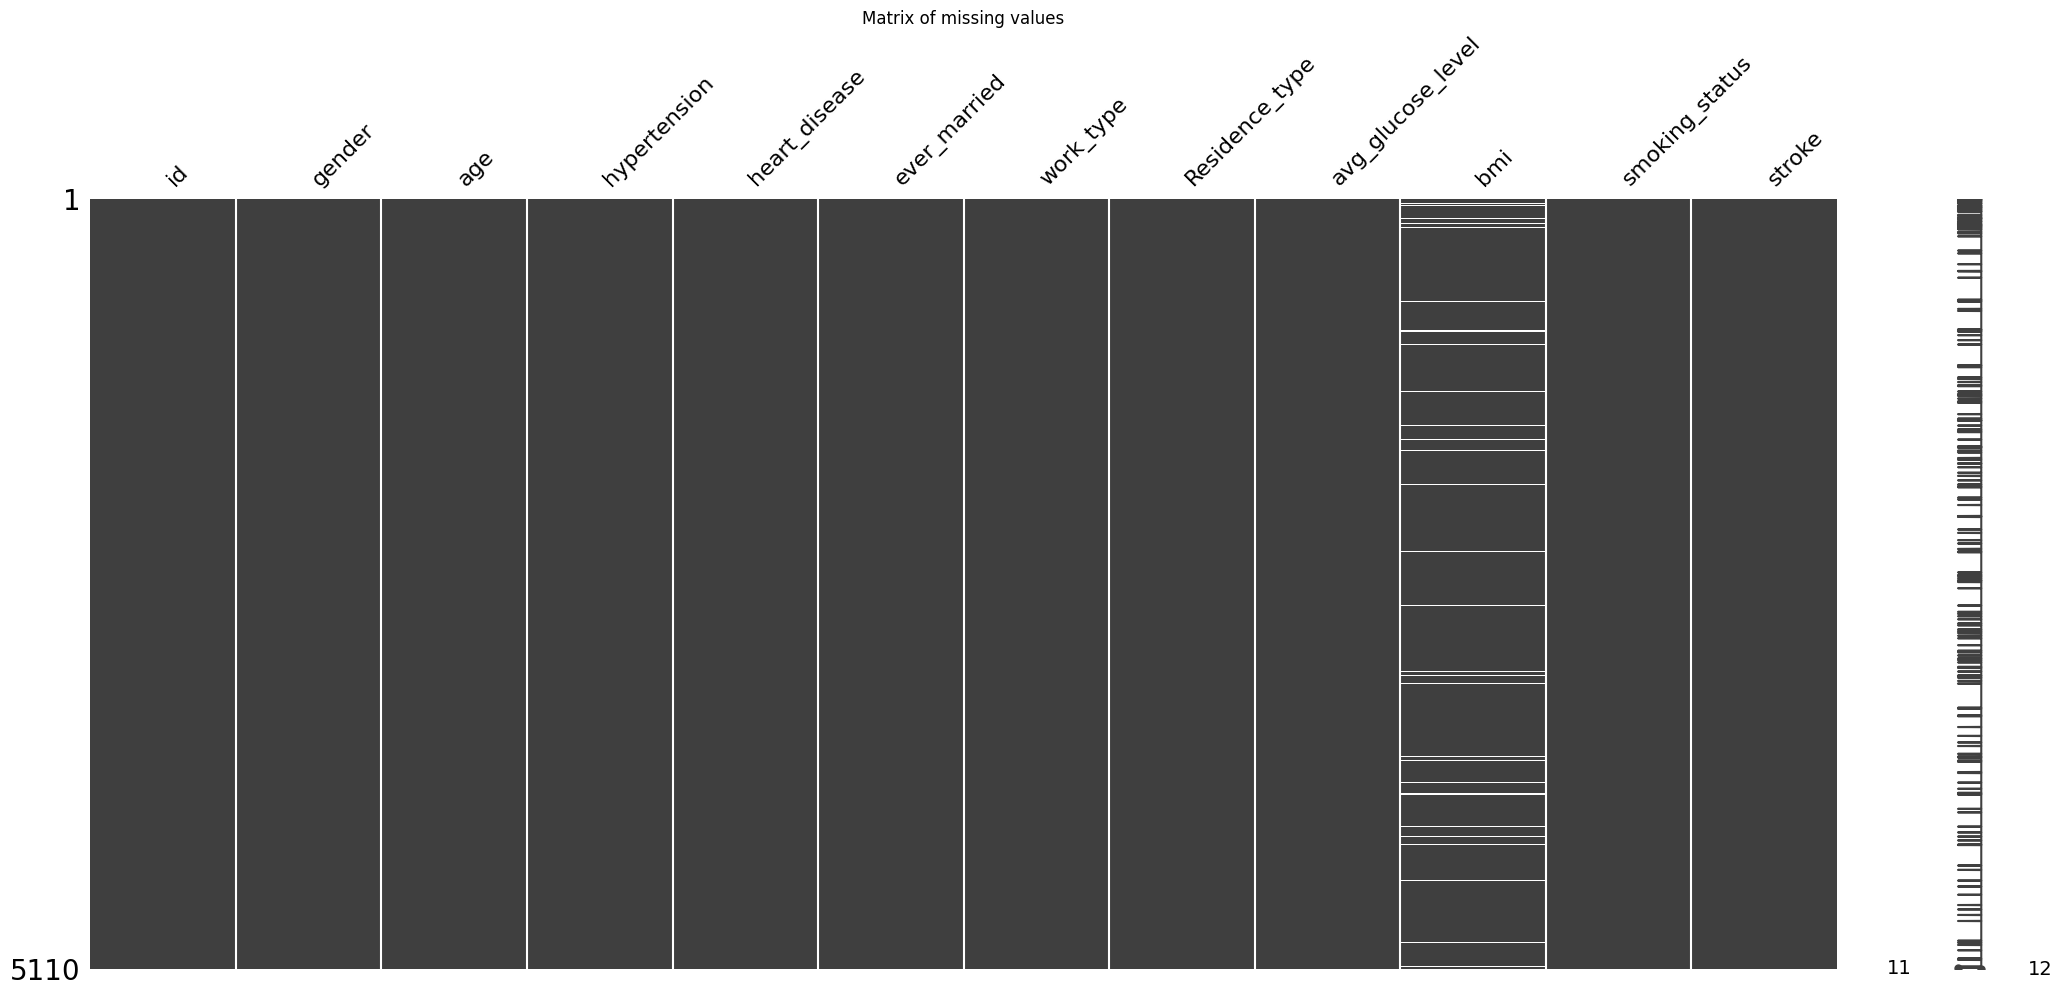

In [ ]:
msno.matrix(data).set(title='Matrix of missing values');

No obvious trends are seen at first glance for the missing bmi values. 

Looking at these missing values in terms of stroke: 

In [ ]:
bmi_null = train[train['bmi'].isnull()]
bmi_null['stroke'].value_counts()

stroke
0    133
1     37
Name: count, dtype: int64

37 of these people with missing bmi values in the training data have had a stroke. As stroke incidence is rare, there could be a relationship between data entries with missing bmi values and stroke. 

To check this, a simple chi squared test can be performed at the 95% confidence level. 

The **null hypothesis** is that missing bmi value entries are not associated with stroke incidence. 

The **alternate hypothesis** here is that entries with missing bmi values are associated with stroke incidence. 

In [ ]:
alpha = 0.05
contingency_table = pd.crosstab(train['stroke'], train['bmi'].isnull())
chi2, p, dof, expected = chi2_contingency(contingency_table)
print('contingengy table \n', contingency_table)
print(f"Chi-Squared Statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of Freedom: {dof}")
if p < alpha:
    print(f"Reject the null hypothesis - There is a relationship between stroke and missing bmi values.")
else:
    print(f"Fail to reject the null hypothesis - There is no relationship between stroke and missing bmi values.")



contingengy table 
 bmi     False  True 
stroke              
0        3756    133
1         162     37
Chi-Squared Statistic: 105.58023876181366
p-value: 9.113200419028339e-25
Degrees of Freedom: 1
Reject the null hypothesis - There is a relationship between stroke and missing bmi values.


According to the chi squared test, there is a relationship between stroke incidence and missing bmi values in the training data. Therefore, these will be imputed using the mean of each age group. An additional column is also added to the dataframe to indicate if a given bmi value is imputed (1) or not (0): 

Creating a pipeline and performing the imputation of missing values: 

In [ ]:
column_transformer = ColumnTransformer([
    ('group_imputer', impute_mean_group(group_col='age', target_col='bmi'), ['age', 'bmi'])
], remainder='passthrough')  

pipeline_1 = Pipeline([
    ('column_transform', column_transformer)
])

pipeline_1.fit(train)
train_transformed = pipeline_1.transform(train)
test_transformed = pipeline_1.transform(test)
train_cleaned = pd.DataFrame(train_transformed, columns=['age', 'bmi', 'bmi_imputed'] + [col for col in train.columns if col not in ['age', 'bmi']])
test_cleaned = pd.DataFrame(test_transformed, columns=['age', 'bmi', 'bmi_imputed'] + [col for col in test.columns if col not in ['age', 'bmi']])

types = data.dtypes.to_dict()
train_cleaned = train_cleaned.astype(types)
test_cleaned = test_cleaned.astype(types)

print("Missing values in train:\n", train_cleaned.isnull().sum(), '\n')
print("Missing values in test:\n", test_cleaned.isnull().sum())


Missing values in train:
 age                  0
bmi                  0
bmi_imputed          0
id                   0
gender               0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
smoking_status       0
stroke               0
dtype: int64 

Missing values in test:
 age                  0
bmi                  0
bmi_imputed          0
id                   0
gender               0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
smoking_status       0
stroke               0
dtype: int64


No null values are left in the dataset, which is now called train_cleaned.

Saving this initial pipeline for later use: 

In [ ]:
joblib.dump(pipeline_1, "bmi_imputation_pipeline.joblib");

Also, saving a copy of this data for use in a final preprocessing pipeline before model deployment: 

In [ ]:
train_cleaned_1 = train_cleaned.copy()
test_cleaned_1 = test_cleaned.copy()

Are there any empty strings? 

In [ ]:
p

(array([], dtype=int64), array([], dtype=int64))

There are no empty strings.

## Variable exploration: 

### Stroke

It is important to look at the distribution of the target variable: 

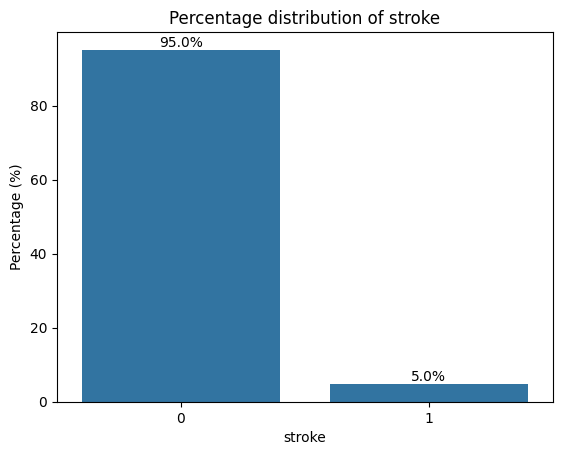

In [ ]:
percent_dist(train_cleaned, 'stroke')

Only 5% of people in this dataset have had a stroke. This means that the dataset is highly imbalanced, which will be important to keep in mind when performing statistical tests or when choosing modeling techniques. 

### Outlier Examination for numerical variables:

Next, the numerical variables can be examined using boxplots to identify outliers:

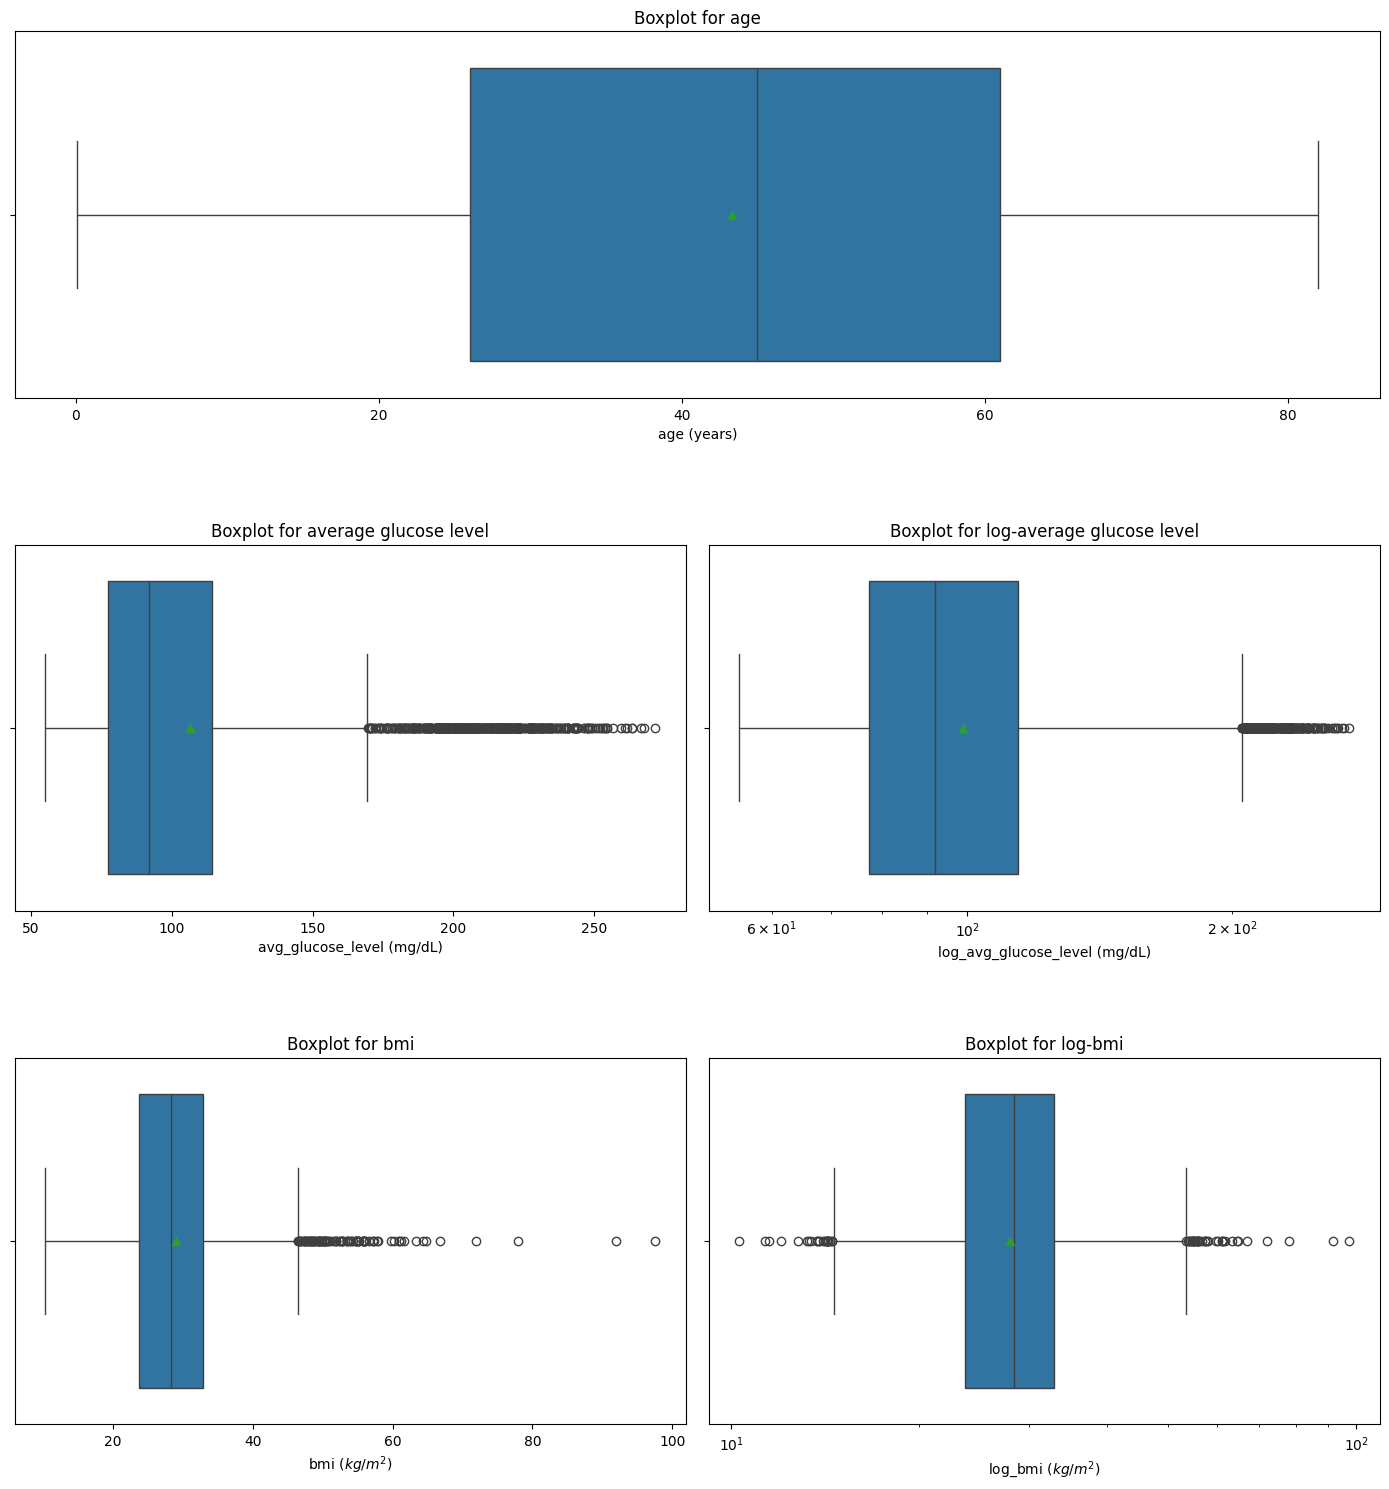

In [ ]:

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(14, 15), gridspec_kw={'height_ratios': [1, 1, 1]})
ax_top = fig.add_subplot(3, 1, 1)
sns.boxplot(data=train_cleaned, x='age', showmeans=True, ax=ax_top).set(title="Boxplot for age", xlabel='age (years)')
axs[0, 1].remove()  
axs[0, 0].remove()
sns.boxplot(data=train_cleaned, x='avg_glucose_level', showmeans=True, ax=axs[1, 0]).set(title="Boxplot for average glucose level", xlabel='avg_glucose_level (mg/dL)')
sns.boxplot(data=train_cleaned, x='bmi', showmeans=True, ax=axs[2, 0]).set(title="Boxplot for bmi", xlabel='bmi ($kg/m^2$)')
sns.boxplot(data=train_cleaned, x='avg_glucose_level', log_scale=True, showmeans=True, ax=axs[1, 1]).set(title="Boxplot for log-average glucose level", xlabel='log_avg_glucose_level (mg/dL)')
sns.boxplot(data=train_cleaned, x='bmi', showmeans=True, log_scale=True, ax=axs[2, 1]).set(title="Boxplot for log-bmi", xlabel='log_bmi ($kg/m^2$)')

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)  

plt.show()

The original bmi and avg_glucose_level variables both have quite a few outliers. As these distributions are both skewed to the right, a log transformed version of this data is added on the right of the figure and in the dataset. Looking at the outlier ratio of the original bmi data: 

In [ ]:
train_cleaned['log_bmi'] = np.log1p(train_cleaned['bmi'])
train_cleaned['log_glucose'] = np.log1p(train_cleaned['avg_glucose_level'])
test_cleaned['log_bmi'] = np.log1p(test_cleaned['bmi'])
test_cleaned['log_glucose'] = np.log1p(test_cleaned['avg_glucose_level'])

In [ ]:
outlier_ratio_iqr(train_cleaned, 'bmi')*100

2.3972602739726026

As a ratio, the bmi outliers account for about 2% of data. Looking at the same for the log-transformed bmi data: 

In [ ]:
outlier_ratio_iqr(train_cleaned, 'log_bmi')*100

1.5900195694716242

The log transformation helped in reducing the number of outliers in the bmi column. This variable with remaining outliers will be kept in case a model is chosen that is sensitive to outliers. Looking at the same for the average glucose level (not log-transformed):

In [ ]:
outlier_ratio_iqr(train_cleaned, 'avg_glucose_level')

0.12304305283757339

As a ratio, the average glucose level outliers account for about 12% of data. For the log-transformed data, this is: 


In [ ]:
outlier_ratio_iqr(train_cleaned, 'log_glucose')*100

7.509784735812134

This also helped in reducing the number of outliers. Looking at the training dataset now: 

In [ ]:
train_cleaned.sort_values(by='log_bmi')

,age,bmi,bmi_imputed,id,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,smoking_status,stroke,log_bmi,log_glucose
3031,1.24,10.3,0.0,38043,Female,0,0,No,children,Rural,122.04,Unknown,0,2.424803,4.812510
1878,79.00,11.3,0.0,3205,Female,0,0,Yes,Self-employed,Urban,79.03,Unknown,0,2.509599,4.382402
1837,40.00,11.5,0.0,59993,Male,0,0,Yes,Private,Rural,60.96,never smoked,0,2.525729,4.126489
3181,4.00,12.0,0.0,20364,Female,0,0,No,children,Urban,107.25,Unknown,0,2.564949,4.684443
617,1.08,12.8,0.0,53924,Female,0,0,No,children,Urban,159.39,Unknown,0,2.624669,5.077608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,53.00,66.8,0.0,37759,Female,0,0,Yes,Private,Rural,72.63,Unknown,0,4.216562,4.299053
2008,42.00,71.9,0.0,545,Male,0,0,Yes,Private,Rural,210.48,never smoked,0,4.289089,5.354130
600,23.00,78.0,0.0,41097,Female,1,0,No,Private,Urban,70.03,smokes,0,4.369448,4.263102
2330,38.00,92.0,0.0,51856,Male,1,0,Yes,Private,Rural,56.90,never smoked,0,4.532599,4.058717


The average glucose level variable's outliers are all quite close together. The bmi variable's outliers are more spread out: there is one obvious outlier with very low bmi and four outliers with very high bmi values. A medical professional could help to indicate if these are realistic values for bmi or imputation errors. Since this is currently unknown, these outliers will be kept in the dataset. 

Next, it is possible to look at the distribution of these log-transformed numerical variables grouped by if a patient has had a stroke or not.

### Distribution for numerical variables grouped by stroke

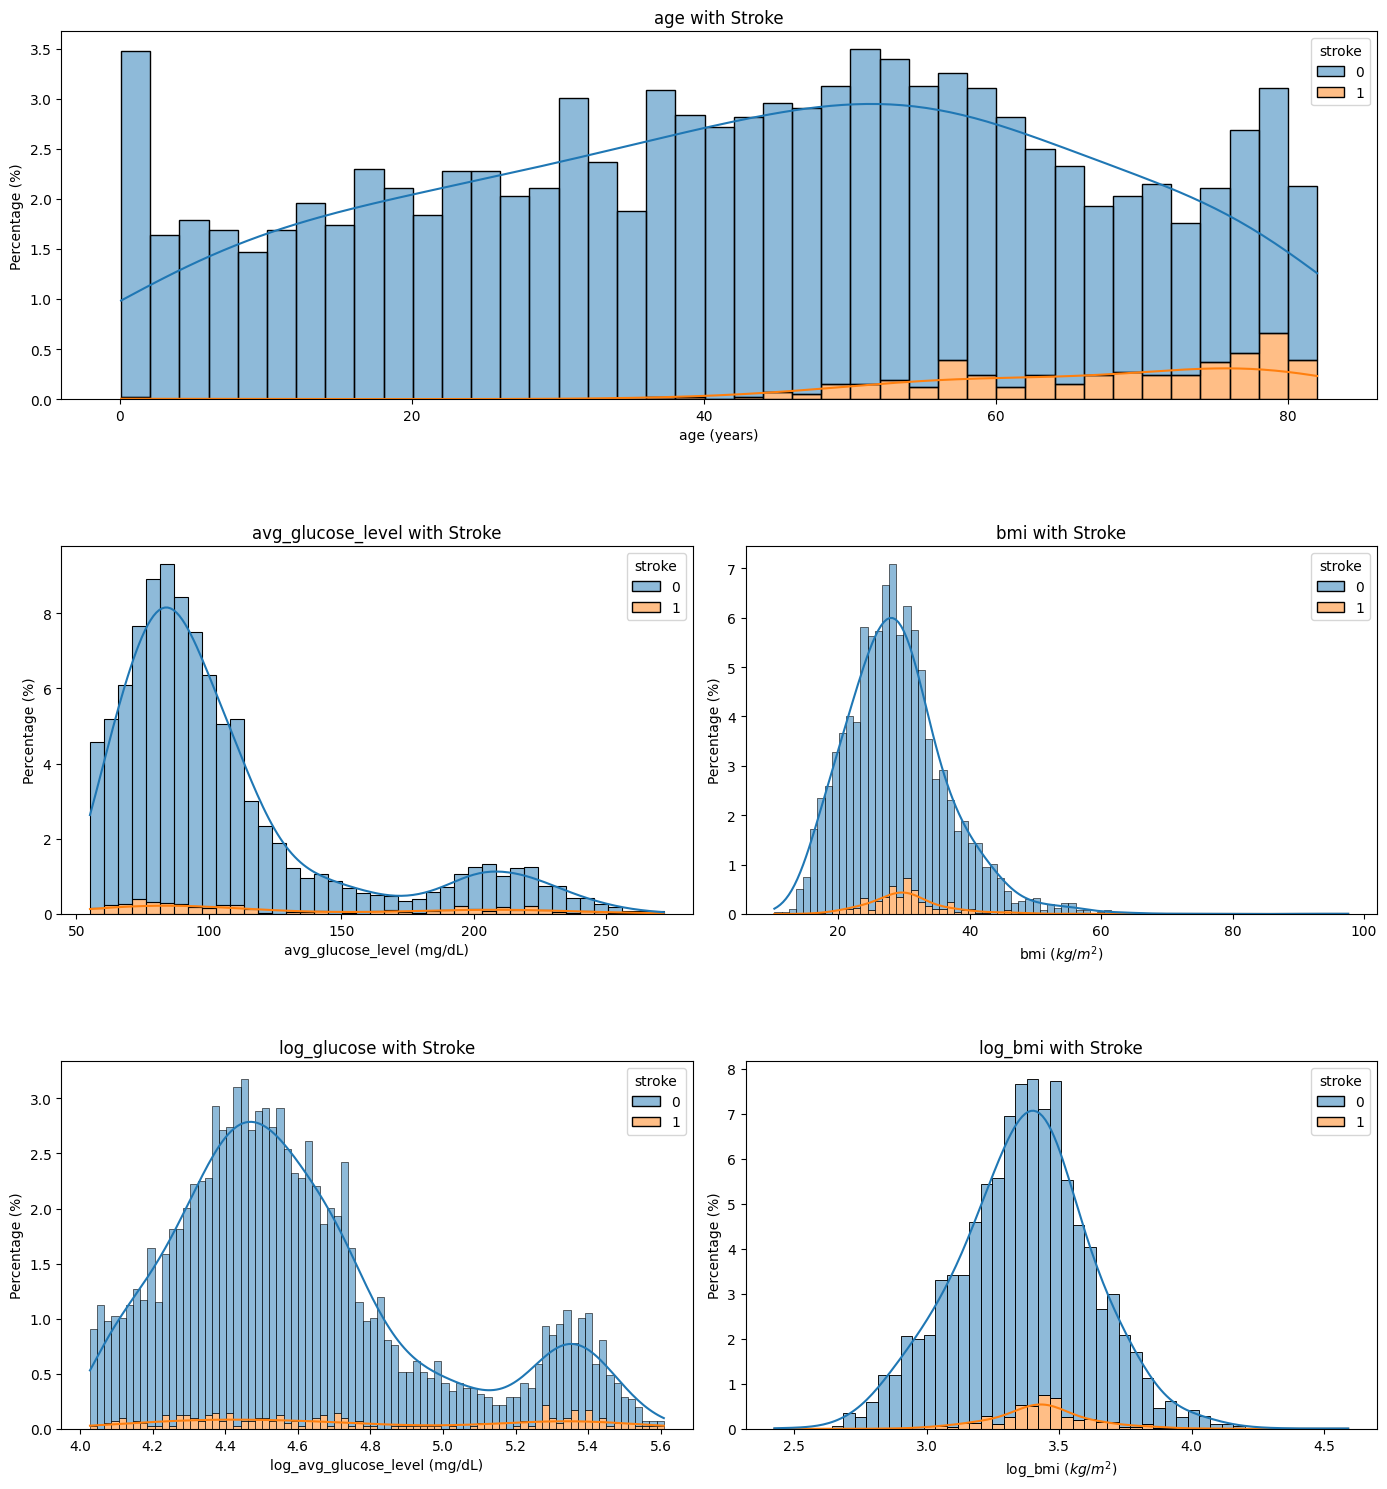

In [ ]:

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(14, 15), gridspec_kw={'height_ratios': [1, 1, 1]})
ax_top = fig.add_subplot(3, 1, 1)
num_dist_ins(train_cleaned, 'age', 41, ax_top, 'age (years)')
axs[0, 1].remove()  
axs[0, 0].remove()

num_dist_ins(train_cleaned, 'avg_glucose_level', 41, axs[1, 0], 'avg_glucose_level (mg/dL)')
num_dist_ins(train_cleaned, 'log_glucose', 80, axs[2, 0], 'log_avg_glucose_level (mg/dL)')
num_dist_ins(train_cleaned, 'bmi', 80, axs[1, 1], 'bmi ($kg/m^2$)')
num_dist_ins(train_cleaned, 'log_bmi', 50, axs[2, 1], 'log_bmi ($kg/m^2$)')
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)  

plt.show()

Observations for numerical variable distributions: 

- Age has a fairly constant distribution, with more people getting strokes at higher ages.

- The average glucose level seems to have a slightly bimodal distribution, where most people have average glucose levels under about 120 mg/dL, and some have higher average glucose levels, around 200-210 mg/dL. 

- Bmi has a unimodal distribution, where most people have bmi ranging from about 24-33 $kg/m^2$. 

### Categorical variable distribution with stroke

Next, the distribution of all variables can be examined, starting with gender and work_type. The ratio noted in the graphs is the ratio of people who have had a stroke out of all people in a given category.

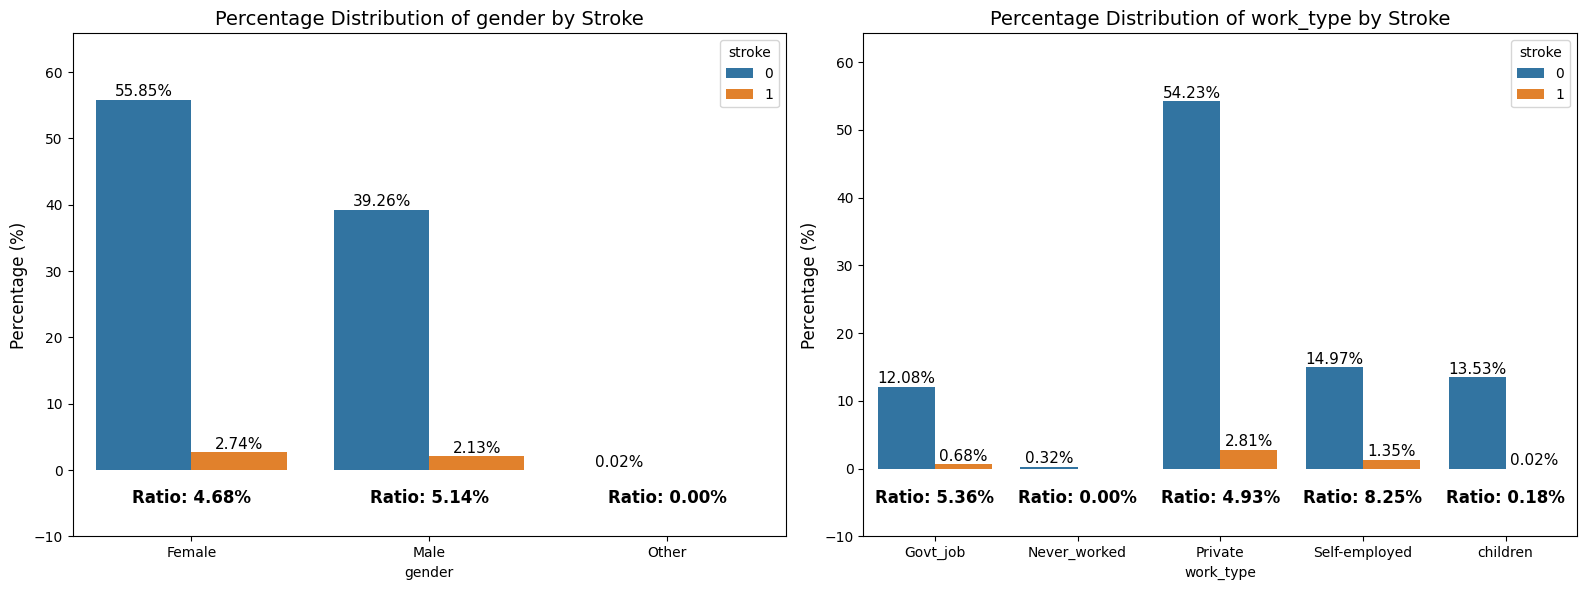

In [ ]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(16, 6))
cat_dist_ins(train_cleaned, 'gender', axs[0])
cat_dist_ins(train_cleaned, 'work_type', axs[1])
plt.tight_layout()

Here, the 'other' gender category has only one entry, and this person did not have a stroke. The test set will be dealt with in the same way:

In [ ]:
train_cleaned = train_cleaned[train_cleaned['gender'] != 'Other']
test_cleaned = test_cleaned[test_cleaned['gender'] != 'Other']

In [ ]:
train_cleaned.head()

,age,bmi,bmi_imputed,id,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,smoking_status,stroke,log_bmi,log_glucose
0,48.0,33.1,0.0,25283,Female,0,0,Yes,Private,Urban,69.21,never smoked,0,3.529297,4.251491
1,15.0,21.0,0.0,43734,Male,0,0,No,Private,Rural,122.25,never smoked,0,3.091042,4.814215
2,67.0,24.9,0.0,47113,Female,0,0,Yes,Self-employed,Rural,110.42,never smoked,0,3.254243,4.713307
3,44.0,24.8,0.0,56996,Male,0,0,Yes,Private,Urban,65.41,smokes,0,3.250374,4.195848
4,14.0,31.6,0.0,26325,Male,0,0,No,Govt_job,Urban,82.34,Unknown,0,3.484312,4.422929


Now, the distribution of all categorical variables can be properly examined:

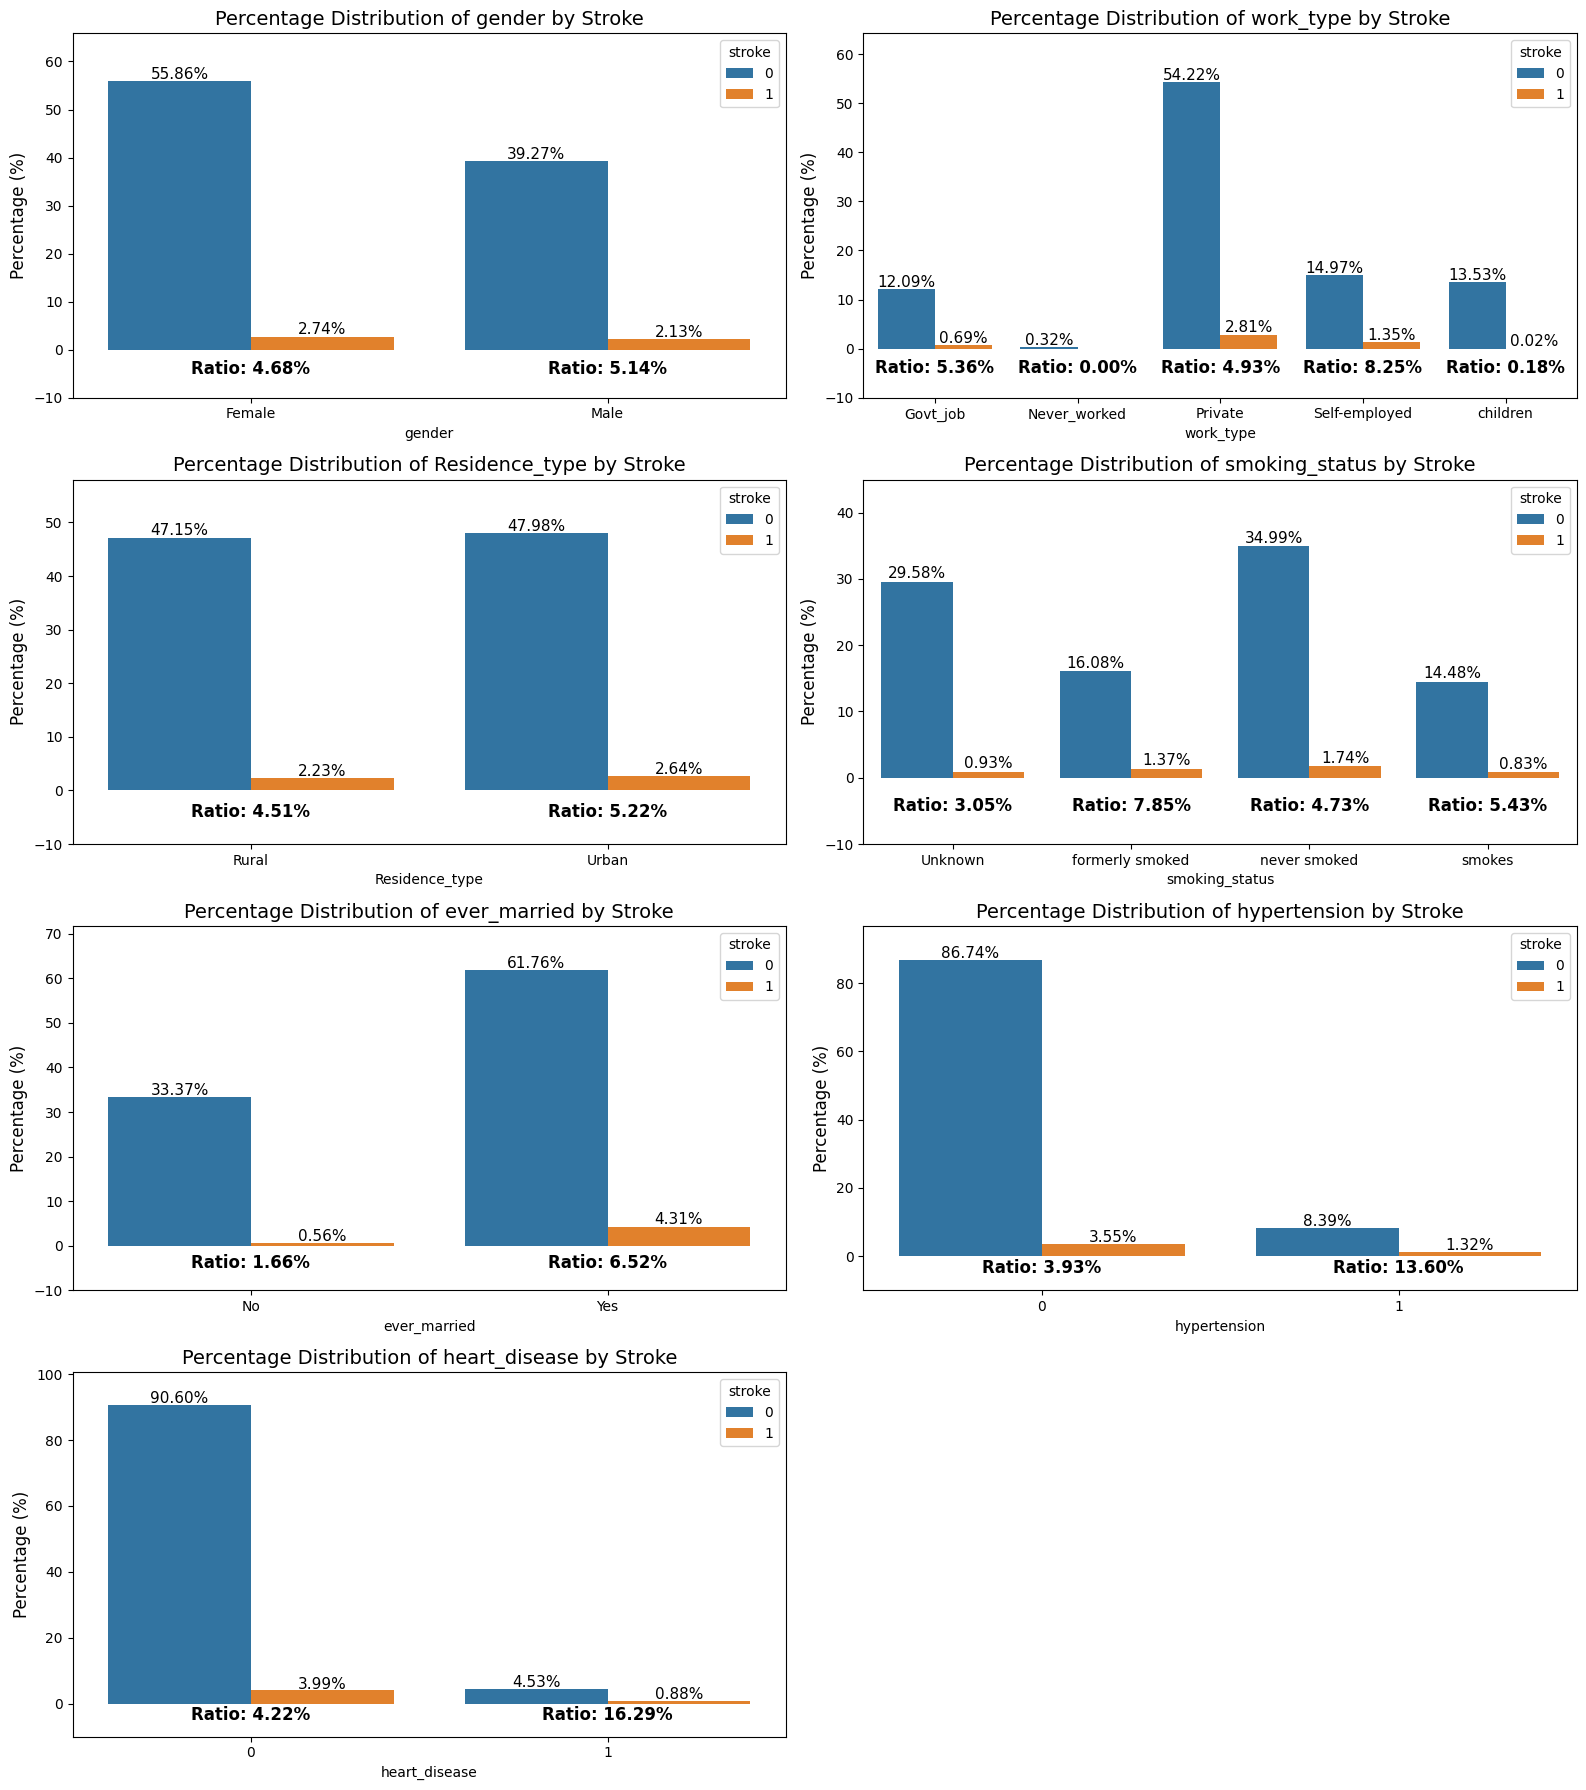

In [ ]:
fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(16, 18))

categories = ['gender', 'work_type', 'Residence_type', 'smoking_status', 'ever_married', 'hypertension', 'heart_disease']
for i, category in enumerate(categories):
    row, col = divmod(i, 2)
    cat_dist_ins(train_cleaned, category, axs[row, col])
fig.delaxes(axs[3, 1])
plt.tight_layout()


Observations: 

Gender: Slightly more females than males are present in this dataset, with about even ratio of getting a stroke in each category. 

Work type: most people work in the private sector, and it seems rare to get a stroke for government workers or children. 

Residence type: similar amounts of people work live in rural and urban areas, and this does not seem to affect the likelihood of getting a stroke. 

Smoking status: most people have never smoked or have unknown smoking status. 

Ever married: most people have been (or are) married, where it seems that more people also have strokes. 

Hypertension: most people do not have hypertension, though a high ratio of stroke (14%) is seen for those who do have hypertension. 

Heart disease: similarly to hypertension, most people do not have heart disease. Those that do also seem at a high risk of having a stroke. 

### Variables together: 

Since variables have been examined individually, some variables can now be examined together, starting with age and smoking status: 

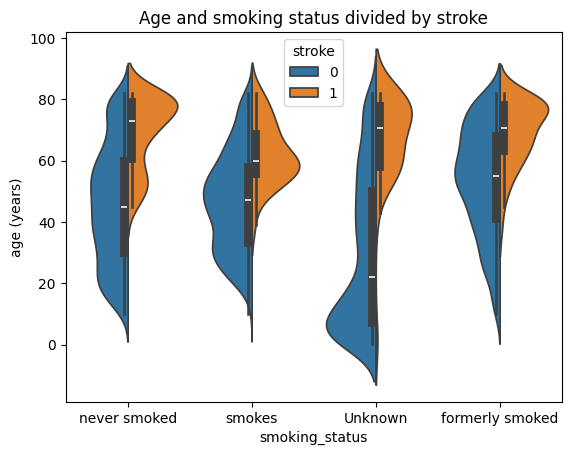

In [ ]:
sns.violinplot(data=train_cleaned, y='age', x='smoking_status', hue='stroke', split=True).set(title='Age and smoking status divided by stroke', ylabel='age (years)');

Looking at age and smoking status together shows that people whose smoking status is unknown generally seem to be younger (under 20 years old) if they have not have a stroke, and higher (over about 60) for those who have had a stroke. In addition, people who smoke seem to have strokes at younger ages (less than about 65) than people in any other smoking category. 

Next, looking at age and hypertension or heart disease divided by stroke: 

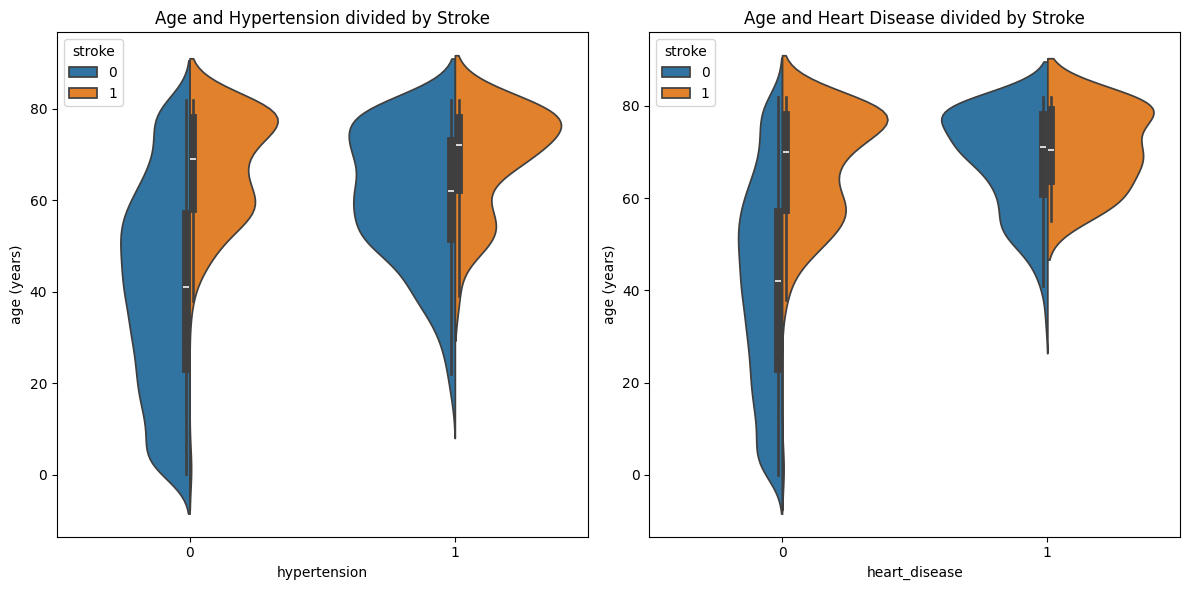

In [ ]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))
sns.violinplot(data=train_cleaned, x='hypertension', y='age', hue='stroke', split=True, ax=axs[0]).set(title='Age and Hypertension divided by Stroke', ylabel='age (years)')
sns.violinplot(data=train_cleaned, x='heart_disease', y='age', hue='stroke', split=True, ax=axs[1]).set(title='Age and Heart Disease divided by Stroke', ylabel='age (years)')
plt.tight_layout()

In general, these graphs show that people who have heart disease or hypertension are older in general than those that do not have these afflictions. In all cases, it is seen that older people have strokes.

Finally, looking at the relationship between age and bmi: 

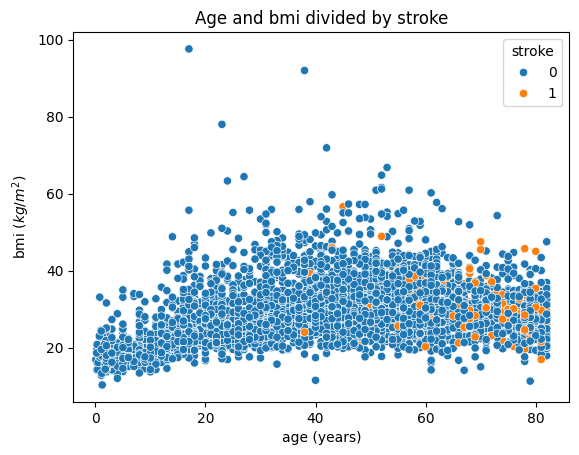

In [ ]:
sns.scatterplot(data=train_cleaned, x='age', y='bmi', hue='stroke').set(title='Age and bmi divided by stroke', ylabel='bmi ($kg/m^2$)', xlabel='age (years)');

This shows again that older patients are more prone to getting strokes. In addition, it seems that younger and older people in general have lower bmi values than older people. Finally, high bmi values (over about 45 $kg/m^2$) seem to be outliers. 

Summary of characteristics: 

In general, this population of people are: 
- Male or female, 
- aged between 0-82, mostly aged between 25-61 (25-75% of the data)
- do not have hypertension or heart disease, 
- have been married, 
- work in the private sector, 
- have (blood) glucose level between about 80-115mg/dL (25-75% of the data), 
- have bmi between about 24-33%, and 
- have not had a stroke. 

From this, people who have had strokes present more frequently with the following characteristics: 
- Are between 55-82 years old, 
- have been married, and
- do have heart disease and/or hypertension.

Another interesting observation is that quite a few imputed bmi values come from people who have had strokes. 

## Correlation between variables:

The 'id' variable is now dropped, as it will not be helpful for stroke prediction. The log-transformed bmi and average glucose level variables will also be kept. Now, the phi-k correlation heatmap can be examined: 

In [ ]:
train_cleaned = train_cleaned.drop(['id'], axis=1)
test_cleaned = test_cleaned.drop(['id'], axis=1)

In [ ]:
train_cleaned.head()

,age,bmi,bmi_imputed,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,smoking_status,stroke,log_bmi,log_glucose
0,48.0,33.1,0.0,Female,0,0,Yes,Private,Urban,69.21,never smoked,0,3.529297,4.251491
1,15.0,21.0,0.0,Male,0,0,No,Private,Rural,122.25,never smoked,0,3.091042,4.814215
2,67.0,24.9,0.0,Female,0,0,Yes,Self-employed,Rural,110.42,never smoked,0,3.254243,4.713307
3,44.0,24.8,0.0,Male,0,0,Yes,Private,Urban,65.41,smokes,0,3.250374,4.195848
4,14.0,31.6,0.0,Male,0,0,No,Govt_job,Urban,82.34,Unknown,0,3.484312,4.422929


Phi-k correlation will now be examined to look at relationships between variables: 

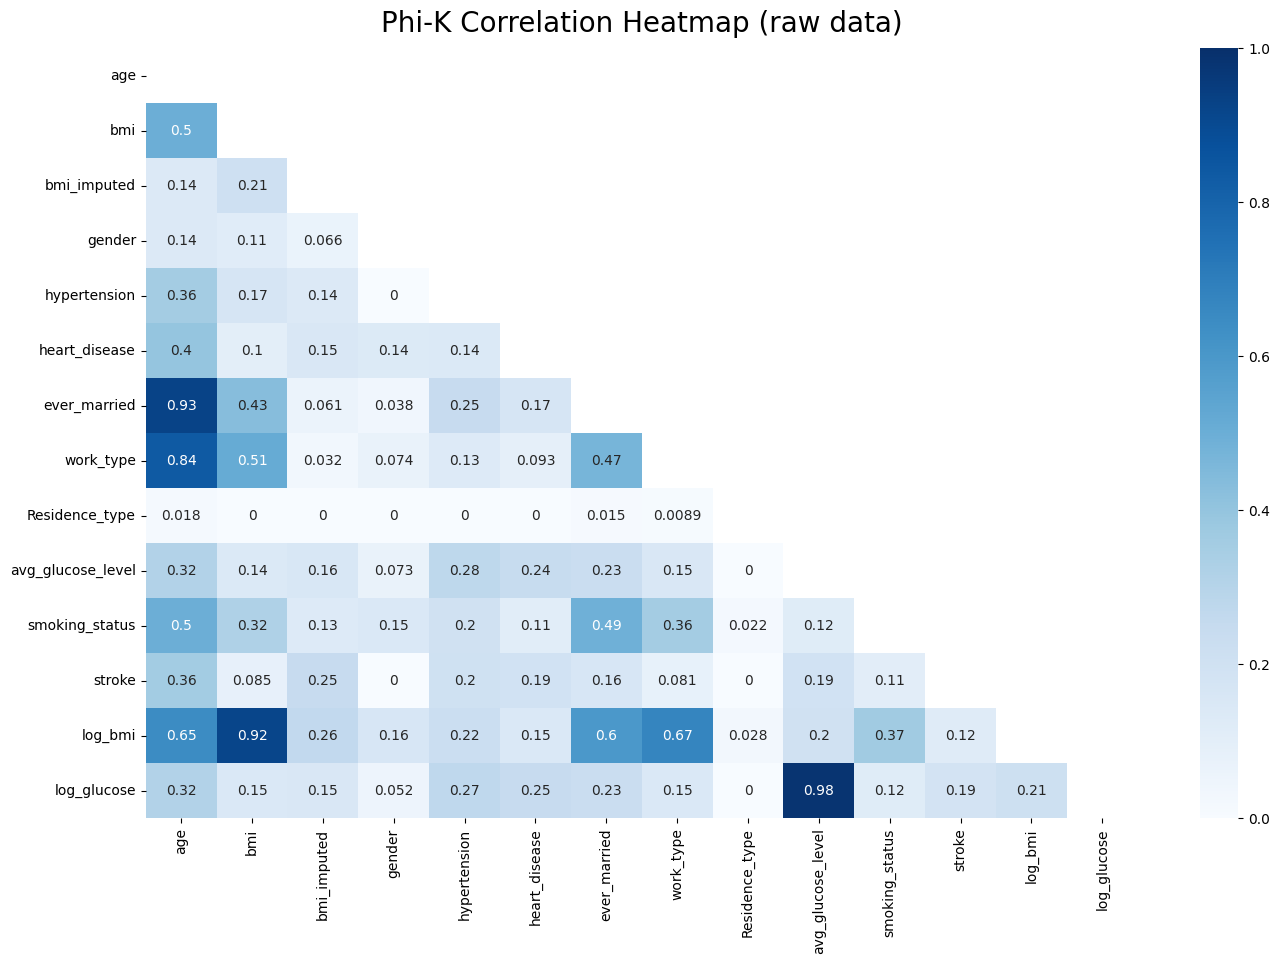

In [ ]:
phik_bins = {
    'gender': 'categorical', 
    'age': 'interval',
    'hypertension': 'categorical',
    'heart_disease': 'categorical', 
    'ever_married': 'categorical', 
    'work_type': 'categorical', 
    'Residence_type': 'categorical', 
    'avg_glucose_level': 'interval', 
    'bmi': 'interval', 
    'log_bmi': 'interval',
    'log_glucose': 'interval',
    'stroke': 'categorical'

}

interval_cols = [col for col, v in phik_bins.items() if v =='interval' and col in train_cleaned]
phik_overview = train_cleaned.phik_matrix(interval_cols=interval_cols)
plt.figure(figsize=(16,10))
mask = np.triu(np.ones_like(phik_overview, dtype=bool))
heatmap = sns.heatmap(phik_overview, annot=True, mask=mask, cmap='Blues', vmin=0, vmax=1)
heatmap.set_title('Phi-K Correlation Heatmap (raw data)', fontdict={'fontsize':20}, pad=12)
plt.show()

From this plot, moderate to strong correlations (phi-k coefficient of over 0.35) can be seen for quite a few variables, especially for 'age' and 'ever_married'. 

Variable pairs with phi-k correlation values of over 0.35 include: 
- age and: 
    - stroke (0.37)
    - smoking_status (0.5)
    - bmi (0.62)
    - work_type (0.76)
    - ever_married (0.93)
    - heart_disease (0.39)
    - hypertension (0.37)
- work_type and ever_married (0.77)
- ever_married and bmi (0.56)
- ever_married and smoking_status (0.5)
- work_type and smoking status (0.64)
- work_type and bmi (0.56)

The age, work_type, and ever_married variables show signs of multicollinearity, which will need to be examined further depending on machine learning models selected for this dataset. 

In order to see the direction of the correlations between variables, spearman correlation can be used. First, all categorical variables will need to be changed into a numerical format, which can be done using one-hot encoding in a pipeline: 

In [ ]:
category_transform = ['gender', 'work_type', 'Residence_type', 'smoking_status', 'ever_married']
num_features = ['age', 'bmi', 'avg_glucose_level', 'log_bmi', 'log_glucose']
passthrough_columns = ['id', 'hypertension', 'heart_disease', 'stroke']

column_transformer = ColumnTransformer([

    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), category_transform), 
], remainder='passthrough')

pipeline = Pipeline([
    ('column_transform', column_transformer)
])

pipeline.fit(train_cleaned)

train_transformed = pipeline.transform(train_cleaned)
test_transformed = pipeline.transform(test_cleaned)

train_encoded = pd.DataFrame(train_transformed, columns=pipeline.named_steps['column_transform'].get_feature_names_out())
test_encoded = pd.DataFrame(test_transformed, columns=pipeline.named_steps['column_transform'].get_feature_names_out())

train_encoded.columns = train_encoded.columns.str.replace('onehot__', '')
train_encoded.columns = train_encoded.columns.str.replace('remainder__', '')
test_encoded.columns = test_encoded.columns.str.replace('onehot__', '')
test_encoded.columns = test_encoded.columns.str.replace('remainder__', '')

for col in train_encoded.columns:
    if col in category_transform:  
        train_encoded[col] = train_encoded[col].astype(int)
        test_encoded[col] = test_encoded[col].astype(int)
    elif col in num_features:  
        train_encoded[col] = train_encoded[col].astype(float)
        test_encoded[col] = test_encoded[col].astype(float)
    elif col in passthrough_columns:  
        train_encoded[col] = train_encoded[col].astype(int)
        test_encoded[col] = test_encoded[col].astype(int)
    else: 
        train_encoded[col] = train_encoded[col].astype(int)
        test_encoded[col] = test_encoded[col].astype(int)

train_encoded.head(5)

,gender_Female,gender_Male,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,...,ever_married_Yes,age,bmi,bmi_imputed,hypertension,heart_disease,avg_glucose_level,stroke,log_bmi,log_glucose
0,1,0,0,0,1,0,0,0,1,0,...,1,48.0,33.1,0,0,0,69.21,0,3.529297,4.251491
1,0,1,0,0,1,0,0,1,0,0,...,0,15.0,21.0,0,0,0,122.25,0,3.091042,4.814215
2,1,0,0,0,0,1,0,1,0,0,...,1,67.0,24.9,0,0,0,110.42,0,3.254243,4.713307
3,0,1,0,0,1,0,0,0,1,0,...,1,44.0,24.8,0,0,0,65.41,0,3.250374,4.195848
4,0,1,1,0,0,0,0,0,1,1,...,0,14.0,31.6,0,0,0,82.34,0,3.484312,4.422929


Now the categorical variables have been encoded, Spearman correlation can be done: 

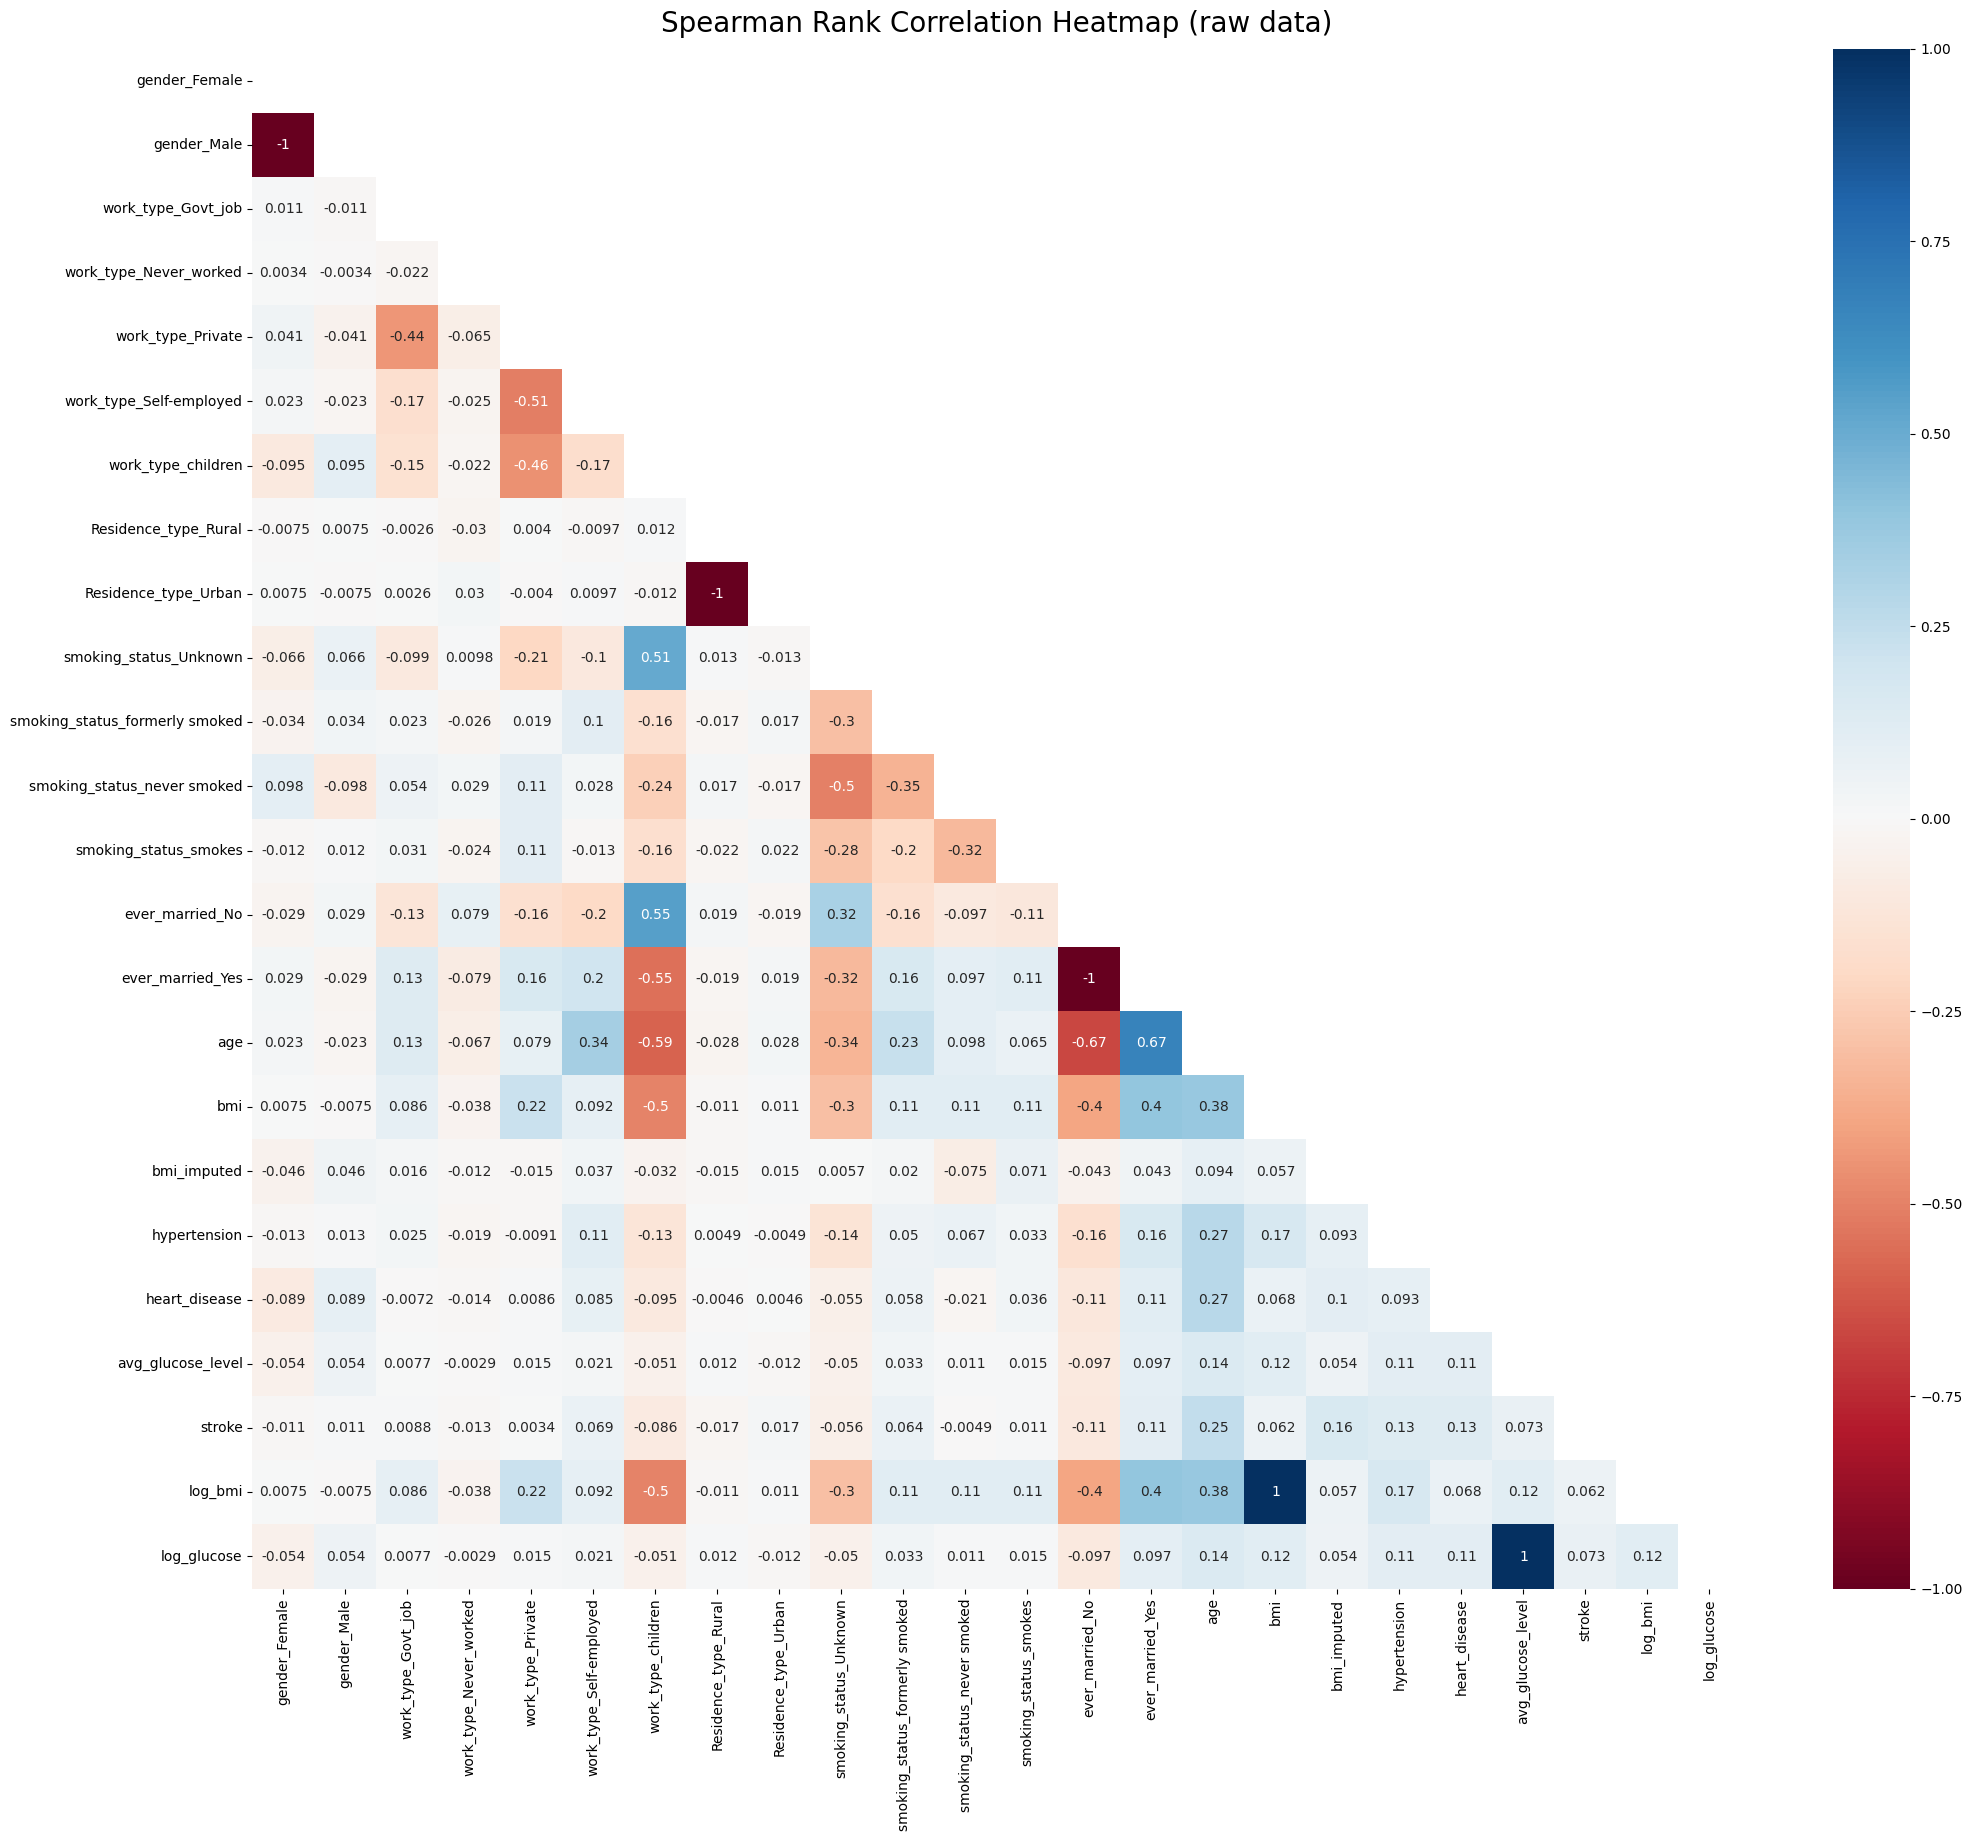

In [ ]:
correlation = train_encoded.corr(method='spearman')

plt.figure(figsize=(24,20))
heatmap = sns.heatmap(correlation, mask=np.triu(correlation, 0), annot=True, cmap='RdBu', vmin=-1, vmax=1)
heatmap.set_title('Spearman Rank Correlation Heatmap (raw data)', fontdict={'fontsize':20}, pad=12)
plt.show()

Spearman correlations: 

In general, spearman correlations agree with trends seen in previous secitons and with the phi-k correlations. More specifically, here is a list of correlated variables with correlation coefficients greater than 0.35: 
- age and ever_married_no (-0.66)
- age and children (-0.59)
- age and bmi (0.37)
- bmi and ever_married (0.39)
- bmi and work_type_children (-0.49)
- work_type_private and work_type_govt_job(-0.44)
- work_type_private and self_employed (-0.51)
- work_type_private and work_type_children (-0.46)
- work_type_children and ever_married (0.55)
- work_type_children and bmi (-0.5)
- work_type_children and age (-0.59)
- work_type_children and ever_married_yes (-0.56)
- work_type_children and smoking_status_unknown (0.51)
- smoking_status_never_smoked and smoking_status_unknown (-0.5)
- smoking_status_formerly_smoked and smoking_status_never_smoked (-0.35)

Since this is quite long, a couple general observations can be made here: 

- Many variables seem to depend on a patient’s age, whether these are health variables (stroke, hypertension, bmi, or heart disease), or lifestyle variables (ever_married, work_type, smoking status). This could be because children are present in this dataset, who generally have different features than adults. 
- The most important variables for stroke prediction seem to be age (higher age associated with slightly higher stroke probability), heart_disease (very slight positive correlation), and hypertension (very slight positive correlation).

# Statistical Inference:

Before implementing machine learning models, some statistical tests are performed to examine the relationship of variables in the dataset with the stroke variable, or to examine any prominent relationships between other variables in this dataset. 

Here, the **target population** is the population of people who are vulnerable to having a stroke. This is a little vague, as the source of this dataset is unknown. For this project, the population could be people in the United States.

## Numerical variables

Numerical variables will first be examined for normality using a QQ plot, and then with a Kolmogoriv-Smirnov test. Then, these will be compared with the stroke variable using either a student t-test or a Mann-Whitney U test, in the case of non-normal data. For all tests, a 95% confidence interval will be used. 


### Normality tests for the distributions: 
- QQ Plot
- Shapiro-Wilk or Kolmogoriv-Smirnov


Starting with numerical variables, and checking for normality for the age variable with a QQ plot: 

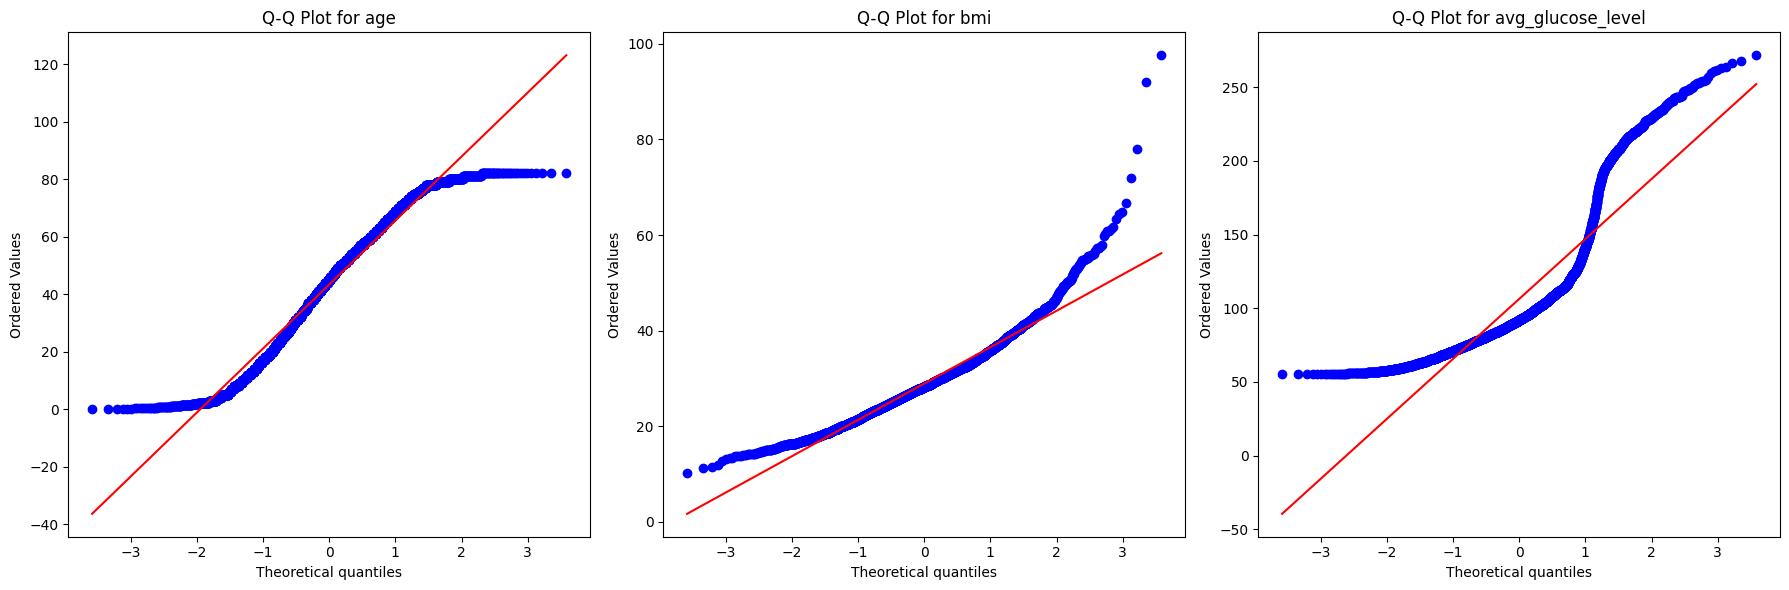

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

plot_qq(train_encoded['age'], axes[0])
plot_qq(train_encoded['bmi'], axes[1])
plot_qq(train_encoded['avg_glucose_level'], axes[2])

plt.tight_layout()
plt.show()

As seen in these plots, none of the numerical variables seem to have completely normal distributions. This can be further corroborated with a Kolmogorov-Smirnov test for normality, as this dataset is larger than 50 samples (otherwise the Shapiro-Wilk test could be used). 

In this case, the **null hypothesis** (H0) is that the distribution is normally distributed. 

The **alternative hypothesis** (Ha) is that the distribution does not follow a normal distribution. 

This will be done at the 95% confidence level. 

In [ ]:
alpha = 0.05
for n in num_features:
    print(n)
    stat, p = kstest(train_encoded[f'{n}'], 'norm')
    print(f"Kolmogorov-Smirnov Test for {n}: p-value = {p}")
    if p < alpha:
        print(f"Reject the null hypothesis; the distribution for {n} is not normally distributed.")
        print()
    else: 
        print(f"Fail to reject the null hypothesis; there is no evidence against normality for the {n} variable.")
        print()

age
Kolmogorov-Smirnov Test for age: p-value = 0.0
Reject the null hypothesis; the distribution for age is not normally distributed.

bmi
Kolmogorov-Smirnov Test for bmi: p-value = 0.0
Reject the null hypothesis; the distribution for bmi is not normally distributed.

avg_glucose_level
Kolmogorov-Smirnov Test for avg_glucose_level: p-value = 0.0
Reject the null hypothesis; the distribution for avg_glucose_level is not normally distributed.

log_bmi
Kolmogorov-Smirnov Test for log_bmi: p-value = 0.0
Reject the null hypothesis; the distribution for log_bmi is not normally distributed.

log_glucose
Kolmogorov-Smirnov Test for log_glucose: p-value = 0.0
Reject the null hypothesis; the distribution for log_glucose is not normally distributed.



### Mann-Whitney U test: 

As seen in the QQ plots for these variables, they cannot be said to be normally distributed. Therefore, Mann-Whitney U tests will be performed for each of these variables to test significance with the stroke variable, as the samples are assumed to be independent. 

For the Mann-Whitney U test, the hypotheses are: 

**Null hypothesis (H0)**: there is no relationship between the numerical variable and whether the patient had a stroke or not (the people who had strokes have the same distribution as those who did not). 

**Alternative hypothesis (Ha)**: there is a statistically significant difference between the distribution for the people who had strokes and the distribution for the people who did not have a stroke. 

In [ ]:
for n in num_features: 
    print(n)
    lower_bound, upper_bound = Mann_Whit(train_encoded, 'stroke', f'{n}')
    print()


age
U-statistic: 128146.5
P-value: 3.532814872074678e-57
Reject the null hypothesis - There is a relationship between stroke and age
95% Confidence Interval for Mann-Whitney U statistic: (111663.65, 145407.12)

bmi
U-statistic: 322914.5
P-value: 8.199837979180865e-05
Reject the null hypothesis - There is a relationship between stroke and bmi
95% Confidence Interval for Mann-Whitney U statistic: (297381.84, 348422.03)

avg_glucose_level
U-statistic: 311407.0
P-value: 3.3638752356801346e-06
Reject the null hypothesis - There is a relationship between stroke and avg_glucose_level
95% Confidence Interval for Mann-Whitney U statistic: (276694.53, 349567.74)

log_bmi
U-statistic: 322914.5
P-value: 8.199837979180865e-05
Reject the null hypothesis - There is a relationship between stroke and log_bmi
95% Confidence Interval for Mann-Whitney U statistic: (298896.54, 347985.88)

log_glucose
U-statistic: 311407.0
P-value: 3.3638752356801346e-06
Reject the null hypothesis - There is a relationship 

In this case, all groups are shown to be different in terms of the sample who have a stroke and those who have not. Therefore, this test can be repeated with alternative='less' to see if the sample of people who have had strokes tend towards larger values than those who have not. 

Now, the **null hypothesis (H0)** is that the distribution of the numerical variable for people who have not had a stroke is greater or equal than the numerical value for people who have had a stroke. 

The **alternative hypothesis (Ha)** is that the numerical variable distribution for people who have not had a stroke tends towards lower values than the numerical value for people who have had a stroke. 

In [ ]:
for n in num_features: 
    print(n)
    lower_bound, upper_bound = Mann_Whit_gr0_less(train_encoded, 'stroke', f'{n}')
    print()

age
U-statistic: 128146.5
P-value: 1.766407436037339e-57
Reject the null hypothesis - the distribution of those without stroke tends towards smaller values than the distribution of those with a stroke.
95% Confidence Interval for Mann-Whitney U statistic: (112367.81, 146069.39)

bmi
U-statistic: 322914.5
P-value: 4.0999189895904324e-05
Reject the null hypothesis - the distribution of those without stroke tends towards smaller values than the distribution of those with a stroke.
95% Confidence Interval for Mann-Whitney U statistic: (296692.47, 348327.84)

avg_glucose_level
U-statistic: 311407.0
P-value: 1.6819376178400673e-06
Reject the null hypothesis - the distribution of those without stroke tends towards smaller values than the distribution of those with a stroke.
95% Confidence Interval for Mann-Whitney U statistic: (277791.51, 343163.69)

log_bmi
U-statistic: 322914.5
P-value: 4.0999189895904324e-05
Reject the null hypothesis - the distribution of those without stroke tends toward

Here, it seems that the sample of people who have strokes is generally older than those without strokes. People with higher bmi values also seem to have strokes more frequently than not, and the average blood glucose level is also found to be higher in people with strokes. This adds some new information to the analysis, as the correlation matrices did not see important correlations between these numerical variables and stroke incidence. 

In each case, the fact that the 95% confidence interval is quite large indicates that the results from the Mann-Whitney U test are reliable, as this is a measure of the frequency of one group having lower values than the other.   

## Chi squared test for categorical variables: 

Categorical variables will be compared with the stroke variable using chi-squared tests, as the dataset is large enough to have at lease 5 observations in each category. In this case, the hypotheses are: 

**Null hypothesis (H0)**: there is no relationship between the categorical variable and whether the patient had a stroke or not. 

**Alternative hypothesis (Ha)**: The corresponding alternative hypothesis is that the categorical variable is related to stroke incidence. 

Getting a list of categorical columns since encoding: 

In [ ]:
cat_cols = train_encoded.columns.tolist()
for n in num_features: 
    if n in cat_cols:
        cat_cols.remove(n)

cat_cols

['gender_Female',
 'gender_Male',
 'work_type_Govt_job',
 'work_type_Never_worked',
 'work_type_Private',
 'work_type_Self-employed',
 'work_type_children',
 'Residence_type_Rural',
 'Residence_type_Urban',
 'smoking_status_Unknown',
 'smoking_status_formerly smoked',
 'smoking_status_never smoked',
 'smoking_status_smokes',
 'ever_married_No',
 'ever_married_Yes',
 'bmi_imputed',
 'hypertension',
 'heart_disease',
 'stroke']

The remaining categorical variables can now be tested against the stroke variable to confirm observations seen in the correlation plots: 

In [ ]:
for c in cat_cols:
    print(c)
    chisq(train_encoded, c, 'stroke')
    print()

gender_Female
contingengy table 
 stroke            0    1
gender_Female           
0              1605   87
1              2283  112
Chi-Squared Statistic: 0.36867382204578214
p-value: 0.5437280375896226
Degrees of Freedom: 1
Fail to reject the null hypothesis - There is no relationship between gender_Female and stroke

gender_Male
contingengy table 
 stroke          0    1
gender_Male           
0            2283  112
1            1605   87
Chi-Squared Statistic: 0.36867382204578214
p-value: 0.5437280375896226
Degrees of Freedom: 1
Fail to reject the null hypothesis - There is no relationship between gender_Male and stroke

work_type_Govt_job
contingengy table 
 stroke                 0    1
work_type_Govt_job           
0                   3394  171
1                    494   28
Chi-Squared Statistic: 0.20578493003262566
p-value: 0.6500913858057751
Degrees of Freedom: 1
Fail to reject the null hypothesis - There is no relationship between work_type_Govt_job and stroke

work_type_Nev

From here, categorical variables that ARE related to stroke incidence are: 
- work_type_Self-employed
- Work_type_children
- Smoking_status_unknown
- smoking_status_formerly_smoked
- smoking_status_smokes
- ever_married_no and ever_married_yes
- Hypertension
- heart_disease

Categorical variables that are NOT related to stroke incidence are: 
- Gender
- work_type_Govt_job
- work_type_Private
- Residence_type
- smoking_status_never smoked

From a chi-squared test alone, it is impossible to tell the strength of the relationship between these variables and stroke incidence. In addition, some of these categorical variables are related to a person's age (ex: children, ever_married), and it has been seen that mostly children had smoking_status_unknown previously. Therefore, some of these relationships between categorical variables and having a stroke could be due to multicollinearity. Indeed, most of the categorical variables found to be related to stroke incidence (ex: ever_married) were not shown to have strong correlations from the heatmaps shown previously. This is important to keep in mind during modelling, and more examination into the strength and direction of association between categorical variables and stroke incidence could be necessary depending on which modeling techniques are chosen. 

From these statistical tests, it is also important to remember that the dataset is very imbalanced in terms of the target variable (95% of the sample has not had a stroke), and therefore the results from the chi-squared tests or Mann-Whitney U tests could be less reliable. 

# Variable preprocessing: 

Before modelling, numerical columns also need to be transformed to have a similar scale to the binary variables, which will be done using standardization.

Futhermore, the dataset must be split into x (features) and y (stroke) variables: 

Now, a pipeine can be implemented again to standardize numerical variables, as they are not on the same scale as each other and have different units: 

In [ ]:
category_transform = ['gender', 'work_type', 'Residence_type', 'smoking_status', 'ever_married']
num_features = ['age', 'bmi', 'avg_glucose_level', 'log_bmi', 'log_glucose']
passthrough_columns = ['hypertension', 'heart_disease', 'stroke']

column_transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), category_transform), 
    ('scaler', StandardScaler(), num_features)

], remainder='passthrough')

pipeline_2 = Pipeline([
    ('column_transform', column_transformer)
])

pipeline_2.fit(train_cleaned)

train_transformed = pipeline_2.transform(train_cleaned)
test_transformed = pipeline_2.transform(test_cleaned)

train_processed = pd.DataFrame(train_transformed, columns=pipeline_2.named_steps['column_transform'].get_feature_names_out())
test_processed = pd.DataFrame(test_transformed, columns=pipeline_2.named_steps['column_transform'].get_feature_names_out())
train_processed.columns = train_processed.columns.str.replace('onehot__', '')
train_processed.columns = train_processed.columns.str.replace('scaler__', '')
train_processed.columns = train_processed.columns.str.replace('remainder__', '')
test_processed.columns = test_processed.columns.str.replace('onehot__', '')
test_processed.columns = train_processed.columns.str.replace('scaler__', '')
test_processed.columns = test_processed.columns.str.replace('remainder__', '')

for col in train_processed.columns:
    if col in num_features:  
        train_processed[col] = train_processed[col].astype(float)
        test_processed[col] = test_processed[col].astype(float)
    else: 
        train_processed[col] = train_processed[col].astype(int)
        test_processed[col] = test_processed[col].astype(int)

train_processed.head()

,gender_Female,gender_Male,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,...,ever_married_Yes,age,bmi,avg_glucose_level,log_bmi,log_glucose,bmi_imputed,hypertension,heart_disease,stroke
0,1,0,0,0,1,0,0,0,1,0,...,1,0.205463,0.532577,-0.819740,0.639751,-0.984661,0,0,0,0
1,0,1,0,0,1,0,0,1,0,0,...,0,-1.255026,-1.019745,0.352261,-1.091279,0.584005,0,0,0,0
2,1,0,0,0,0,1,0,1,0,0,...,1,1.046350,-0.519410,0.090859,-0.446666,0.302711,0,0,0,0
3,0,1,0,0,1,0,0,0,1,0,...,1,0.028434,-0.532239,-0.903707,-0.461946,-1.139774,0,0,0,0
4,0,1,1,0,0,0,0,0,1,1,...,0,-1.299283,0.340140,-0.529612,0.462067,-0.506756,0,0,0,0


Looking at the variable distributions for the training data: 

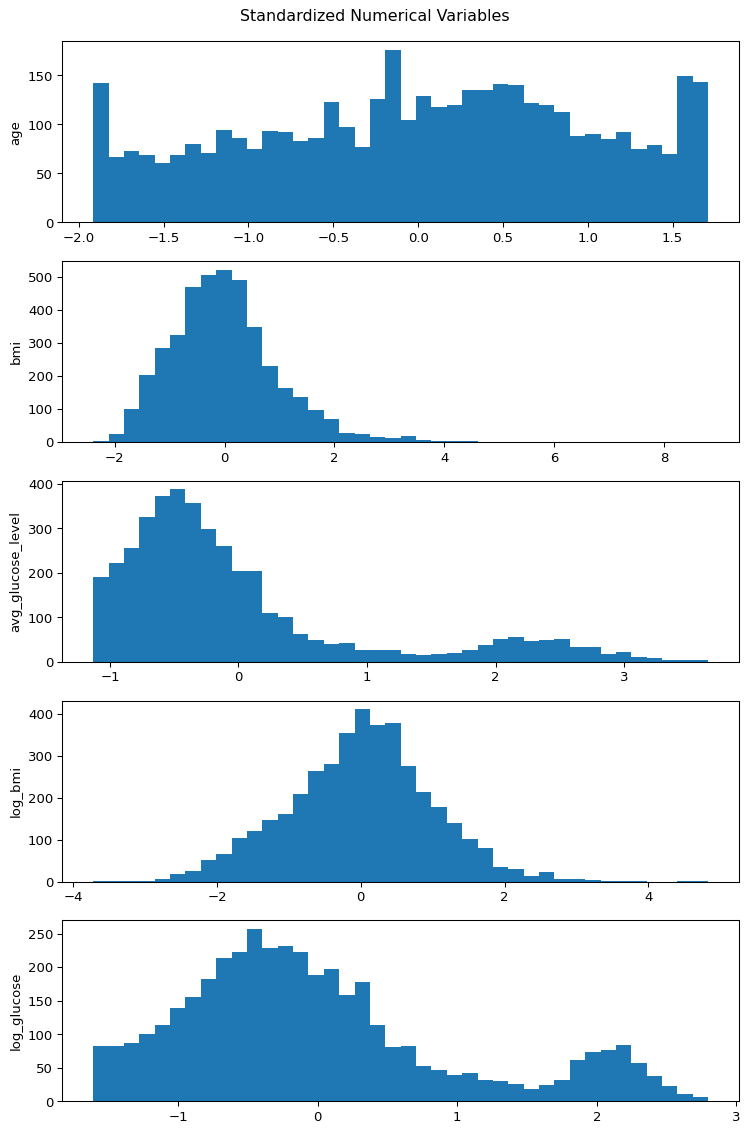

In [ ]:
fig, axs = plt.subplots(5, 1, dpi=95, figsize=(8, 12))
i = 0
for col in train_processed[num_features].columns:
    axs[i].hist(train_processed[col], bins=40)
    axs[i].set_ylabel(col)
    i += 1
fig.suptitle('Standardized Numerical Variables', y=0.99)
fig.tight_layout()
plt.show()

All numerical variables now have a mean of 0 and standard deviation of 1, and all categorical variables have values of 1 or 0. The log transformed data will be used from now on, and x and y variables will be defined: 

In [ ]:
x_train = train_processed.drop(['stroke', 'bmi', 'avg_glucose_level'], axis=1)
y_train = train_processed['stroke'].values.astype(int)
x_test = test_processed.drop(['stroke', 'bmi', 'avg_glucose_level'], axis=1)
y_test = test_processed['stroke'].values.astype(int)


## Checking the variance inflation factor: 

Finally, the variance inflation factor (VIF) is checked to further examine potential multicollinearity. One by one, variables are removed until all VIF levels are under 5. This results in: 


In [ ]:
v = x_train.drop(['work_type_Never_worked', 'smoking_status_formerly smoked', 'gender_Female', 'ever_married_Yes', 'Residence_type_Urban', 'work_type_Private'], axis=1)
vif(v)

,feature,VIF,multicollinearity warning strength
12,bmi_imputed,1.077093,small
11,log_glucose,1.084919,small
14,heart_disease,1.187500,small
1,work_type_Govt_job,1.200647,small
13,hypertension,1.229430,small
7,smoking_status_smokes,1.298078,small
2,work_type_Self-employed,1.376655,small
10,log_bmi,1.464137,small
0,gender_Male,1.614070,small
6,smoking_status_never smoked,1.738694,small


It could be helpful later to define a new x variable (v for training data, vt for test data) that includes only variables with low VIF scores (under 5): 

In [ ]:
v = (x_train.drop(['work_type_Never_worked', 'smoking_status_formerly smoked', 'gender_Female', 'ever_married_Yes', 'Residence_type_Urban', 'work_type_Private'], axis=1))
vt = (x_test.drop(['work_type_Never_worked', 'smoking_status_formerly smoked', 'gender_Female', 'ever_married_Yes', 'Residence_type_Urban', 'work_type_Private'], axis=1))


In [ ]:
v.head()

,gender_Male,work_type_Govt_job,work_type_Self-employed,work_type_children,Residence_type_Rural,smoking_status_Unknown,smoking_status_never smoked,smoking_status_smokes,ever_married_No,age,log_bmi,log_glucose,bmi_imputed,hypertension,heart_disease
0,0,0,0,0,0,0,1,0,0,0.205463,0.639751,-0.984661,0,0,0
1,1,0,0,0,1,0,1,0,1,-1.255026,-1.091279,0.584005,0,0,0
2,0,0,1,0,1,0,1,0,0,1.046350,-0.446666,0.302711,0,0,0
3,1,0,0,0,0,0,0,1,0,0.028434,-0.461946,-1.139774,0,0,0
4,1,1,0,0,0,1,0,0,1,-1.299283,0.462067,-0.506756,0,0,0


# Model implementation

Modeling techniques can now be used to try and predict whether a person will get a stroke or not. In general, all features will be used for each model to establish a baseline.

In terms of modeling, 4 outcomes are possible: 
- True positive: Model predicts stroke when the person did get a stroke.
- False positive: Model predicts stroke when the person did not get a stroke. 
- True negative: Model predicts no stroke when the person did not get a stroke. 
- False negative: Model predicts no stroke when the person did get a stroke.

For this problem, the priority is to not miss any people that did get a stroke. Therefore, getting the lowest false negative rate possible will be the focus of modelling techniques. It is less important that the false positive rate is as accurate, as the person's health would not be compromised. 

As the data is imbalanced, where most customers do not have strokes, metrics used to compare models will be: 
- accuracy: this represents the amount of accurate predictions of the model over the number of innacurate predictions. 
- balanced accuracy: this measure of accuracy gives equal importances to each class.
- recall: defined as the number of true positives over the sum of true positives and false negatives. 
- precision: defined as the numvber of true positives over the sum of true positives and false positives. 
- weighted F1 score: This value corrects for class imbalance by taking precision and recall's weighted harmonic mean. This ranges from 0-1, where higher values show a better model performance. 
- F2 score: This is similar to the F1 score, but gives priiority to recall over precision. 
- PR-AUC: this is the area under the precision recall curve and is a measure of the goodnes of balance for precision and recall for the model. Again, values closer to 1 indicate better model performance.  
- MCC: Matthews Correlation Coefficient, which is a helpful metric for imbalanced datasets. This takes all instances of the confusion matrix into account to tell how well the model is able to predict the y values, and ranges from -1 (model does not agree with data labels) to 1 (the model correctly labelled all data). 


Finding the class weights and the scale_pos_weight parameter for an xgboost model: 

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

class_counts = np.bincount(y_train)
class_prior = class_counts / len(y_train)

spw = sum(y_train == 0) / sum(y_train == 1)

Initial model selection: 

Basic models, random forest models, and gradient boosted models are selected initially. Class weights are used as initial parameters in these models, as the dataset is highly imbalanced. 

Initial models to be used: 
- Dummy model used as a base model. 
- logistic regression
- decision tree
- support vector machine (SVM)
- k-nearest neighbors (KNN)
- naive bayes model 

Ensemble and gradient boosted models: 
- Random Forest and Balanced Random Forest
- Gradient boosting and HistGradient boosting, which has support for defining class weights. 
- xgboost
- adaboost using a decision tree classifier
- lightgbm
- balanced bagging using a decision tree classifier

These can go into a dictionary: 

In [ ]:
models_initial_imbalanced = {
    'Dummy': DummyClassifier(strategy='most_frequent'),
    'Logistic Regression': LogisticRegression(random_state=42, class_weight=class_weight_dict, max_iter=7000),
    'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight=class_weight_dict),
    'SVM': SVC(class_weight=class_weight_dict, probability=True),
    'KNN': KNeighborsClassifier(n_neighbors=5, weights='distance'),
    'Naive Bayes': GaussianNB(priors=class_prior),
    'Random Forest': RandomForestClassifier(class_weight=class_weight_dict, random_state=42),
    'Balanced Random Forest': BalancedRandomForestClassifier(random_state=42, class_weight=class_weight_dict),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'hist_gradient_boosting': HistGradientBoostingClassifier(random_state=42, class_weight=class_weight_dict),
    'XGBoost': XGBClassifier(scale_pos_weight=spw, random_state=42, eval_metric='aucpr'),
    'Adaboost': AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight=class_weight_dict),
    random_state=42),
    'lightgbm': LGBMClassifier(random_state=42, class_weight=class_weight_dict, is_unbalance=True, objective='binary', metric='aucpr'),
    'Balanced Bagging': BalancedBaggingClassifier(estimator=DecisionTreeClassifier(class_weight=class_weight_dict),
    random_state=42)
}

Preparing cross validation: 

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


## Initial Model evaluation: 

Evaluating the initial models: 

In [ ]:
r = get_results(models_initial_imbalanced, x_train, y_train, cv)

In [ ]:
r.sort_values(by='MCC', ascending=False)

,Model,accuracy,balanced accuracy,average precision,recall,weighted f1,f2,PR AUC,MCC
1,Logistic Regression,0.7517 ± 0.0175,0.7740 ± 0.0230,0.1227 ± 0.0131,0.7517 ± 0.0175,0.8217 ± 0.0121,0.7688 ± 0.0159,0.1227 ± 0.0131,0.2640 ± 0.0264
12,lightgbm,0.8564 ± 0.0042,0.6812 ± 0.0281,0.1069 ± 0.0153,0.8564 ± 0.0042,0.8879 ± 0.0031,0.8665 ± 0.0037,0.1069 ± 0.0153,0.2231 ± 0.0332
7,Balanced Random Forest,0.7942 ± 0.0134,0.7106 ± 0.0302,0.1051 ± 0.0141,0.7942 ± 0.0134,0.8494 ± 0.0089,0.8100 ± 0.0121,0.1051 ± 0.0141,0.2201 ± 0.0326
3,SVM,0.7663 ± 0.0195,0.7005 ± 0.0303,0.0969 ± 0.0122,0.7663 ± 0.0195,0.8309 ± 0.0131,0.7844 ± 0.0182,0.0969 ± 0.0122,0.2008 ± 0.0306
9,hist_gradient_boosting,0.9078 ± 0.0042,0.6082 ± 0.0062,0.0882 ± 0.0044,0.9078 ± 0.0042,0.9157 ± 0.0025,0.9108 ± 0.0036,0.0882 ± 0.0044,0.1822 ± 0.0110
8,Gradient Boosting,0.9513 ± 0.0014,0.5309 ± 0.0164,0.0814 ± 0.0175,0.9513 ± 0.0014,0.9330 ± 0.0025,0.9436 ± 0.0015,0.0814 ± 0.0175,0.1673 ± 0.0597
13,Balanced Bagging,0.8131 ± 0.0189,0.6442 ± 0.0224,0.0828 ± 0.0092,0.8131 ± 0.0189,0.8600 ± 0.0119,0.8280 ± 0.0170,0.0828 ± 0.0092,0.1611 ± 0.0256
5,Naive Bayes,0.3727 ± 0.0337,0.6559 ± 0.0178,0.0697 ± 0.0032,0.3727 ± 0.0337,0.4897 ± 0.0393,0.3876 ± 0.0369,0.0697 ± 0.0032,0.1432 ± 0.0131
2,Decision Tree,0.9215 ± 0.0055,0.5487 ± 0.0245,0.0653 ± 0.0118,0.9215 ± 0.0055,0.9191 ± 0.0044,0.9205 ± 0.0049,0.0653 ± 0.0118,0.1026 ± 0.0522
10,XGBoost,0.9207 ± 0.0070,0.5460 ± 0.0247,0.0642 ± 0.0104,0.9207 ± 0.0070,0.9185 ± 0.0057,0.9198 ± 0.0064,0.0642 ± 0.0104,0.0980 ± 0.0522


When sorted by accuracy, recall, and weighted F2 scores, the dummy model, KNN model, and random forest model perform the best. This is not a great sign, as it indicates that random guessing performs better in these categories than the machine learning models. This is likely due to the imbalance in the dataset. 

When sorted by all other metrics, the logistic regression, lightgbm, and balanced random forest models perform the best. The support vector machine and naive bayes models also perform well in these categories. 

## Dataset with multicollinearity removed evaluation: 

For models such as logistic regression, multicollinearity is an issue. Therefore, let's try testing models with the set of features that all have low VIF scores: 

In [ ]:
rv = get_results(models_initial_imbalanced, v, y_train, cv)

In [ ]:
rv.sort_values(by='MCC', ascending=False)

,Model,accuracy,balanced accuracy,average precision,recall,weighted f1,f2,PR AUC,MCC
1,Logistic Regression,0.7519 ± 0.0175,0.7742 ± 0.0230,0.1228 ± 0.0131,0.7519 ± 0.0175,0.8219 ± 0.0122,0.7690 ± 0.0160,0.1228 ± 0.0131,0.2642 ± 0.0263
12,lightgbm,0.8588 ± 0.0034,0.7041 ± 0.0098,0.1186 ± 0.0058,0.8588 ± 0.0034,0.8901 ± 0.0023,0.8686 ± 0.0030,0.1186 ± 0.0058,0.2500 ± 0.0121
7,Balanced Random Forest,0.7976 ± 0.0186,0.7268 ± 0.0424,0.1135 ± 0.0217,0.7976 ± 0.0186,0.8518 ± 0.0126,0.8128 ± 0.0167,0.1135 ± 0.0217,0.2376 ± 0.0468
5,Naive Bayes,0.7515 ± 0.1740,0.6902 ± 0.0304,0.1008 ± 0.0195,0.7515 ± 0.1740,0.8065 ± 0.1412,0.7644 ± 0.1720,0.1008 ± 0.0195,0.2112 ± 0.0413
3,SVM,0.7683 ± 0.0183,0.7016 ± 0.0374,0.0979 ± 0.0159,0.7683 ± 0.0183,0.8322 ± 0.0124,0.7862 ± 0.0169,0.0979 ± 0.0159,0.2024 ± 0.0383
13,Balanced Bagging,0.8163 ± 0.0147,0.6626 ± 0.0218,0.0894 ± 0.0071,0.8163 ± 0.0147,0.8624 ± 0.0089,0.8306 ± 0.0135,0.0894 ± 0.0071,0.1809 ± 0.0188
9,hist_gradient_boosting,0.9070 ± 0.0046,0.5958 ± 0.0184,0.0822 ± 0.0117,0.9070 ± 0.0046,0.9145 ± 0.0035,0.9099 ± 0.0042,0.0822 ± 0.0117,0.1634 ± 0.0329
8,Gradient Boosting,0.9506 ± 0.0023,0.5281 ± 0.0167,0.0774 ± 0.0260,0.9506 ± 0.0023,0.9322 ± 0.0032,0.9429 ± 0.0024,0.0774 ± 0.0260,0.1474 ± 0.0772
10,XGBoost,0.9210 ± 0.0082,0.5580 ± 0.0204,0.0690 ± 0.0133,0.9210 ± 0.0082,0.9197 ± 0.0054,0.9204 ± 0.0070,0.0690 ± 0.0133,0.1208 ± 0.0436
11,Adaboost,0.9171 ± 0.0084,0.5536 ± 0.0282,0.0677 ± 0.0154,0.9171 ± 0.0084,0.9172 ± 0.0071,0.9171 ± 0.0079,0.0677 ± 0.0154,0.1089 ± 0.0603


Now, comparing this result with those from the original data: 

In [ ]:
rv.sort_values(by='MCC', ascending=False).iloc[[0, 1, 2, 3]]

,Model,accuracy,balanced accuracy,average precision,recall,weighted f1,f2,PR AUC,MCC
1,Logistic Regression,0.7519 ± 0.0175,0.7742 ± 0.0230,0.1228 ± 0.0131,0.7519 ± 0.0175,0.8219 ± 0.0122,0.7690 ± 0.0160,0.1228 ± 0.0131,0.2642 ± 0.0263
12,lightgbm,0.8588 ± 0.0034,0.7041 ± 0.0098,0.1186 ± 0.0058,0.8588 ± 0.0034,0.8901 ± 0.0023,0.8686 ± 0.0030,0.1186 ± 0.0058,0.2500 ± 0.0121
7,Balanced Random Forest,0.7976 ± 0.0186,0.7268 ± 0.0424,0.1135 ± 0.0217,0.7976 ± 0.0186,0.8518 ± 0.0126,0.8128 ± 0.0167,0.1135 ± 0.0217,0.2376 ± 0.0468
5,Naive Bayes,0.7515 ± 0.1740,0.6902 ± 0.0304,0.1008 ± 0.0195,0.7515 ± 0.1740,0.8065 ± 0.1412,0.7644 ± 0.1720,0.1008 ± 0.0195,0.2112 ± 0.0413


In [ ]:
r.sort_values(by='MCC', ascending=False).iloc[[0, 1, 2, 3]]

,Model,accuracy,balanced accuracy,average precision,recall,weighted f1,f2,PR AUC,MCC
1,Logistic Regression,0.7517 ± 0.0175,0.7740 ± 0.0230,0.1227 ± 0.0131,0.7517 ± 0.0175,0.8217 ± 0.0121,0.7688 ± 0.0159,0.1227 ± 0.0131,0.2640 ± 0.0264
12,lightgbm,0.8564 ± 0.0042,0.6812 ± 0.0281,0.1069 ± 0.0153,0.8564 ± 0.0042,0.8879 ± 0.0031,0.8665 ± 0.0037,0.1069 ± 0.0153,0.2231 ± 0.0332
7,Balanced Random Forest,0.7942 ± 0.0134,0.7106 ± 0.0302,0.1051 ± 0.0141,0.7942 ± 0.0134,0.8494 ± 0.0089,0.8100 ± 0.0121,0.1051 ± 0.0141,0.2201 ± 0.0326
3,SVM,0.7663 ± 0.0195,0.7005 ± 0.0303,0.0969 ± 0.0122,0.7663 ± 0.0195,0.8309 ± 0.0131,0.7844 ± 0.0182,0.0969 ± 0.0122,0.2008 ± 0.0306


Both results are similar. 

Overall, it seems that the logistic regression model performs the best for most metrics (balanced accuracy, recall, pr-auc, MCC), followed by the lightgbm model, the balanced random forest model and then the support vector machine (original variables) or naive bayes (vif selected variables). 

As the goal is to minimize false negatives, models that maximize recall, pr-auc, and MCC are prioritized. These models (logistic regression, lightgbm, and balanced random forest) will be tuned using Bayesian oprimization and further evaluated with the data that does not induce multicollinearity (model results rv). 

These will be compared using a best_models dataframe: 

In [ ]:
best_models = rv.sort_values(by='MCC', ascending=False).iloc[[0, 1, 2, 3]]
best_models

,Model,accuracy,balanced accuracy,average precision,recall,weighted f1,f2,PR AUC,MCC
1,Logistic Regression,0.7519 ± 0.0175,0.7742 ± 0.0230,0.1228 ± 0.0131,0.7519 ± 0.0175,0.8219 ± 0.0122,0.7690 ± 0.0160,0.1228 ± 0.0131,0.2642 ± 0.0263
12,lightgbm,0.8588 ± 0.0034,0.7041 ± 0.0098,0.1186 ± 0.0058,0.8588 ± 0.0034,0.8901 ± 0.0023,0.8686 ± 0.0030,0.1186 ± 0.0058,0.2500 ± 0.0121
7,Balanced Random Forest,0.7976 ± 0.0186,0.7268 ± 0.0424,0.1135 ± 0.0217,0.7976 ± 0.0186,0.8518 ± 0.0126,0.8128 ± 0.0167,0.1135 ± 0.0217,0.2376 ± 0.0468
5,Naive Bayes,0.7515 ± 0.1740,0.6902 ± 0.0304,0.1008 ± 0.0195,0.7515 ± 0.1740,0.8065 ± 0.1412,0.7644 ± 0.1720,0.1008 ± 0.0195,0.2112 ± 0.0413


## Hyperparameter Tuning: 

Defining a scoring dictionary: 

In [ ]:
scoring = {
    'recall': make_scorer(recall_score, average='weighted'),
    'accuracy': make_scorer(accuracy_score),
    'weighted_f1': make_scorer(f1_score, average='weighted'),
    'f2': make_scorer(fbeta_score, beta=2, average='weighted'),
    'roc_auc': make_scorer(roc_auc_score),
    'average_precision': make_scorer(average_precision_score),
    'mcc': make_scorer(matthews_corrcoef), 
    'pr_auc': make_scorer(average_precision_score, average="macro"),
    'mcc' : make_scorer(matthews_corrcoef),
    'balanced_accuracy' : make_scorer(balanced_accuracy_score)
    }

### Logistic regression hyperparameter tuning: 

In [ ]:
param_space_liblinear = {
    'C': Real(0.001, 100, prior='log-uniform'), 
    'penalty': Categorical(['l1', 'l2']),  
    'solver': Categorical(['liblinear']),
    'class_weight': Categorical(['balanced', None])
}

param_space_saga = {
    'C': Real(0.001, 100, prior='log-uniform'),  
    'penalty': Categorical(['elasticnet']),  
    'solver': Categorical(['saga']),  
    'l1_ratio': Real(0.1, 0.9),
    'class_weight': Categorical(['balanced', None])

}

log_reg = LogisticRegression(max_iter=7000, class_weight=class_weight_dict, random_state=42)
best_log_reg_lib = bayes_hyperparam_tuning(log_reg, v, y_train, param_space_liblinear)
best_log_reg_saga = bayes_hyperparam_tuning(log_reg, v, y_train, param_space_saga)

new_row_base = get_results({'best_log_reg_lib': best_log_reg_lib}, v, y_train, cv)
best_models = pd.concat([best_models, new_row_base], ignore_index=True)
new_row_base = get_results({'best_log_reg_saga': best_log_reg_saga}, v, y_train, cv)
best_models = pd.concat([best_models, new_row_base], ignore_index=True)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [ ]:
best_models.sort_values(by='MCC', ascending=False)

,Model,accuracy,balanced accuracy,average precision,recall,weighted f1,f2,PR AUC,MCC
5,best_log_reg_saga,0.7499 ± 0.0175,0.7803 ± 0.0180,0.1246 ± 0.0111,0.7499 ± 0.0175,0.8206 ± 0.0121,0.7670 ± 0.0162,0.1246 ± 0.0111,0.2690 ± 0.0215
4,best_log_reg_lib,0.7507 ± 0.0176,0.7783 ± 0.0217,0.1241 ± 0.0123,0.7507 ± 0.0176,0.8211 ± 0.0122,0.7677 ± 0.0162,0.1241 ± 0.0123,0.2675 ± 0.0244
0,Logistic Regression,0.7519 ± 0.0175,0.7742 ± 0.0230,0.1228 ± 0.0131,0.7519 ± 0.0175,0.8219 ± 0.0122,0.7690 ± 0.0160,0.1228 ± 0.0131,0.2642 ± 0.0263
1,lightgbm,0.8588 ± 0.0034,0.7041 ± 0.0098,0.1186 ± 0.0058,0.8588 ± 0.0034,0.8901 ± 0.0023,0.8686 ± 0.0030,0.1186 ± 0.0058,0.2500 ± 0.0121
2,Balanced Random Forest,0.7976 ± 0.0186,0.7268 ± 0.0424,0.1135 ± 0.0217,0.7976 ± 0.0186,0.8518 ± 0.0126,0.8128 ± 0.0167,0.1135 ± 0.0217,0.2376 ± 0.0468
3,Naive Bayes,0.7515 ± 0.1740,0.6902 ± 0.0304,0.1008 ± 0.0195,0.7515 ± 0.1740,0.8065 ± 0.1412,0.7644 ± 0.1720,0.1008 ± 0.0195,0.2112 ± 0.0413


The liblinear solver gives the best results for logistic regression in terms of accuracy, recall, f1, and f2 scores, while the saga solver is best for other metrics. The saga solver will be used from here. 

Next, the lightgbm and balanced random forest models will be tuned for stacking purposes: 

### Hyperparameter tuning for lightgbm: 

In [ ]:
param_space_lgbm = {
    'n_estimators': (100, 300),
    'max_depth': (1, 15),
    'num_leaves': (10, 200),
    'learning_rate': (0.01, 0.3),
    'min_child_samples': (5, 50),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'lambda_l1': (0.0, 10.0),  
    'lambda_l2': (0.0, 10.0),  
    'class_weight': ['balanced', None]
}

lgbm = LGBMClassifier(random_state=42, verbose=-1)
bayes_search = BayesSearchCV(
    estimator=lgbm,
    search_spaces=param_space_lgbm,
    n_iter=50,
    cv=cv,
    scoring="matthews_corrcoef",
    n_jobs=-1,
    verbose=0,
    random_state=42
)
bayes_search.fit(v, y_train)
print("Best Parameters:", bayes_search.best_params_)
best_lgbm = bayes_search.best_estimator_

new_row_base = get_results({'best_lgbm': best_lgbm}, v, y_train, cv)
best_models = pd.concat([best_models, new_row_base], ignore_index=True)

Best Parameters: OrderedDict({'class_weight': 'balanced', 'colsample_bytree': 0.8432301555390882, 'lambda_l1': 10.0, 'lambda_l2': 10.0, 'learning_rate': 0.3, 'max_depth': 12, 'min_child_samples': 25, 'n_estimators': 100, 'num_leaves': 55, 'subsample': 1.0})


In [ ]:
best_models.sort_values(by='PR AUC', ascending=False)

,Model,accuracy,balanced accuracy,average precision,recall,weighted f1,f2,PR AUC,MCC
5,best_log_reg_saga,0.7499 ± 0.0175,0.7803 ± 0.0180,0.1246 ± 0.0111,0.7499 ± 0.0175,0.8206 ± 0.0121,0.7670 ± 0.0162,0.1246 ± 0.0111,0.2690 ± 0.0215
4,best_log_reg_lib,0.7507 ± 0.0176,0.7783 ± 0.0217,0.1241 ± 0.0123,0.7507 ± 0.0176,0.8211 ± 0.0122,0.7677 ± 0.0162,0.1241 ± 0.0123,0.2675 ± 0.0244
6,best_lgbm,0.8099 ± 0.0099,0.7475 ± 0.0201,0.1241 ± 0.0103,0.8099 ± 0.0099,0.8601 ± 0.0062,0.8237 ± 0.0090,0.1241 ± 0.0103,0.2629 ± 0.0208
0,Logistic Regression,0.7519 ± 0.0175,0.7742 ± 0.0230,0.1228 ± 0.0131,0.7519 ± 0.0175,0.8219 ± 0.0122,0.7690 ± 0.0160,0.1228 ± 0.0131,0.2642 ± 0.0263
1,lightgbm,0.8588 ± 0.0034,0.7041 ± 0.0098,0.1186 ± 0.0058,0.8588 ± 0.0034,0.8901 ± 0.0023,0.8686 ± 0.0030,0.1186 ± 0.0058,0.2500 ± 0.0121
2,Balanced Random Forest,0.7976 ± 0.0186,0.7268 ± 0.0424,0.1135 ± 0.0217,0.7976 ± 0.0186,0.8518 ± 0.0126,0.8128 ± 0.0167,0.1135 ± 0.0217,0.2376 ± 0.0468
3,Naive Bayes,0.7515 ± 0.1740,0.6902 ± 0.0304,0.1008 ± 0.0195,0.7515 ± 0.1740,0.8065 ± 0.1412,0.7644 ± 0.1720,0.1008 ± 0.0195,0.2112 ± 0.0413


The tuned logistic regression models are still outperforming the best light gbm model.

### Hyperparameter tuning for balanced random forest: 

In [ ]:
param_space_brf = {
    'n_estimators': (100, 300),
    'max_depth': (1, 10),         
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 20),  
    'bootstrap': [True, False],   
    'class_weight': ['balanced', 'balanced_subsample', None]
}
brf = BalancedRandomForestClassifier(random_state=42)
best_brf = bayes_hyperparam_tuning(brf, v, y_train, param_space_brf)

new_row_base = get_results({'best_brf': best_brf}, v, y_train, cv)
best_models = pd.concat([best_models, new_row_base], ignore_index=True)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [ ]:
best_models.sort_values(by='PR AUC', ascending=False)

,Model,accuracy,balanced accuracy,average precision,recall,weighted f1,f2,PR AUC,MCC
5,best_log_reg_saga,0.7499 ± 0.0175,0.7803 ± 0.0180,0.1246 ± 0.0111,0.7499 ± 0.0175,0.8206 ± 0.0121,0.7670 ± 0.0162,0.1246 ± 0.0111,0.2690 ± 0.0215
4,best_log_reg_lib,0.7507 ± 0.0176,0.7783 ± 0.0217,0.1241 ± 0.0123,0.7507 ± 0.0176,0.8211 ± 0.0122,0.7677 ± 0.0162,0.1241 ± 0.0123,0.2675 ± 0.0244
6,best_lgbm,0.8099 ± 0.0099,0.7475 ± 0.0201,0.1241 ± 0.0103,0.8099 ± 0.0099,0.8601 ± 0.0062,0.8237 ± 0.0090,0.1241 ± 0.0103,0.2629 ± 0.0208
0,Logistic Regression,0.7519 ± 0.0175,0.7742 ± 0.0230,0.1228 ± 0.0131,0.7519 ± 0.0175,0.8219 ± 0.0122,0.7690 ± 0.0160,0.1228 ± 0.0131,0.2642 ± 0.0263
7,best_brf,0.7299 ± 0.0235,0.7841 ± 0.0110,0.1224 ± 0.0080,0.7299 ± 0.0235,0.8065 ± 0.0168,0.7478 ± 0.0222,0.1224 ± 0.0080,0.2666 ± 0.0151
1,lightgbm,0.8588 ± 0.0034,0.7041 ± 0.0098,0.1186 ± 0.0058,0.8588 ± 0.0034,0.8901 ± 0.0023,0.8686 ± 0.0030,0.1186 ± 0.0058,0.2500 ± 0.0121
2,Balanced Random Forest,0.7976 ± 0.0186,0.7268 ± 0.0424,0.1135 ± 0.0217,0.7976 ± 0.0186,0.8518 ± 0.0126,0.8128 ± 0.0167,0.1135 ± 0.0217,0.2376 ± 0.0468
3,Naive Bayes,0.7515 ± 0.1740,0.6902 ± 0.0304,0.1008 ± 0.0195,0.7515 ± 0.1740,0.8065 ± 0.1412,0.7644 ± 0.1720,0.1008 ± 0.0195,0.2112 ± 0.0413


The best balanced random forest model the worst performing model out of the tuned models.

### Stacking best models: 

Stacking these tuned models gives: 

In [ ]:
base_learners = [
    ('best_lgbm',  best_lgbm), 
    ('best_brf', best_brf),
    ('best_log_reg', best_log_reg_lib)
]
meta_model = best_log_reg_lib
models_s = {
    'Stacking': StackingClassifier(estimators=base_learners, final_estimator=meta_model, cv=cv)
}
new_row_ensemble = get_results(models_s, v, y_train, cv)
best_models = pd.concat([best_models, new_row_ensemble], ignore_index=True)
best_models.sort_values(by='PR AUC', ascending=False)

,Model,accuracy,balanced accuracy,average precision,recall,weighted f1,f2,PR AUC,MCC
5,best_log_reg_saga,0.7499 ± 0.0175,0.7803 ± 0.0180,0.1246 ± 0.0111,0.7499 ± 0.0175,0.8206 ± 0.0121,0.7670 ± 0.0162,0.1246 ± 0.0111,0.2690 ± 0.0215
4,best_log_reg_lib,0.7507 ± 0.0176,0.7783 ± 0.0217,0.1241 ± 0.0123,0.7507 ± 0.0176,0.8211 ± 0.0122,0.7677 ± 0.0162,0.1241 ± 0.0123,0.2675 ± 0.0244
6,best_lgbm,0.8099 ± 0.0099,0.7475 ± 0.0201,0.1241 ± 0.0103,0.8099 ± 0.0099,0.8601 ± 0.0062,0.8237 ± 0.0090,0.1241 ± 0.0103,0.2629 ± 0.0208
0,Logistic Regression,0.7519 ± 0.0175,0.7742 ± 0.0230,0.1228 ± 0.0131,0.7519 ± 0.0175,0.8219 ± 0.0122,0.7690 ± 0.0160,0.1228 ± 0.0131,0.2642 ± 0.0263
7,best_brf,0.7299 ± 0.0235,0.7841 ± 0.0110,0.1224 ± 0.0080,0.7299 ± 0.0235,0.8065 ± 0.0168,0.7478 ± 0.0222,0.1224 ± 0.0080,0.2666 ± 0.0151
8,Stacking,0.7367 ± 0.0194,0.7733 ± 0.0174,0.1194 ± 0.0100,0.7367 ± 0.0194,0.8114 ± 0.0137,0.7547 ± 0.0181,0.1194 ± 0.0100,0.2588 ± 0.0202
1,lightgbm,0.8588 ± 0.0034,0.7041 ± 0.0098,0.1186 ± 0.0058,0.8588 ± 0.0034,0.8901 ± 0.0023,0.8686 ± 0.0030,0.1186 ± 0.0058,0.2500 ± 0.0121
2,Balanced Random Forest,0.7976 ± 0.0186,0.7268 ± 0.0424,0.1135 ± 0.0217,0.7976 ± 0.0186,0.8518 ± 0.0126,0.8128 ± 0.0167,0.1135 ± 0.0217,0.2376 ± 0.0468
3,Naive Bayes,0.7515 ± 0.1740,0.6902 ± 0.0304,0.1008 ± 0.0195,0.7515 ± 0.1740,0.8065 ± 0.1412,0.7644 ± 0.1720,0.1008 ± 0.0195,0.2112 ± 0.0413


The stacked model still performed worse than the three top tuned models. Therefore, the logistic regression model, the balanced random forest model, and the best light gradient boosted model will be tested on holdout data. 

Note: when looking at the standard deviation of the models, all logistic regression models have similar performance for all metrics.

## Testing on holdout data: 

Looking at the classification report for the logistic regression model: 

In [ ]:
y_pred = best_log_reg_saga.predict(vt)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      0.76      0.86       972
           1       0.14      0.80      0.25        50

    accuracy                           0.76      1022
   macro avg       0.57      0.78      0.55      1022
weighted avg       0.95      0.76      0.83      1022



As expected, the precision for people who do have strokes is quite low. Only 14% of predicted stroke cases were correct. The fact that this model did correctly classify 80% of true stroke cases, which is encouraging.

Looking at main metrics for this test case: 

In [ ]:
y_holdout_proba = best_log_reg_saga.predict_proba(vt)[:, 1]
metrics_results = {
   'accuracy': accuracy_score(y_test, y_pred),
   'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
   'precision': average_precision_score(y_test, y_holdout_proba),
    'recall': recall_score(y_test, y_pred, average='weighted'),
    'weighted_f1': f1_score(y_test, y_pred, average='weighted'),
    'f2': fbeta_score(y_test, y_pred, beta=2, average='weighted'),
    'pr_auc': average_precision_score(y_test, y_holdout_proba),
    'mcc': matthews_corrcoef(y_test, y_pred)
}

model_name = "Best log-reg-holdout"  
model_results = pd.DataFrame([[model_name] + list(metrics_results.values())], 
                             columns=r.columns)


best_models = pd.concat([best_models, model_results], ignore_index=True)
best_models

,Model,accuracy,balanced accuracy,average precision,recall,weighted f1,f2,PR AUC,MCC
0,Logistic Regression,0.7519 ± 0.0175,0.7742 ± 0.0230,0.1228 ± 0.0131,0.7519 ± 0.0175,0.8219 ± 0.0122,0.7690 ± 0.0160,0.1228 ± 0.0131,0.2642 ± 0.0263
1,lightgbm,0.8588 ± 0.0034,0.7041 ± 0.0098,0.1186 ± 0.0058,0.8588 ± 0.0034,0.8901 ± 0.0023,0.8686 ± 0.0030,0.1186 ± 0.0058,0.2500 ± 0.0121
2,Balanced Random Forest,0.7976 ± 0.0186,0.7268 ± 0.0424,0.1135 ± 0.0217,0.7976 ± 0.0186,0.8518 ± 0.0126,0.8128 ± 0.0167,0.1135 ± 0.0217,0.2376 ± 0.0468
3,Naive Bayes,0.7515 ± 0.1740,0.6902 ± 0.0304,0.1008 ± 0.0195,0.7515 ± 0.1740,0.8065 ± 0.1412,0.7644 ± 0.1720,0.1008 ± 0.0195,0.2112 ± 0.0413
4,best_log_reg_lib,0.7507 ± 0.0176,0.7783 ± 0.0217,0.1241 ± 0.0123,0.7507 ± 0.0176,0.8211 ± 0.0122,0.7677 ± 0.0162,0.1241 ± 0.0123,0.2675 ± 0.0244
5,best_log_reg_saga,0.7499 ± 0.0175,0.7803 ± 0.0180,0.1246 ± 0.0111,0.7499 ± 0.0175,0.8206 ± 0.0121,0.7670 ± 0.0162,0.1246 ± 0.0111,0.2690 ± 0.0215
6,best_lgbm,0.8099 ± 0.0099,0.7475 ± 0.0201,0.1241 ± 0.0103,0.8099 ± 0.0099,0.8601 ± 0.0062,0.8237 ± 0.0090,0.1241 ± 0.0103,0.2629 ± 0.0208
7,best_brf,0.7299 ± 0.0235,0.7841 ± 0.0110,0.1224 ± 0.0080,0.7299 ± 0.0235,0.8065 ± 0.0168,0.7478 ± 0.0222,0.1224 ± 0.0080,0.2666 ± 0.0151
8,Stacking,0.7367 ± 0.0194,0.7733 ± 0.0174,0.1194 ± 0.0100,0.7367 ± 0.0194,0.8114 ± 0.0137,0.7547 ± 0.0181,0.1194 ± 0.0100,0.2588 ± 0.0202
9,Best log-reg-holdout,0.759295,0.778601,0.266807,0.759295,0.826898,0.775835,0.266807,0.270711


The linear regression model generalizes fairly well in terms of accuracy, balanced accuracy, recall, F1, and F2 scores. The holdout data's metrics are much worse than those for the training data in terms of precision and pr-auc, and similar for MCC score though these were also not high for the trained model. 

Adding in the light gbm model's predictions for comparison purposes, as this was also in the top three models: 

In [ ]:
y_pred_lgbm = best_lgbm.predict(vt)
print(classification_report(y_test, y_pred_lgbm))

              precision    recall  f1-score   support

           0       0.98      0.85      0.91       972
           1       0.19      0.68      0.30        50

    accuracy                           0.84      1022
   macro avg       0.58      0.76      0.60      1022
weighted avg       0.94      0.84      0.88      1022



The precision for the 'stroke' cases is also low here, though it is slightly higher than that of the logistic regression model. The corresponding F1 score is also low. The weighted average recall is quite a bit higher than for the logistic regression model.

In [ ]:
y_holdout_proba = best_lgbm.predict_proba(vt)[:, 1]
metrics_results = {
   'accuracy': accuracy_score(y_test, y_pred),
   'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
   'precision': average_precision_score(y_test, y_holdout_proba),
    'recall': recall_score(y_test, y_pred, average='weighted'),
    'weighted_f1': f1_score(y_test, y_pred, average='weighted'),
    'f2': fbeta_score(y_test, y_pred, beta=2, average='weighted'),
    'pr_auc': average_precision_score(y_test, y_holdout_proba),
    'mcc': matthews_corrcoef(y_test, y_pred)
}

model_name = "Best lgbm-holdout"  
model_results = pd.DataFrame([[model_name] + list(metrics_results.values())], 
                             columns=r.columns)


best_models = pd.concat([best_models, model_results], ignore_index=True)


In [ ]:
best_models

,Model,accuracy,balanced accuracy,average precision,recall,weighted f1,f2,PR AUC,MCC
0,Logistic Regression,0.7519 ± 0.0175,0.7742 ± 0.0230,0.1228 ± 0.0131,0.7519 ± 0.0175,0.8219 ± 0.0122,0.7690 ± 0.0160,0.1228 ± 0.0131,0.2642 ± 0.0263
1,lightgbm,0.8588 ± 0.0034,0.7041 ± 0.0098,0.1186 ± 0.0058,0.8588 ± 0.0034,0.8901 ± 0.0023,0.8686 ± 0.0030,0.1186 ± 0.0058,0.2500 ± 0.0121
2,Balanced Random Forest,0.7976 ± 0.0186,0.7268 ± 0.0424,0.1135 ± 0.0217,0.7976 ± 0.0186,0.8518 ± 0.0126,0.8128 ± 0.0167,0.1135 ± 0.0217,0.2376 ± 0.0468
3,Naive Bayes,0.7515 ± 0.1740,0.6902 ± 0.0304,0.1008 ± 0.0195,0.7515 ± 0.1740,0.8065 ± 0.1412,0.7644 ± 0.1720,0.1008 ± 0.0195,0.2112 ± 0.0413
4,best_log_reg_lib,0.7507 ± 0.0176,0.7783 ± 0.0217,0.1241 ± 0.0123,0.7507 ± 0.0176,0.8211 ± 0.0122,0.7677 ± 0.0162,0.1241 ± 0.0123,0.2675 ± 0.0244
5,best_log_reg_saga,0.7499 ± 0.0175,0.7803 ± 0.0180,0.1246 ± 0.0111,0.7499 ± 0.0175,0.8206 ± 0.0121,0.7670 ± 0.0162,0.1246 ± 0.0111,0.2690 ± 0.0215
6,best_lgbm,0.8099 ± 0.0099,0.7475 ± 0.0201,0.1241 ± 0.0103,0.8099 ± 0.0099,0.8601 ± 0.0062,0.8237 ± 0.0090,0.1241 ± 0.0103,0.2629 ± 0.0208
7,best_brf,0.7299 ± 0.0235,0.7841 ± 0.0110,0.1224 ± 0.0080,0.7299 ± 0.0235,0.8065 ± 0.0168,0.7478 ± 0.0222,0.1224 ± 0.0080,0.2666 ± 0.0151
8,Stacking,0.7367 ± 0.0194,0.7733 ± 0.0174,0.1194 ± 0.0100,0.7367 ± 0.0194,0.8114 ± 0.0137,0.7547 ± 0.0181,0.1194 ± 0.0100,0.2588 ± 0.0202
9,Best log-reg-holdout,0.759295,0.778601,0.266807,0.759295,0.826898,0.775835,0.266807,0.270711


Similar scores are seen in all cases for the holdout data between the logistic regression model and the light gbm model.

Looking at the balanced random forest model's classification report: 

In [ ]:
y_pred_brf = best_brf.predict(vt)
print(classification_report(y_test, y_pred_brf))

              precision    recall  f1-score   support

           0       0.99      0.74      0.85       972
           1       0.14      0.82      0.24        50

    accuracy                           0.75      1022
   macro avg       0.56      0.78      0.54      1022
weighted avg       0.95      0.75      0.82      1022



This has lower average recall than the light gbm model and slightly lower precision for positive stroke cases. Looking at main metrics for the balanced random forest holdout data: 

In [ ]:
y_holdout_proba = best_brf.predict_proba(vt)[:, 1]
metrics_results = {
   'accuracy': accuracy_score(y_test, y_pred),
   'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
   'precision': average_precision_score(y_test, y_holdout_proba),
    'recall': recall_score(y_test, y_pred, average='weighted'),
    'weighted_f1': f1_score(y_test, y_pred, average='weighted'),
    'f2': fbeta_score(y_test, y_pred, beta=2, average='weighted'),
    'pr_auc': average_precision_score(y_test, y_holdout_proba),
    'mcc': matthews_corrcoef(y_test, y_pred)
}

model_name = "Best brf-holdout"  
model_results = pd.DataFrame([[model_name] + list(metrics_results.values())], 
                             columns=r.columns)


best_models = pd.concat([best_models, model_results], ignore_index=True)


In [ ]:
best_models

,Model,accuracy,balanced accuracy,average precision,recall,weighted f1,f2,PR AUC,MCC
0,Logistic Regression,0.7519 ± 0.0175,0.7742 ± 0.0230,0.1228 ± 0.0131,0.7519 ± 0.0175,0.8219 ± 0.0122,0.7690 ± 0.0160,0.1228 ± 0.0131,0.2642 ± 0.0263
1,lightgbm,0.8588 ± 0.0034,0.7041 ± 0.0098,0.1186 ± 0.0058,0.8588 ± 0.0034,0.8901 ± 0.0023,0.8686 ± 0.0030,0.1186 ± 0.0058,0.2500 ± 0.0121
2,Balanced Random Forest,0.7976 ± 0.0186,0.7268 ± 0.0424,0.1135 ± 0.0217,0.7976 ± 0.0186,0.8518 ± 0.0126,0.8128 ± 0.0167,0.1135 ± 0.0217,0.2376 ± 0.0468
3,Naive Bayes,0.7515 ± 0.1740,0.6902 ± 0.0304,0.1008 ± 0.0195,0.7515 ± 0.1740,0.8065 ± 0.1412,0.7644 ± 0.1720,0.1008 ± 0.0195,0.2112 ± 0.0413
4,best_log_reg_lib,0.7507 ± 0.0176,0.7783 ± 0.0217,0.1241 ± 0.0123,0.7507 ± 0.0176,0.8211 ± 0.0122,0.7677 ± 0.0162,0.1241 ± 0.0123,0.2675 ± 0.0244
5,best_log_reg_saga,0.7499 ± 0.0175,0.7803 ± 0.0180,0.1246 ± 0.0111,0.7499 ± 0.0175,0.8206 ± 0.0121,0.7670 ± 0.0162,0.1246 ± 0.0111,0.2690 ± 0.0215
6,best_lgbm,0.8099 ± 0.0099,0.7475 ± 0.0201,0.1241 ± 0.0103,0.8099 ± 0.0099,0.8601 ± 0.0062,0.8237 ± 0.0090,0.1241 ± 0.0103,0.2629 ± 0.0208
7,best_brf,0.7299 ± 0.0235,0.7841 ± 0.0110,0.1224 ± 0.0080,0.7299 ± 0.0235,0.8065 ± 0.0168,0.7478 ± 0.0222,0.1224 ± 0.0080,0.2666 ± 0.0151
8,Stacking,0.7367 ± 0.0194,0.7733 ± 0.0174,0.1194 ± 0.0100,0.7367 ± 0.0194,0.8114 ± 0.0137,0.7547 ± 0.0181,0.1194 ± 0.0100,0.2588 ± 0.0202
9,Best log-reg-holdout,0.759295,0.778601,0.266807,0.759295,0.826898,0.775835,0.266807,0.270711


The best balanced random forest model also generalizes fairly well to new data and shows similar scores to all metrics as the logistic regression and light-gbm models. Looking only at the three best models with their respective holdout metric scores: 

In [ ]:
best_models.iloc[[-2, -1,-3]]

,Model,accuracy,balanced accuracy,average precision,recall,weighted f1,f2,PR AUC,MCC
10,Best lgbm-holdout,0.759295,0.778601,0.240036,0.759295,0.826898,0.775835,0.240036,0.270711
11,Best brf-holdout,0.759295,0.778601,0.260062,0.759295,0.826898,0.775835,0.260062,0.270711
9,Best log-reg-holdout,0.759295,0.778601,0.266807,0.759295,0.826898,0.775835,0.266807,0.270711


All holdout models have the same scores in all metrics except average precision and pr-auc scores. In both of these metrics, the logistic regression model has slightly higher metrics than the other two models.

 Looking at the confusion matrix for both models will help to say if there is an important difference between the three models:


## Confusion Matrix: 

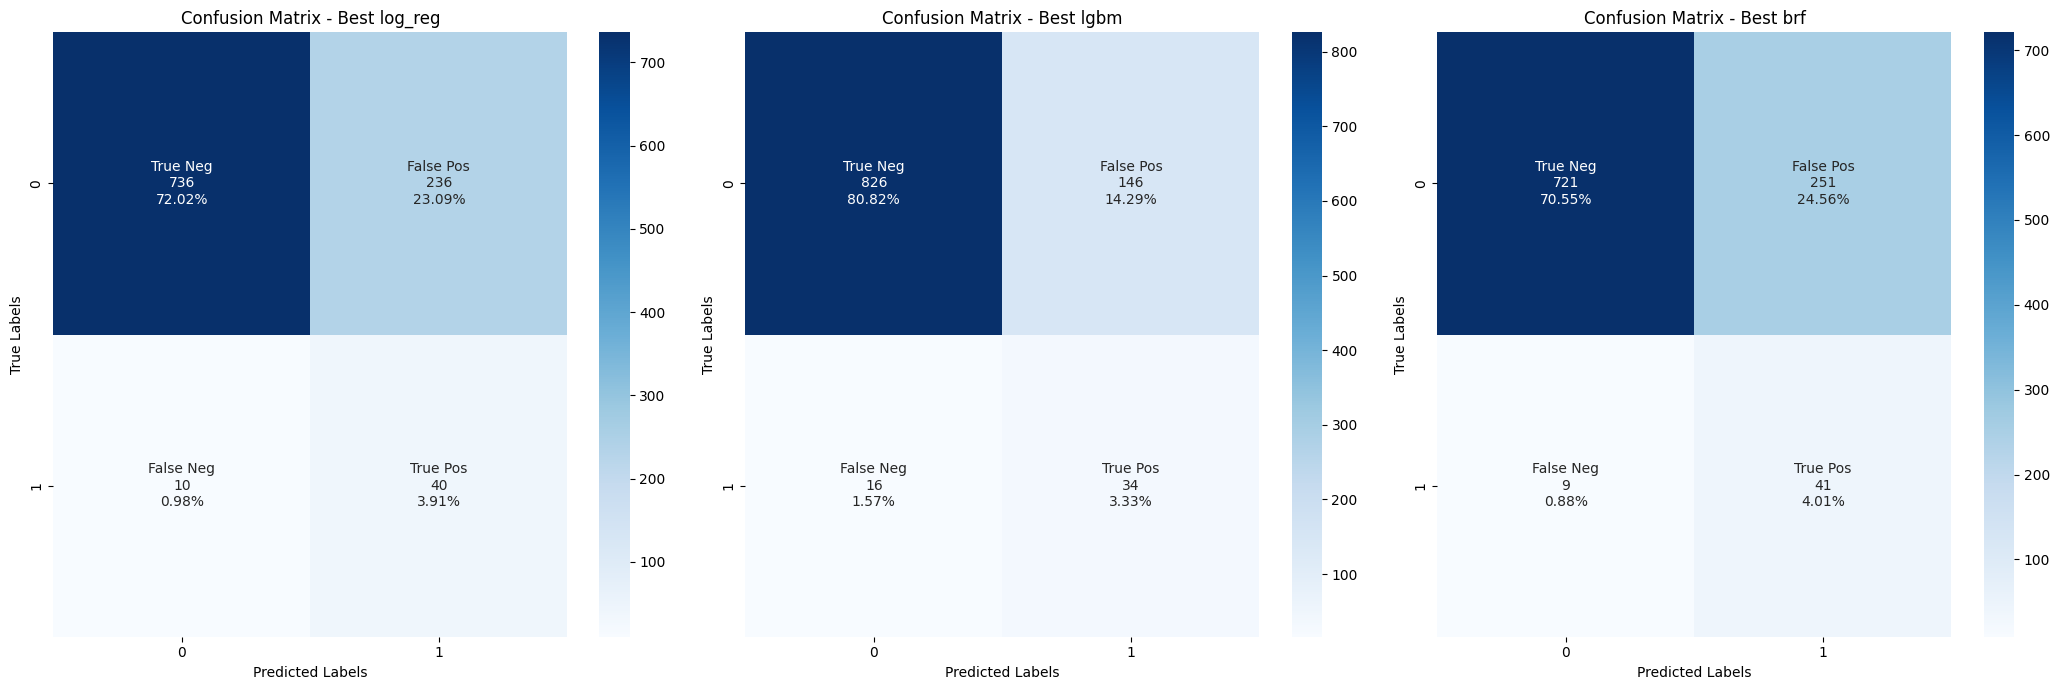

In [ ]:
y_pred_log_reg= best_log_reg_saga.predict(vt)
y_pred_lgbm= best_lgbm.predict(vt)
y_pred_brf = best_brf.predict(vt)

cm_log_reg = confusion_matrix(y_test, y_pred_log_reg)
cm_lgbm= confusion_matrix(y_test, y_pred_lgbm)
cm_brf = confusion_matrix(y_test, y_pred_brf)

labels_log_reg = format_cm_labels(cm_log_reg)
labels_lgbm = format_cm_labels(cm_lgbm)
labels_brf = format_cm_labels(cm_brf)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(21, 7))

sns.heatmap(cm_log_reg, annot=labels_log_reg, fmt="", cmap="Blues", ax=axes[0])
axes[0].set_title("Confusion Matrix - Best log_reg")
axes[0].set_xlabel("Predicted Labels")
axes[0].set_ylabel("True Labels")

sns.heatmap(cm_lgbm, annot=labels_lgbm, fmt="", cmap="Blues", ax=axes[1])
axes[1].set_title("Confusion Matrix - Best lgbm")
axes[1].set_xlabel("Predicted Labels")
axes[1].set_ylabel("True Labels")

sns.heatmap(cm_brf, annot=labels_brf, fmt="", cmap="Blues", ax=axes[2])
axes[2].set_title("Confusion Matrix - Best brf")
axes[2].set_xlabel("Predicted Labels")
axes[2].set_ylabel("True Labels")
plt.tight_layout()
plt.show()



The best light gradient boosted model correctly classifies the most true negatives. It also has the lowest true positive rate, which was the focus of this modelling task. 

The balanced random forest model has the highest true positive rate, though its true negative rate is slightly lower than the logistic regression model. Therefore, the best balanced random forest model is chosen as the best model here because having a high true positive rate and low false negative rate is most important. 

## Feature importance

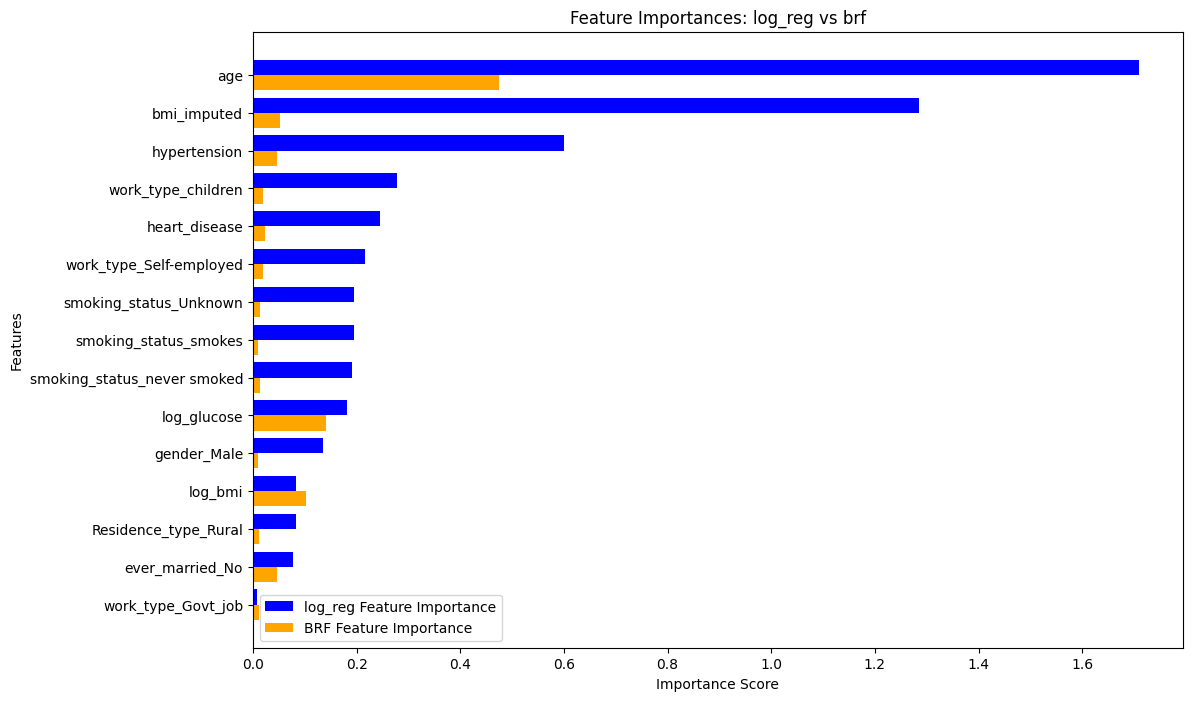

In [ ]:
feature_names = v.columns  
log_reg_importances = np.abs(best_log_reg_saga.coef_[0])
brf_importances = best_brf.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'log_reg Importance': log_reg_importances,
    'brf Importance': brf_importances
})

feature_importance_df = feature_importance_df.sort_values(by='log_reg Importance', ascending=False)
plt.figure(figsize=(12, 8))

bar_width = 0.4  
x = np.arange(len(feature_importance_df))

plt.barh(x - bar_width/2, feature_importance_df['log_reg Importance'], bar_width, label='log_reg Feature Importance', color='blue')
plt.barh(x + bar_width/2, feature_importance_df['brf Importance'], bar_width, label='BRF Feature Importance', color='orange')
plt.yticks(x, feature_importance_df['Feature']) 
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importances: log_reg vs brf')
plt.legend()
plt.gca().invert_yaxis() 
plt.show()


BRF importance scores are generally a lot lower than those for the logistic regression model. The most important variable for both models is a patient's age. Interestingly, the BRF model does not find the imputed bmi column to be imortant at all, and three features stand out for this model's determination of if a person will have a stroke or not: age, log(bmi), and log(avg_glucose_level). 

Looking at the actual values of the coefficients for the logistic regression model gives: 

Feature Importances (Logistic Regression):
                        Feature  Coefficient  Absolute Coefficient
9                           age     1.735887              1.735887
12                  bmi_imputed     1.408776              1.408776
13                 hypertension     0.632006              0.632006
3            work_type_children     0.493025              0.493025
5        smoking_status_Unknown    -0.279274              0.279274
2       work_type_Self-employed    -0.269796              0.269796
14                heart_disease     0.261955              0.261955
6   smoking_status_never smoked    -0.250403              0.250403
0                   gender_Male    -0.180576              0.180576
11                  log_glucose     0.180312              0.180312
7         smoking_status_smokes     0.169394              0.169394
4          Residence_type_Rural    -0.112767              0.112767
10                      log_bmi     0.084636              0.084636
8               eve

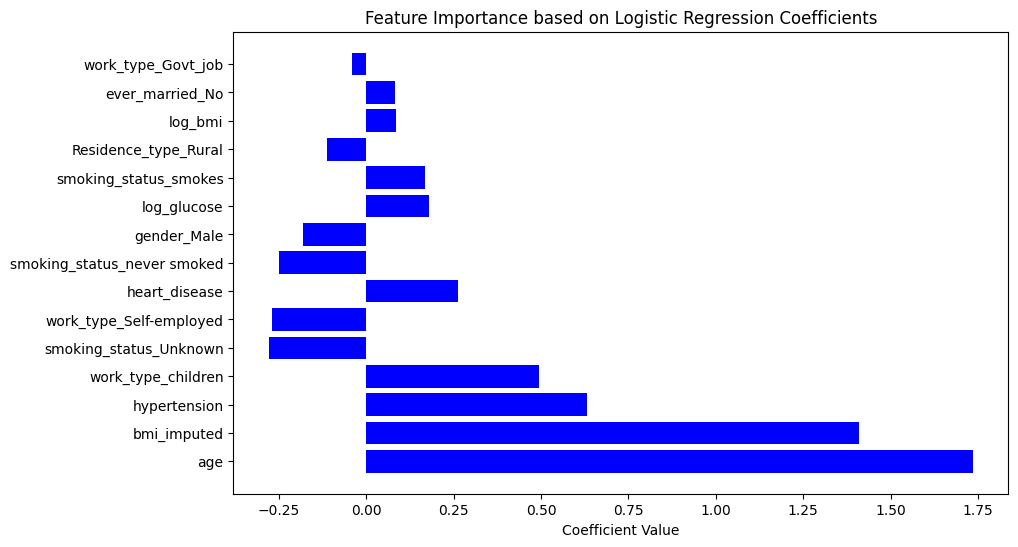

In [ ]:
coefficients = best_log_reg_lib.coef_[0] 
intercept = best_log_reg_lib.intercept_[0] 
feature_names = v.columns 
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Absolute Coefficient': np.abs(coefficients)
})

feature_importance_df = feature_importance_df.sort_values(by='Absolute Coefficient', ascending=False)

print("Feature Importances (Logistic Regression):")
print(feature_importance_df)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Coefficient'], color='blue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance based on Logistic Regression Coefficients')
plt.show()

For this model, the most important variables for stroke prediction are: 
- age (older patients are more likely to get strokes)
- whether the patient's bmi was missing in the original dataset or not (if the patient's bmi is missing, it seems that they are more likely to get a stroke)
- if the patient is a child or not (this variable is also related to age, though this does not quite make sense, as it seems that if the work type is set to children, then the chance of getting a stroke is higher)
- if the patient has hypertension or not (if a patient has hypertension, then they are more likely to get a stroke)

Scikit learn does not provide implementation to look at the p values of these coefficients, so this could be examined using statmodel's logistic model (see appendix). 

# Deployment

Now that the best model has been chosen, it can be deployed. The logistic regression model was chose because it is best at correctly classifying true positives and reducing false negatives. This model also has the benefit of explainability, as the coefficients directly indicate positive or negative feature importance. 

To deploy this, a pipeline is made and saved for data preprocessing that accepts data with no null values (the first pipeline takes care of this): 

In [ ]:
train_cleaned_1['log_bmi'] = np.log1p(train_cleaned_1['bmi'])
train_cleaned_1['log_glucose'] = np.log1p(train_cleaned_1['avg_glucose_level'])
test_cleaned_1['log_bmi'] = np.log1p(test_cleaned_1['bmi'])
test_cleaned_1['log_glucose'] = np.log1p(test_cleaned_1['avg_glucose_level'])
train_cleaned_1 = train_cleaned_1.drop(['id', 'avg_glucose_level', 'bmi', 'stroke'], axis=1)
test_cleaned_1 = test_cleaned_1.drop(['id', 'avg_glucose_level', 'bmi', 'stroke'], axis=1)

In [ ]:
category_transform = ['gender', 'work_type', 'Residence_type', 'smoking_status', 'ever_married']
num_features = ['age', 'log_bmi', 'log_glucose']
passthrough_columns = ['hypertension', 'heart_disease']

column_transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), category_transform), 
    ('scaler', StandardScaler(), num_features)

], remainder='passthrough')

pipeline_2 = Pipeline([
    ('drop_rows', drop_row(gender_col='gender')),
    ('column_transform', column_transformer),
])

pipeline_2.fit(train_cleaned_1)

train_transformed = pipeline_2.transform(train_cleaned_1)
test_transformed = pipeline_2.transform(test_cleaned_1)

train_processed = pd.DataFrame(train_transformed, columns=pipeline_2.named_steps['column_transform'].get_feature_names_out())
test_processed = pd.DataFrame(test_transformed, columns=pipeline_2.named_steps['column_transform'].get_feature_names_out())
train_processed.columns = train_processed.columns.str.replace('onehot__', '')
train_processed.columns = train_processed.columns.str.replace('scaler__', '')
train_processed.columns = train_processed.columns.str.replace('remainder__', '')
test_processed.columns = test_processed.columns.str.replace('onehot__', '')
test_processed.columns = train_processed.columns.str.replace('scaler__', '')
test_processed.columns = test_processed.columns.str.replace('remainder__', '')

for col in train_processed.columns:
    if col in num_features:  
        train_processed[col] = train_processed[col].astype(float)
        test_processed[col] = test_processed[col].astype(float)
    else: 
        train_processed[col] = train_processed[col].astype(int)
        test_processed[col] = test_processed[col].astype(int)

joblib.dump(pipeline_2, 'preprocessing_pipeline.joblib');

In [ ]:
train_processed.head()

,gender_Female,gender_Male,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,...,smoking_status_never smoked,smoking_status_smokes,ever_married_No,ever_married_Yes,age,log_bmi,log_glucose,bmi_imputed,hypertension,heart_disease
0,1,0,0,0,1,0,0,0,1,0,...,1,0,0,1,0.205463,0.639751,-0.984661,0,0,0
1,0,1,0,0,1,0,0,1,0,0,...,1,0,1,0,-1.255026,-1.091279,0.584005,0,0,0
2,1,0,0,0,0,1,0,1,0,0,...,1,0,0,1,1.046350,-0.446666,0.302711,0,0,0
3,0,1,0,0,1,0,0,0,1,0,...,0,1,0,1,0.028434,-0.461946,-1.139774,0,0,0
4,0,1,1,0,0,0,0,0,1,1,...,0,0,1,0,-1.299283,0.462067,-0.506756,0,0,0


The best balanced random forest model is also saved: 

In [ ]:

joblib.dump(best_brf, "best_brf.joblib")


['best_brf.joblib']

This notebook is also converted into a python file in case it needs to be accesed during deployment: 

In [ ]:
!jupyter nbconvert --to script stroke_project.ipynb


[NbConvertApp] Converting notebook stroke_project.ipynb to script
[NbConvertApp] Writing 80695 bytes to stroke_project.py


# Summary and Conclusions: 

Summary: 

This project had objective to predict the likelihood of a person getting a stroke based on 10 features. 

From the exploratory data analysis section, a general description of the sample includes people: 
- of gender male or female, 
- who are mostly aged between 25-61 years old,
- who do not have hypertension or heart disease,
- who have been married, 
- who work in the private sector, 
- who have blood glucose level between 80-115 mg/dL,
- who have bmi between 24-33%, and
- who have not had a stroke. 

People who have had a stroke are more frequently aged between 55-82 years old, have been married and do have heart disease and/or hypertension. 

Statistical inference is also performed on this dataset, and the chi squared test (categorical variables) or Mann-Whitney U test (numerical variables) indicated a relationship with the stroke variable and the following variables: 
- Age (higher age associated with higher stroke incidence),
- Bmi (higher bmi associated with higher stroke incidence),
- avg_glucose_level (higher glucose level associated with higher stroke incidence), 
- Heart disease,
- Hypertension,
- Work type,
- Smoking status, and
- Ever_married. 

The numerical variables were standardized and the categorical variables were one-hot-encoded before modelling. 

As this is quite an imbalanced dataset where 95% of the people in the dataset have not had a stroke, it was deemed important for modelling to reduce the false negative rate as much as possible (to correctly classify people that have had strokes, and reduce the number of people that have had a stroke that are classified as not having a stroke). 

Initial model evaluation showed that the best model in terms of metrics such as balanced accuracy, average precision,  the area under the precision-recall curve, and Matthew’s correlation coefficient is the logistic regression model. As logistic regression is sensitive to multicollinearity, the variance inflation factor is also checked for this dataset, and features are removed one by one until all remaining features have a VIF score of under 5. This dataset is then used for further tuning and evaluation. 

After tuning the best performing models, the balanced random forest was selected, as it had a slightly higher true negative rate than the logistic regression model (74% instead of 71%). 

This best balanced random forest model has accuracy and recall of 76%, balanced accuracy of 78%, average precision of 24%, and area under the precision-recall curve of about 0.26. This means that the model is able to accurately classify whether a new customer will purchase this company's travel insurance about 76% of the time.

Finally, the model was deployed using FastAPI and containerized with Docker for local deployment. 


Conclusions: 

From scikit-learn's logistic regression model, the four most important features for this model were found to be: 
- age,
- bmi_imputed,
- work_type children, and
- hypertension. 


These were all found to be positively correlated with stroke incidence: when one of these variables increased or was positive, then the probability of having a stroke also increased. However, scikit-learn does not provide p values for these coefficients to know if they are statistically important or not. When looking at this tuned model with statsmodels, it was found that only four features were statistically significant for predicting stroke incidence: 
- The probability of having a stroke increases as age increases,
- the probability of having a stroke increases if the bmi value for a data point is missing (this could be looked into more carefully by medical staff to see what really happened for patients that did not have a bmi value in the dataset, as there could be a different explanation for this), 
- the probability of having a stroke increases if the patient has hypertension, and
- patients with higher average glucose levels have a higher probability of getting a stroke, according to the selected model. 

For the tuned balanced random forest model, the most important features were found to be age, log_bmi, and log_glucose, which does agree with findings from the statsmodel's logistic regression model. 
These observations and this tuned balanced random forest model could help to predict if an incoming patient to a hospital is in danger of having a stroke or not, and as it explains key features that can indicate an increase in stroke likelihood for a patient. 

There is quite a bit of room for improvement; however, as this model does not correctly classify all non-stroke cases. More work could be done in stacking models that are good at predicting patients that have a stroke and patients that do not have a stroke (ex: logistic regression and gradient boosting). Being aided by a medical professional could also help with feature selection, model selection, and explanations for model coefficients.


# References: 
- https://www.nhlbi.nih.gov/health/educational/lose_wt/BMI/bmi_tbl.pdf
- https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset
- chatgpt


# Appendix: Feature Engineering and Statsmodel Logistic Regression

## Feature engineering: 

It is possible that features can be engineered to produce better modeling results. One way to do this is by binning the numerical features (age, bmi, and avg_glucose_level). First, the dataset is copied: 

In [ ]:
x_train_man = x_train.copy()
x_test_man = x_test.copy()

NameError: name 'x_train' is not defined

Now, the dataset can be binned in terms of quantiles: 

In [ ]:
pipeline = Pipeline([
    ('kbins', KBinsDiscretizer(n_bins=4, encode='onehot', strategy='quantile'))
])

kbins = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')  # 'ordinal' or 'onehot'
x_train_man['age_bins_kbins'] = kbins.fit_transform(x_train_man[['age']])
x_test_man['age_bins_kbins'] = kbins.transform(x_test_man[['age']])
x_train_man['bmi_bins_kbins'] = kbins.fit_transform(x_train_man[['log_bmi']])
x_test_man['bmi_bins_kbins'] = kbins.transform(x_test_man[['log_bmi']])
x_train_man['glucose_bins_kbins'] = kbins.fit_transform(x_train_man[['log_glucose']])
x_test_man['glucose_bins_kbins'] = kbins.transform(x_test_man[['log_glucose']])
x_train_man = x_train_man.drop(['age', 'log_bmi', 'log_glucose'], axis=1)
x_test_man = x_test_man.drop(['age', 'log_bmi', 'log_glucose'], axis=1)

Another feature can be added: heart_hyper, where 1 means that the person has heart disease and hypertension and 0 means that the person does not have heart disease or hypertension: 

In [ ]:
x_train_man['heart_hyper'] = x_train_man.apply(
    lambda row: 1 if row['hypertension'] == 1 and row['heart_disease'] == 1 else 0,
    axis=1
)
x_test_man['heart_hyper'] = x_test_man.apply(
    lambda row: 1 if row['hypertension'] == 1 and row['heart_disease'] == 1 else 0,
    axis=1
)

Looking at this: 

In [ ]:
x_train_man.head()

,gender_Female,gender_Male,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,...,smoking_status_smokes,ever_married_No,ever_married_Yes,bmi_imputed,hypertension,heart_disease,age_bins_kbins,bmi_bins_kbins,glucose_bins_kbins,heart_hyper
0,1,0,0,0,1,0,0,0,1,0,...,0,0,1,0,0,0,2.0,3.0,0.0,0
1,0,1,0,0,1,0,0,1,0,0,...,0,1,0,0,0,0,0.0,0.0,3.0,0
2,1,0,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,3.0,1.0,2.0,0
3,0,1,0,0,1,0,0,0,1,0,...,1,0,1,0,0,0,1.0,1.0,0.0,0
4,0,1,1,0,0,0,0,0,1,1,...,0,1,0,0,0,0,0.0,2.0,1.0,0


## Feature Engineered Dataset Model Evaluation: 

Evaluating the feature engineered dataset on the initial set of models gives: 

In [ ]:
f = get_results(models_initial_imbalanced, x_train_man, y_train, cv)


In [ ]:
f.sort_values(by='PR AUC', ascending=False)

,Model,accuracy,balanced accuracy,average precision,recall,weighted f1,f2,PR AUC,MCC
1,Logistic Regression,0.7335 ± 0.0156,0.7620 ± 0.0275,0.1148 ± 0.0133,0.7335 ± 0.0156,0.8092 ± 0.0108,0.7521 ± 0.0140,0.1148 ± 0.0133,0.2478 ± 0.0291
3,SVM,0.7118 ± 0.0231,0.7193 ± 0.0464,0.0974 ± 0.0155,0.7118 ± 0.0231,0.7935 ± 0.0167,0.7326 ± 0.0225,0.0974 ± 0.0155,0.2042 ± 0.0422
12,lightgbm,0.7362 ± 0.0110,0.6991 ± 0.0435,0.0933 ± 0.0163,0.7362 ± 0.0110,0.8107 ± 0.0077,0.7565 ± 0.0098,0.0933 ± 0.0163,0.1911 ± 0.0418
7,Balanced Random Forest,0.7727 ± 0.0176,0.6752 ± 0.0504,0.0898 ± 0.0182,0.7727 ± 0.0176,0.8348 ± 0.0118,0.7908 ± 0.0163,0.0898 ± 0.0182,0.1780 ± 0.0501
13,Balanced Bagging,0.7976 ± 0.0092,0.6456 ± 0.0301,0.0818 ± 0.0117,0.7976 ± 0.0092,0.8505 ± 0.0064,0.8142 ± 0.0080,0.0818 ± 0.0117,0.1569 ± 0.0333
9,hist_gradient_boosting,0.8417 ± 0.0052,0.6162 ± 0.0384,0.0774 ± 0.0142,0.8417 ± 0.0052,0.8769 ± 0.0041,0.8537 ± 0.0046,0.0774 ± 0.0142,0.1416 ± 0.0458
5,Naive Bayes,0.4422 ± 0.0573,0.6901 ± 0.0279,0.0774 ± 0.0058,0.4422 ± 0.0573,0.5621 ± 0.0616,0.4609 ± 0.0611,0.0774 ± 0.0058,0.1678 ± 0.0196
8,Gradient Boosting,0.9491 ± 0.0012,0.5275 ± 0.0127,0.0690 ± 0.0139,0.9491 ± 0.0012,0.9314 ± 0.0027,0.9417 ± 0.0017,0.0690 ± 0.0139,0.1282 ± 0.0486
2,Decision Tree,0.8989 ± 0.0084,0.5558 ± 0.0329,0.0646 ± 0.0122,0.8989 ± 0.0084,0.9073 ± 0.0061,0.9022 ± 0.0074,0.0646 ± 0.0122,0.0944 ± 0.0566
10,XGBoost,0.8784 ± 0.0087,0.5642 ± 0.0140,0.0628 ± 0.0049,0.8784 ± 0.0087,0.8962 ± 0.0052,0.8851 ± 0.0075,0.0628 ± 0.0049,0.0949 ± 0.0210


Comparing these results with those from the original data: 

In [ ]:
r.sort_values(by='PR AUC', ascending=False).iloc[[0, 1, 2]]

,Model,accuracy,balanced accuracy,average precision,recall,weighted f1,f2,PR AUC,MCC
1,Logistic Regression,0.7517 ± 0.0175,0.7740 ± 0.0230,0.1227 ± 0.0131,0.7517 ± 0.0175,0.8217 ± 0.0121,0.7688 ± 0.0159,0.1227 ± 0.0131,0.2640 ± 0.0264
12,lightgbm,0.8564 ± 0.0042,0.6812 ± 0.0281,0.1069 ± 0.0153,0.8564 ± 0.0042,0.8879 ± 0.0031,0.8665 ± 0.0037,0.1069 ± 0.0153,0.2231 ± 0.0332
7,Balanced Random Forest,0.7942 ± 0.0134,0.7106 ± 0.0302,0.1051 ± 0.0141,0.7942 ± 0.0134,0.8494 ± 0.0089,0.8100 ± 0.0121,0.1051 ± 0.0141,0.2201 ± 0.0326


The original dataset performs slightly better in all categories, and is used for the rest of the modeling section in this notebook.

## Statsmodel logistic regression evaluation: 

It is possible to show the best logistic regression model's coefficients with statsmodel's implementation, and in terms of log odds for better explainability: 

In [ ]:
v

,gender_Male,work_type_Govt_job,work_type_Self-employed,work_type_children,Residence_type_Rural,smoking_status_Unknown,smoking_status_never smoked,smoking_status_smokes,ever_married_No,age,log_bmi,log_glucose,bmi_imputed,hypertension,heart_disease
0,0,0,0,0,0,0,1,0,0,0.205463,0.639751,-0.984661,0,0,0
1,1,0,0,0,1,0,1,0,1,-1.255026,-1.091279,0.584005,0,0,0
2,0,0,1,0,1,0,1,0,0,1.046350,-0.446666,0.302711,0,0,0
3,1,0,0,0,0,0,0,1,0,0.028434,-0.461946,-1.139774,0,0,0
4,1,1,0,0,0,1,0,0,1,-1.299283,0.462067,-0.506756,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4082,0,0,0,0,0,0,0,0,0,0.072691,0.864873,-0.175374,0,0,0
4083,0,0,0,1,1,1,0,0,1,-1.210768,-1.370206,0.377994,0,0,0
4084,0,0,0,0,1,0,0,0,0,0.780806,0.983430,-0.632998,0,0,0
4085,1,0,0,0,0,1,0,0,0,-0.546910,-0.282377,-0.798827,0,0,0


In [ ]:
feature_names

Index(['gender_Male', 'work_type_Govt_job', 'work_type_Self-employed',
       'work_type_children', 'Residence_type_Rural', 'smoking_status_Unknown',
       'smoking_status_never smoked', 'smoking_status_smokes',
       'ever_married_No', 'age', 'log_bmi', 'log_glucose', 'bmi_imputed',
       'hypertension', 'heart_disease'],
      dtype='object')

Optimization terminated successfully.
         Current function value: 0.151073
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 4087
Model:                          Logit   Df Residuals:                     4071
Method:                           MLE   Df Model:                           15
Date:                Tue, 01 Apr 2025   Pseudo R-squ.:                  0.2238
Time:                        19:28:06   Log-Likelihood:                -617.44
converged:                       True   LL-Null:                       -795.50
Covariance Type:            nonrobust   LLR p-value:                 1.092e-66
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -4.1138      0.257    -16.031      0.000   

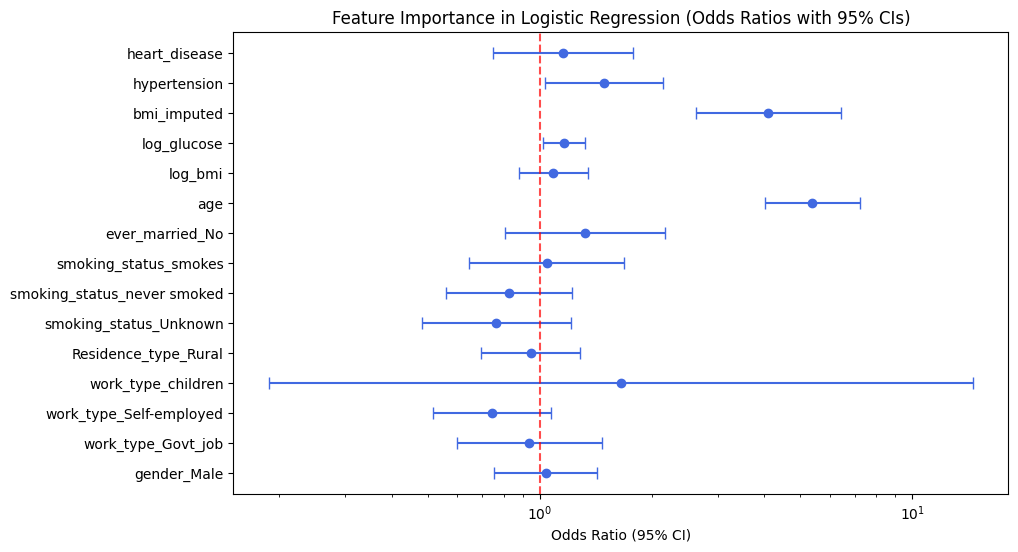

In [ ]:
x_sm = sm.add_constant(v)
log_reg_sm = sm.Logit(y_train, x_sm)
result = log_reg_sm.fit(start_params=np.append(intercept, coefficients))

coefs_df = pd.DataFrame({
    "Feature": ["Intercept"] + list(feature_names),
    "Coefficient": result.params,
    "Lower CI": result.conf_int()[0],
    "Upper CI": result.conf_int()[1]
})

coefs_df["Odds Ratio"] = np.exp(coefs_df["Coefficient"])
coefs_df["Lower CI OR"] = np.exp(coefs_df["Lower CI"])
coefs_df["Upper CI OR"] = np.exp(coefs_df["Upper CI"])
coefs_df = coefs_df.iloc[1:]


print(result.summary())

plt.figure(figsize=(10, 6))
plt.errorbar(
    coefs_df["Odds Ratio"], coefs_df["Feature"], 
    xerr=[coefs_df["Odds Ratio"] - coefs_df["Lower CI OR"], coefs_df["Upper CI OR"] - coefs_df["Odds Ratio"]],
    fmt='o', color='royalblue', capsize=4
)
plt.axvline(x=1, linestyle="--", color="red", alpha=0.7) 
plt.xlabel("Odds Ratio (95% CI)")
plt.title("Feature Importance in Logistic Regression (Odds Ratios with 95% CIs)")
plt.xscale("log")  
plt.show()

From this, it seems that quite a few of the coefficients for this model are not statistically significant at the 95% confidence level. These are: 
- gender_Male,
- work_type_Private,
- work_type_Self-employed,
- work_type_children,
- Residence_type_Urban,
- smoking_status_Unknown
- smoking_status_never smoked
- smoking_status_smokes
- ever_married_No
- bmi
- heart_disease

Without these features, the only ones left are: 
- age, 
- average glucose level,
- imputed bmi, and
- hypertenssion. 

Let's follow the same steps as before and look at different model outputs with only these features: 

In [ ]:
vv = (x_train.drop(['work_type_Never_worked', 'Residence_type_Urban', 'ever_married_Yes', 'heart_disease', 'log_bmi', 'ever_married_No', 'smoking_status_smokes', 'smoking_status_never smoked', 'smoking_status_Unknown', 'Residence_type_Rural', 'work_type_children', 'work_type_Self-employed', 'work_type_Private', 'gender_Male', 'smoking_status_formerly smoked', 'Residence_type_Rural', 'work_type_Govt_job', 'gender_Female', 'ever_married_No'], axis=1))
vvt  = (x_test.drop(['work_type_Never_worked', 'Residence_type_Urban', 'ever_married_Yes', 'heart_disease', 'log_bmi', 'ever_married_No', 'smoking_status_smokes', 'smoking_status_never smoked', 'smoking_status_Unknown', 'Residence_type_Rural', 'work_type_children', 'work_type_Self-employed', 'work_type_Private', 'gender_Male', 'smoking_status_formerly smoked', 'Residence_type_Rural', 'work_type_Govt_job', 'gender_Female', 'ever_married_No'], axis=1))


Optimization terminated successfully.
         Current function value: 0.151991
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 4087
Model:                          Logit   Df Residuals:                     4082
Method:                           MLE   Df Model:                            4
Date:                Tue, 01 Apr 2025   Pseudo R-squ.:                  0.2191
Time:                        19:28:06   Log-Likelihood:                -621.19
converged:                       True   LL-Null:                       -795.50
Covariance Type:            nonrobust   LLR p-value:                 3.457e-74
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -4.1746      0.157    -26.607      0.000      -4.482      -3.867
age              1.5811

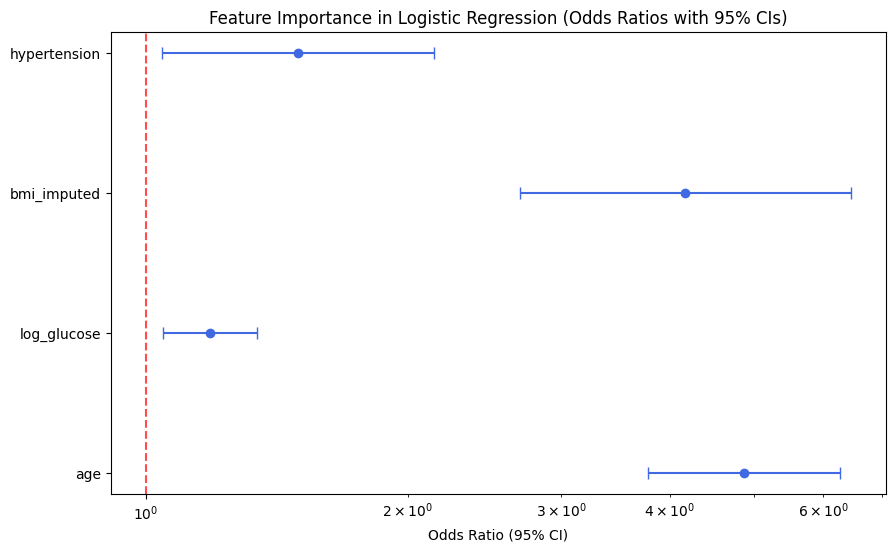

In [ ]:
start_params = np.append(intercept, coefficients[:x_sm.shape[1] - 1])

x_sm = sm.add_constant(vv)
log_reg_sm = sm.Logit(y_train, x_sm)

start_params = np.append(intercept, coefficients[:x_sm.shape[1] - 1])

result = log_reg_sm.fit(start_params=start_params)

coefs_df = pd.DataFrame({
    "Feature": ["Intercept"] + list(vv.columns),
    "Coefficient": result.params,
    "Lower CI": result.conf_int()[0],
    "Upper CI": result.conf_int()[1]
})

coefs_df["Odds Ratio"] = np.exp(coefs_df["Coefficient"])
coefs_df["Lower CI OR"] = np.exp(coefs_df["Lower CI"])
coefs_df["Upper CI OR"] = np.exp(coefs_df["Upper CI"])
coefs_df = coefs_df.iloc[1:]

print(result.summary())

plt.figure(figsize=(10, 6))
plt.errorbar(
    coefs_df["Odds Ratio"], coefs_df["Feature"], 
    xerr=[coefs_df["Odds Ratio"] - coefs_df["Lower CI OR"], coefs_df["Upper CI OR"] - coefs_df["Odds Ratio"]],
    fmt='o', color='royalblue', capsize=4
)
plt.axvline(x=1, linestyle="--", color="red", alpha=0.7) 
plt.xlabel("Odds Ratio (95% CI)")
plt.title("Feature Importance in Logistic Regression (Odds Ratios with 95% CIs)")
plt.xscale("log")  
plt.show()

In [ ]:
rr = get_results(models_initial_imbalanced, vv, y_train, cv)


In [ ]:
rr.sort_values(by='average precision', ascending=False)

,Model,accuracy,balanced accuracy,average precision,recall,weighted f1,f2,PR AUC,MCC
1,Logistic Regression,0.7512 ± 0.0201,0.7737 ± 0.0278,0.1226 ± 0.0153,0.7512 ± 0.0201,0.8213 ± 0.0138,0.7683 ± 0.0185,0.1226 ± 0.0153,0.2637 ± 0.0308
7,Balanced Random Forest,0.7835 ± 0.0100,0.7408 ± 0.0166,0.1147 ± 0.0080,0.7835 ± 0.0100,0.8428 ± 0.0066,0.7994 ± 0.0091,0.1147 ± 0.0080,0.2445 ± 0.0174
3,SVM,0.7201 ± 0.0315,0.7644 ± 0.0235,0.1134 ± 0.0092,0.7201 ± 0.0315,0.7993 ± 0.0228,0.7389 ± 0.0306,0.1134 ± 0.0092,0.2468 ± 0.0205
5,Naive Bayes,0.8921 ± 0.0149,0.6521 ± 0.0484,0.1109 ± 0.0333,0.8921 ± 0.0149,0.9087 ± 0.0107,0.8980 ± 0.0133,0.1109 ± 0.0333,0.2239 ± 0.0749
12,lightgbm,0.7984 ± 0.0094,0.7200 ± 0.0174,0.1092 ± 0.0085,0.7984 ± 0.0094,0.8523 ± 0.0062,0.8136 ± 0.0084,0.1092 ± 0.0085,0.2309 ± 0.0191
13,Balanced Bagging,0.8043 ± 0.0129,0.7113 ± 0.0182,0.1068 ± 0.0079,0.8043 ± 0.0129,0.8559 ± 0.0082,0.8191 ± 0.0117,0.1068 ± 0.0079,0.2250 ± 0.0194
9,hist_gradient_boosting,0.8654 ± 0.0109,0.6502 ± 0.0263,0.0953 ± 0.0143,0.8654 ± 0.0109,0.8923 ± 0.0069,0.8745 ± 0.0097,0.0953 ± 0.0143,0.1953 ± 0.0343
10,XGBoost,0.8975 ± 0.0072,0.6003 ± 0.0216,0.0814 ± 0.0117,0.8975 ± 0.0072,0.9092 ± 0.0048,0.9019 ± 0.0063,0.0814 ± 0.0117,0.1595 ± 0.0354
8,Gradient Boosting,0.9494 ± 0.0032,0.5227 ± 0.0184,0.0733 ± 0.0216,0.9494 ± 0.0032,0.9308 ± 0.0041,0.9416 ± 0.0034,0.0733 ± 0.0216,0.1220 ± 0.0946
4,KNN,0.9388 ± 0.0041,0.5362 ± 0.0195,0.0666 ± 0.0137,0.9388 ± 0.0041,0.9273 ± 0.0041,0.9340 ± 0.0039,0.0666 ± 0.0137,0.1089 ± 0.0614


As expected, the logistic model and the untuned balanced random forest model are still the best performing. The balanced random forest model outperforms the logistic regression model in terms of accuracy, F1, and F2 scores. It is slightly lower than the logistic regression model for all other metrics. Tuning these two models again for comparison purposes gives: 

### Logistic regression hyperparameter tuning: 

In [ ]:
param_space_liblinear = {
    'C': Real(0.001, 100, prior='log-uniform'), 
    'penalty': Categorical(['l1', 'l2']),  
    'solver': Categorical(['liblinear']),
    'class_weight': Categorical(['balanced', None])
}

log_reg = LogisticRegression(max_iter=10000, class_weight=class_weight_dict, random_state=42)
four_feat_log_reg = bayes_hyperparam_tuning(log_reg, vv, y_train, param_space_liblinear)

new_row_base = get_results({'four_feat_log_reg': four_feat_log_reg}, vv, y_train, cv)
rr = pd.concat([rr, new_row_base], ignore_index=True)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [ ]:
rr.sort_values(by='PR AUC', ascending=False)

,Model,accuracy,balanced accuracy,average precision,recall,weighted f1,f2,PR AUC,MCC
1,Logistic Regression,0.7512 ± 0.0201,0.7737 ± 0.0278,0.1226 ± 0.0153,0.7512 ± 0.0201,0.8213 ± 0.0138,0.7683 ± 0.0185,0.1226 ± 0.0153,0.2637 ± 0.0308
14,four_feat_log_reg,0.7507 ± 0.0202,0.7734 ± 0.0280,0.1225 ± 0.0154,0.7507 ± 0.0202,0.8210 ± 0.0139,0.7679 ± 0.0186,0.1225 ± 0.0154,0.2633 ± 0.0310
7,Balanced Random Forest,0.7835 ± 0.0100,0.7408 ± 0.0166,0.1147 ± 0.0080,0.7835 ± 0.0100,0.8428 ± 0.0066,0.7994 ± 0.0091,0.1147 ± 0.0080,0.2445 ± 0.0174
3,SVM,0.7201 ± 0.0315,0.7644 ± 0.0235,0.1134 ± 0.0092,0.7201 ± 0.0315,0.7993 ± 0.0228,0.7389 ± 0.0306,0.1134 ± 0.0092,0.2468 ± 0.0205
5,Naive Bayes,0.8921 ± 0.0149,0.6521 ± 0.0484,0.1109 ± 0.0333,0.8921 ± 0.0149,0.9087 ± 0.0107,0.8980 ± 0.0133,0.1109 ± 0.0333,0.2239 ± 0.0749
12,lightgbm,0.7984 ± 0.0094,0.7200 ± 0.0174,0.1092 ± 0.0085,0.7984 ± 0.0094,0.8523 ± 0.0062,0.8136 ± 0.0084,0.1092 ± 0.0085,0.2309 ± 0.0191
13,Balanced Bagging,0.8043 ± 0.0129,0.7113 ± 0.0182,0.1068 ± 0.0079,0.8043 ± 0.0129,0.8559 ± 0.0082,0.8191 ± 0.0117,0.1068 ± 0.0079,0.2250 ± 0.0194
9,hist_gradient_boosting,0.8654 ± 0.0109,0.6502 ± 0.0263,0.0953 ± 0.0143,0.8654 ± 0.0109,0.8923 ± 0.0069,0.8745 ± 0.0097,0.0953 ± 0.0143,0.1953 ± 0.0343
10,XGBoost,0.8975 ± 0.0072,0.6003 ± 0.0216,0.0814 ± 0.0117,0.8975 ± 0.0072,0.9092 ± 0.0048,0.9019 ± 0.0063,0.0814 ± 0.0117,0.1595 ± 0.0354
8,Gradient Boosting,0.9494 ± 0.0032,0.5227 ± 0.0184,0.0733 ± 0.0216,0.9494 ± 0.0032,0.9308 ± 0.0041,0.9416 ± 0.0034,0.0733 ± 0.0216,0.1220 ± 0.0946


Next, the balanced random forest will be tuned for comparison purposes: 

### Hyperparameter tuning for balanced random forest: 

In [ ]:

param_space_brf = {
    'n_estimators': (100, 300),
    'max_depth': (1, 10),         
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 20),  
    'bootstrap': [True, False],   
    'class_weight': ['balanced', 'balanced_subsample', None]
}
brf = BalancedRandomForestClassifier(random_state=42)
four_feat_best_brf = bayes_hyperparam_tuning(brf, vv, y_train, param_space_brf)

new_row_base = get_results({'four_feat_best_brf': four_feat_best_brf}, vv, y_train, cv)
rr = pd.concat([rr, new_row_base], ignore_index=True)
rr.sort_values(by='PR AUC', ascending=False)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

/Users/bt/Documents/turing/ml_2/.venv/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.True_, np.str_('balanced_subsample'), np.int64(9), np.int64(1), np.int64(2), np.int64(300)] before, using random point [False, 'balanced_subsample', np.int64(7), np.int64(19), np.int64(4), np.int64(201)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/bt/Documents/turing/ml_2/.venv/lib/python3.13/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.True_, None, np.int64(9), np.int64(1), np.int64(2), np.int64(300)] before, using random point [True, None, np.int64(6), np.int64(6), np.int64(2), np.int64(191)]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: OrderedDict({'bootstrap': True, 'class_weight': None, 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300})


,Model,accuracy,balanced accuracy,average precision,recall,weighted f1,f2,PR AUC,MCC
15,four_feat_best_brf,0.7495 ± 0.0200,0.7776 ± 0.0139,0.1233 ± 0.0079,0.7495 ± 0.0200,0.8201 ± 0.0138,0.7666 ± 0.0189,0.1233 ± 0.0079,0.2665 ± 0.0154
1,Logistic Regression,0.7512 ± 0.0201,0.7737 ± 0.0278,0.1226 ± 0.0153,0.7512 ± 0.0201,0.8213 ± 0.0138,0.7683 ± 0.0185,0.1226 ± 0.0153,0.2637 ± 0.0308
14,four_feat_log_reg,0.7507 ± 0.0202,0.7734 ± 0.0280,0.1225 ± 0.0154,0.7507 ± 0.0202,0.8210 ± 0.0139,0.7679 ± 0.0186,0.1225 ± 0.0154,0.2633 ± 0.0310
7,Balanced Random Forest,0.7835 ± 0.0100,0.7408 ± 0.0166,0.1147 ± 0.0080,0.7835 ± 0.0100,0.8428 ± 0.0066,0.7994 ± 0.0091,0.1147 ± 0.0080,0.2445 ± 0.0174
3,SVM,0.7201 ± 0.0315,0.7644 ± 0.0235,0.1134 ± 0.0092,0.7201 ± 0.0315,0.7993 ± 0.0228,0.7389 ± 0.0306,0.1134 ± 0.0092,0.2468 ± 0.0205
5,Naive Bayes,0.8921 ± 0.0149,0.6521 ± 0.0484,0.1109 ± 0.0333,0.8921 ± 0.0149,0.9087 ± 0.0107,0.8980 ± 0.0133,0.1109 ± 0.0333,0.2239 ± 0.0749
12,lightgbm,0.7984 ± 0.0094,0.7200 ± 0.0174,0.1092 ± 0.0085,0.7984 ± 0.0094,0.8523 ± 0.0062,0.8136 ± 0.0084,0.1092 ± 0.0085,0.2309 ± 0.0191
13,Balanced Bagging,0.8043 ± 0.0129,0.7113 ± 0.0182,0.1068 ± 0.0079,0.8043 ± 0.0129,0.8559 ± 0.0082,0.8191 ± 0.0117,0.1068 ± 0.0079,0.2250 ± 0.0194
9,hist_gradient_boosting,0.8654 ± 0.0109,0.6502 ± 0.0263,0.0953 ± 0.0143,0.8654 ± 0.0109,0.8923 ± 0.0069,0.8745 ± 0.0097,0.0953 ± 0.0143,0.1953 ± 0.0343
10,XGBoost,0.8975 ± 0.0072,0.6003 ± 0.0216,0.0814 ± 0.0117,0.8975 ± 0.0072,0.9092 ± 0.0048,0.9019 ± 0.0063,0.0814 ± 0.0117,0.1595 ± 0.0354


The two tuned models have similar metric scores in all categories, when taking into account the standard deviation. Now testing both models with holdout data: 

### Testing on holdout data: 

Looking at the classification report for the logistic regression model: 

In [ ]:
y_pred = four_feat_log_reg.predict(vvt)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      0.76      0.86       972
           1       0.15      0.80      0.25        50

    accuracy                           0.76      1022
   macro avg       0.57      0.78      0.55      1022
weighted avg       0.95      0.76      0.83      1022



As expected, the precision for people who do have strokes is quite low. Only 14% of predicted stroke cases were correct. The fact that this model did correctly classify 80% of true stroke cases, which is encouraging.

Looking at main metrics for this test case: 

In [ ]:
y_holdout_proba = four_feat_log_reg.predict_proba(vvt)[:, 1]
metrics_results = {
   'accuracy': accuracy_score(y_test, y_pred),
   'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
   'precision': average_precision_score(y_test, y_holdout_proba),
    'recall': recall_score(y_test, y_pred, average='weighted'),
    'weighted_f1': f1_score(y_test, y_pred, average='weighted'),
    'f2': fbeta_score(y_test, y_pred, beta=2, average='weighted'),
    'pr_auc': average_precision_score(y_test, y_holdout_proba),
    'mcc': matthews_corrcoef(y_test, y_pred)
}

model_name = "Best four_feat_log-reg-holdout"  
model_results = pd.DataFrame([[model_name] + list(metrics_results.values())], 
                             columns=r.columns)


rr = pd.concat([rr, model_results], ignore_index=True)
rr

,Model,accuracy,balanced accuracy,average precision,recall,weighted f1,f2,PR AUC,MCC
0,Dummy,0.9513 ± 0.0005,0.5000 ± 0.0000,0.0487 ± 0.0005,0.9513 ± 0.0005,0.9276 ± 0.0007,0.9417 ± 0.0006,0.0487 ± 0.0005,0.0000 ± 0.0000
1,Logistic Regression,0.7512 ± 0.0201,0.7737 ± 0.0278,0.1226 ± 0.0153,0.7512 ± 0.0201,0.8213 ± 0.0138,0.7683 ± 0.0185,0.1226 ± 0.0153,0.2637 ± 0.0308
2,Decision Tree,0.9219 ± 0.0030,0.5513 ± 0.0172,0.0653 ± 0.0093,0.9219 ± 0.0030,0.9197 ± 0.0031,0.9210 ± 0.0030,0.0653 ± 0.0093,0.1085 ± 0.0349
3,SVM,0.7201 ± 0.0315,0.7644 ± 0.0235,0.1134 ± 0.0092,0.7201 ± 0.0315,0.7993 ± 0.0228,0.7389 ± 0.0306,0.1134 ± 0.0092,0.2468 ± 0.0205
4,KNN,0.9388 ± 0.0041,0.5362 ± 0.0195,0.0666 ± 0.0137,0.9388 ± 0.0041,0.9273 ± 0.0041,0.9340 ± 0.0039,0.0666 ± 0.0137,0.1089 ± 0.0614
5,Naive Bayes,0.8921 ± 0.0149,0.6521 ± 0.0484,0.1109 ± 0.0333,0.8921 ± 0.0149,0.9087 ± 0.0107,0.8980 ± 0.0133,0.1109 ± 0.0333,0.2239 ± 0.0749
6,Random Forest,0.9415 ± 0.0034,0.5354 ± 0.0054,0.0647 ± 0.0038,0.9415 ± 0.0034,0.9286 ± 0.0022,0.9361 ± 0.0028,0.0647 ± 0.0038,0.1154 ± 0.0172
7,Balanced Random Forest,0.7835 ± 0.0100,0.7408 ± 0.0166,0.1147 ± 0.0080,0.7835 ± 0.0100,0.8428 ± 0.0066,0.7994 ± 0.0091,0.1147 ± 0.0080,0.2445 ± 0.0174
8,Gradient Boosting,0.9494 ± 0.0032,0.5227 ± 0.0184,0.0733 ± 0.0216,0.9494 ± 0.0032,0.9308 ± 0.0041,0.9416 ± 0.0034,0.0733 ± 0.0216,0.1220 ± 0.0946
9,hist_gradient_boosting,0.8654 ± 0.0109,0.6502 ± 0.0263,0.0953 ± 0.0143,0.8654 ± 0.0109,0.8923 ± 0.0069,0.8745 ± 0.0097,0.0953 ± 0.0143,0.1953 ± 0.0343


The linear regression model generalizes fairly well in terms of accuracy, balanced accuracy, recall, F1, and F2 scores. The holdout data's metrics are higher than those for the training data in terms of precision and pr-auc, and similar for MCC score though these were also not high for the trained model. 

Adding in the balanced random forest model's predictions for comparison purposes, as this was the second best performing model: 

In [ ]:
y_pred_four_feat_brf = four_feat_best_brf.predict(vvt)
print(classification_report(y_test, y_pred_four_feat_brf))

              precision    recall  f1-score   support

           0       0.99      0.77      0.87       972
           1       0.15      0.78      0.25        50

    accuracy                           0.77      1022
   macro avg       0.57      0.78      0.56      1022
weighted avg       0.94      0.77      0.84      1022



The precision for the 'stroke' cases is also low here, as is the corresponding F1 score. The weighted average recall and F1 score are both slightly lower than those found for the logistic regression model.

In [ ]:
y_holdout_proba = four_feat_best_brf.predict_proba(vvt)[:, 1]
metrics_results = {
   'accuracy': accuracy_score(y_test, y_pred),
   'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
   'precision': average_precision_score(y_test, y_holdout_proba),
    'recall': recall_score(y_test, y_pred, average='weighted'),
    'weighted_f1': f1_score(y_test, y_pred, average='weighted'),
    'f2': fbeta_score(y_test, y_pred, beta=2, average='weighted'),
    'pr_auc': average_precision_score(y_test, y_holdout_proba),
    'mcc': matthews_corrcoef(y_test, y_pred)
}

model_name = "Best four_feat_brf-holdout"  
model_results = pd.DataFrame([[model_name] + list(metrics_results.values())], 
                             columns=r.columns)


rr = pd.concat([rr, model_results], ignore_index=True)
rr

,Model,accuracy,balanced accuracy,average precision,recall,weighted f1,f2,PR AUC,MCC
0,Dummy,0.9513 ± 0.0005,0.5000 ± 0.0000,0.0487 ± 0.0005,0.9513 ± 0.0005,0.9276 ± 0.0007,0.9417 ± 0.0006,0.0487 ± 0.0005,0.0000 ± 0.0000
1,Logistic Regression,0.7512 ± 0.0201,0.7737 ± 0.0278,0.1226 ± 0.0153,0.7512 ± 0.0201,0.8213 ± 0.0138,0.7683 ± 0.0185,0.1226 ± 0.0153,0.2637 ± 0.0308
2,Decision Tree,0.9219 ± 0.0030,0.5513 ± 0.0172,0.0653 ± 0.0093,0.9219 ± 0.0030,0.9197 ± 0.0031,0.9210 ± 0.0030,0.0653 ± 0.0093,0.1085 ± 0.0349
3,SVM,0.7201 ± 0.0315,0.7644 ± 0.0235,0.1134 ± 0.0092,0.7201 ± 0.0315,0.7993 ± 0.0228,0.7389 ± 0.0306,0.1134 ± 0.0092,0.2468 ± 0.0205
4,KNN,0.9388 ± 0.0041,0.5362 ± 0.0195,0.0666 ± 0.0137,0.9388 ± 0.0041,0.9273 ± 0.0041,0.9340 ± 0.0039,0.0666 ± 0.0137,0.1089 ± 0.0614
5,Naive Bayes,0.8921 ± 0.0149,0.6521 ± 0.0484,0.1109 ± 0.0333,0.8921 ± 0.0149,0.9087 ± 0.0107,0.8980 ± 0.0133,0.1109 ± 0.0333,0.2239 ± 0.0749
6,Random Forest,0.9415 ± 0.0034,0.5354 ± 0.0054,0.0647 ± 0.0038,0.9415 ± 0.0034,0.9286 ± 0.0022,0.9361 ± 0.0028,0.0647 ± 0.0038,0.1154 ± 0.0172
7,Balanced Random Forest,0.7835 ± 0.0100,0.7408 ± 0.0166,0.1147 ± 0.0080,0.7835 ± 0.0100,0.8428 ± 0.0066,0.7994 ± 0.0091,0.1147 ± 0.0080,0.2445 ± 0.0174
8,Gradient Boosting,0.9494 ± 0.0032,0.5227 ± 0.0184,0.0733 ± 0.0216,0.9494 ± 0.0032,0.9308 ± 0.0041,0.9416 ± 0.0034,0.0733 ± 0.0216,0.1220 ± 0.0946
9,hist_gradient_boosting,0.8654 ± 0.0109,0.6502 ± 0.0263,0.0953 ± 0.0143,0.8654 ± 0.0109,0.8923 ± 0.0069,0.8745 ± 0.0097,0.0953 ± 0.0143,0.1953 ± 0.0343


In [ ]:
rr.iloc[[-1, -3, -2, -4]]

,Model,accuracy,balanced accuracy,average precision,recall,weighted f1,f2,PR AUC,MCC
17,Best four_feat_brf-holdout,0.762231,0.780144,0.215305,0.762231,0.828905,0.778553,0.215305,0.273154
15,four_feat_best_brf,0.7495 ± 0.0200,0.7776 ± 0.0139,0.1233 ± 0.0079,0.7495 ± 0.0200,0.8201 ± 0.0138,0.7666 ± 0.0189,0.1233 ± 0.0079,0.2665 ± 0.0154
16,Best four_feat_log-reg-holdout,0.762231,0.780144,0.257611,0.762231,0.828905,0.778553,0.257611,0.273154
14,four_feat_log_reg,0.7507 ± 0.0202,0.7734 ± 0.0280,0.1225 ± 0.0154,0.7507 ± 0.0202,0.8210 ± 0.0139,0.7679 ± 0.0186,0.1225 ± 0.0154,0.2633 ± 0.0310


The balanced random forest model also generalizes well to new data and has the same predicted values as the logistic regression model for almost all scores. The logistic regression model has slightly higher scores than the balanced random forest model for precision and pr-auc. Looking at the confusion matrix for both models will help to say if there is an important difference between the two models:


### Confusion Matrix: 

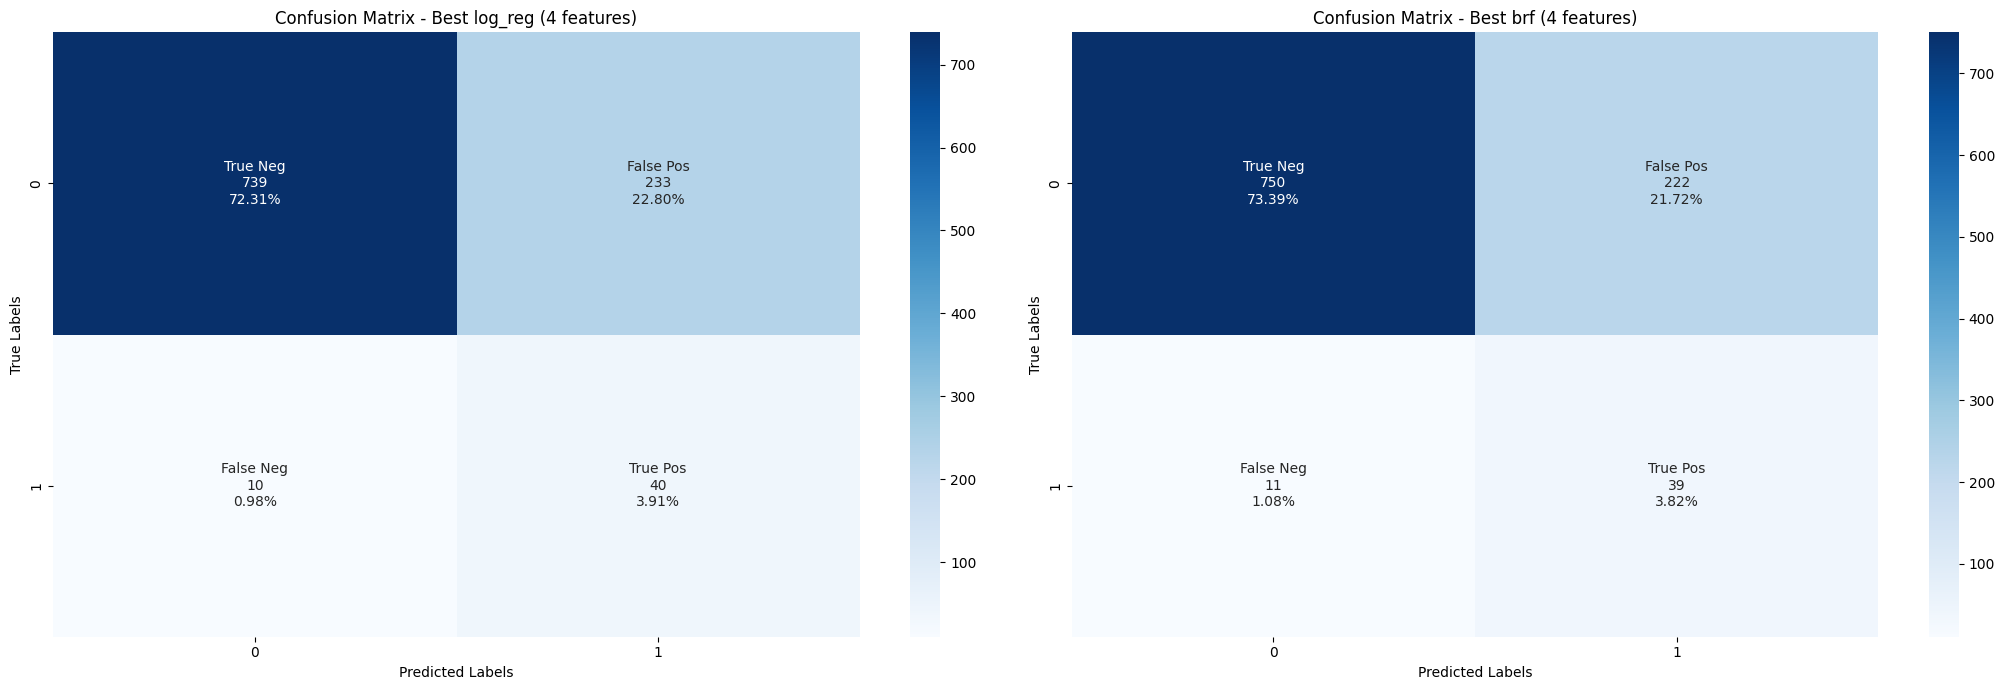

In [ ]:
y_pred_log_reg_four_feat = four_feat_log_reg.predict(vvt)
y_pred_brf_four_feat = four_feat_best_brf.predict(vvt)

cm_log_reg = confusion_matrix(y_test, y_pred_log_reg_four_feat)
cm_brf = confusion_matrix(y_test, y_pred_brf_four_feat)

labels_log_reg = format_cm_labels(cm_log_reg)
labels_brf = format_cm_labels(cm_brf)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(21, 7))
sns.heatmap(cm_log_reg, annot=labels_log_reg, fmt="", cmap="Blues", ax=axes[0])
axes[0].set_title("Confusion Matrix - Best log_reg (4 features)")
axes[0].set_xlabel("Predicted Labels")
axes[0].set_ylabel("True Labels")

sns.heatmap(cm_brf, annot=labels_brf, fmt="", cmap="Blues", ax=axes[1])
axes[1].set_title("Confusion Matrix - Best brf (4 features)")
axes[1].set_xlabel("Predicted Labels")
axes[1].set_ylabel("True Labels")
plt.tight_layout()
plt.show()



The logistic regression model correctly classifies more true positives than the balanced random forest model. However, it has less true negatives (about 1% less) than the balanced random forest model. Therefore, the balanced random forest model would be selected at the best model in this four features case. Both of these models perform slightly worse than the logistic regression model with all features. 

It could still be interesting to see the most important features for both models: 

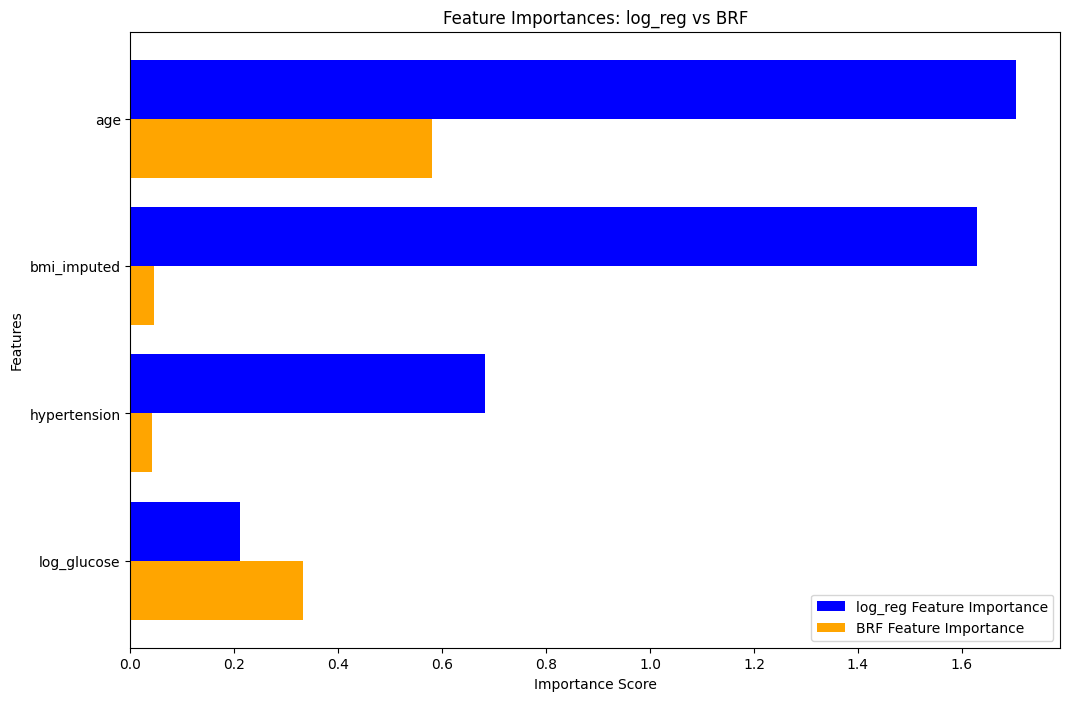

In [ ]:
feature_names = vv.columns  
log_reg_importances = np.abs(four_feat_log_reg.coef_[0])
brf_importances = four_feat_best_brf.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'log_reg Importance': log_reg_importances,
    'BRF Importance': brf_importances
})

feature_importance_df = feature_importance_df.sort_values(by='log_reg Importance', ascending=False)
plt.figure(figsize=(12, 8))

bar_width = 0.4  
x = np.arange(len(feature_importance_df))

plt.barh(x - bar_width/2, feature_importance_df['log_reg Importance'], bar_width, label='log_reg Feature Importance', color='blue')
plt.barh(x + bar_width/2, feature_importance_df['BRF Importance'], bar_width, label='BRF Feature Importance', color='orange')
plt.yticks(x, feature_importance_df['Feature']) 
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importances: log_reg vs BRF')
plt.legend()
plt.gca().invert_yaxis() 
plt.show()


The most important variable for both models is still a patient's age. The balanced random forest model shows the average glucose level to be the second most important feature, followed by if the bmi value was missing or not and finally hypertension. Looking at the actual values of the coefficients for the logistic regression model gives: 

Feature Importances (Logistic Regression):
        Feature  Coefficient  Absolute Coefficient
0           age     1.704565              1.704565
2   bmi_imputed     1.630024              1.630024
3  hypertension     0.681600              0.681600
1   log_glucose     0.211178              0.211178


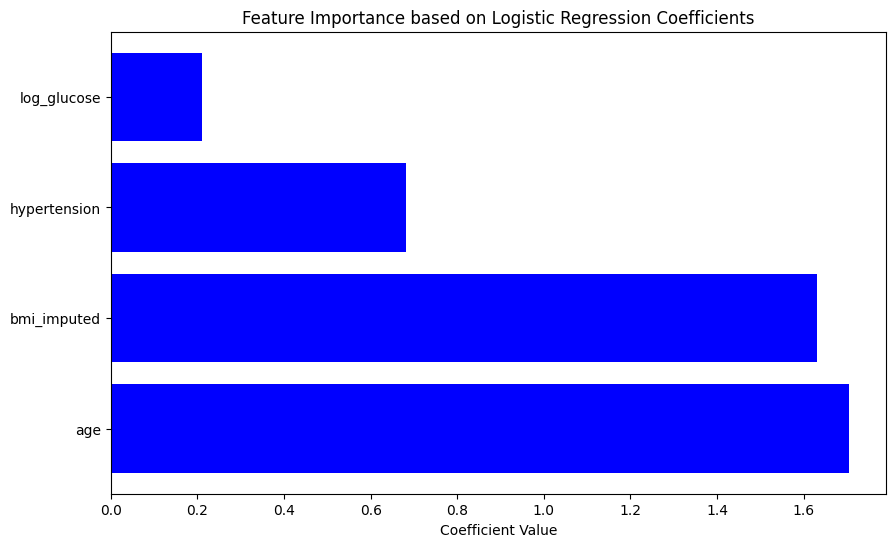

In [ ]:
coefficients = four_feat_log_reg.coef_[0] 
intercept = four_feat_log_reg.intercept_[0] 
feature_names = vv.columns 
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Absolute Coefficient': np.abs(coefficients)
})

feature_importance_df = feature_importance_df.sort_values(by='Absolute Coefficient', ascending=False)

print("Feature Importances (Logistic Regression):")
print(feature_importance_df)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Coefficient'], color='blue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance based on Logistic Regression Coefficients')
plt.show()

For this model, the most important variables for stroke prediction are: 
- age (older patients are more likely to get strokes)
- whether the patient's bmi was missing in the original dataset or not (if the patient's bmi is missing, it seems that they are more likely to get a stroke)
- if the patient has hypertension or not (if a patient has hypertension, then they are more likely to get a stroke)
- the patient's average glucose level (patients with higher values are more likely to get a stroke)